### Import necessary spark and python stuff

In [1]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import from_json
from pyspark.ml.feature import VectorAssembler

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### select the data
*path_on_hdfs_to_your_data*

In [3]:
df = spark.read.json("/user/rucio01/traces/traces.2018-04*")

### Get statistics


In [4]:
# use this for calculating percentages
df.count()

244917469

In [5]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 200)

In [6]:
df.describe().toPandas()

summary   account                 appid              catStart  clientState  \
0  count   46198012  190510301             154140898             236605939     
1  mean    None      3.9012113396941657E9  1.5238470959381647E9  None          
2  stddev  None      4.669968765060587E7   727876.2308556511     None          
3  min               1247                  1.30299742000964E9    AD_MISMATCH   
4  max     zzheng    [null]                1.525410625654198E9   TypeError     

                                                                                 dataset  \
0  240117308                                                                               
1  None                                                                                    
2  None                                                                                    
3                                                                                          
4  valid3.110401.PowhegPythia_P2012_ttbar_nonallhad.simul.log.e2928_s3213_tid12503332_00   

                                                                                                                datasetName  \
0  34222                                                                                                                      
1  None                                                                                                                       
2  None                                                                                                                       
3                                                                                                                             
4  mc16_13TeV.364197.Sherpa_221_NNPDF30NNLO_Wtaunu_MAXHTPTV1000_E_CMS.merge.NTUP_PILEUP.e5340_s3126_r9364_r9315_p3127_p3126   

  datasetScope  dataset_scope  duid  eventType        eventVersion  \
0  43971615     455            0     244917469  242691525            
1  None         None           None  None       None                 
2  None         None           None  None       None                 
3                              None  download   1.13.2               
4  valid3       user.mlassnig  None  upload     webui_1.15.3.post1   

                                                   filename  \
0  229946432                                                  
1  None                                                       
2  None                                                       
3  0000070a-83fe-4947-b720-7eae9b56d470_18852.1.job.log.tgz   
4  wjets_v1.15_small.root                                     

               filesize                              guid  \
0  230290664             193582905                          
1  6.734416453222805E8   Infinity                           
2  1.4486650895284996E9  NaN                                
3  0                     0000001C764E574C99F8794622F19138   
4  999999972             fffffff257fa45309d9d7cdee82d2fcc   

                      hostname                        ip            localSite  \
0  234380009                    190407943                 200914738             
1  None                         None                      None                  
2  None                         None                      None                  
3                                                         AGLT2_DATADISK        
4  zorana02.rc.fas.harvard.edu  fd18:deca:fbad:cafe::311  wuppertalprod_UCORE   

                                                                                            name  \
0  8834                                                                                            
1  None                                                                                            
2  None                                                                                            
3  AOD.11189316._000046.pool.root.1                                                                
4  user.wichan.361108.PowhegPythia8EvtGen_AZNLOCTEQ

In [7]:
split_col = split(df['dataset'], "\.")
df = df.withColumn('project', split_col.getItem(0))
df = df.withColumn('run_number', split_col.getItem(1))
df = df.withColumn('stream_name', split_col.getItem(2))
df = df.withColumn('prod_step', split_col.getItem(3))
df = df.withColumn('datatype', split_col.getItem(4))
df = df.withColumn('dataset_version', split_col.getItem(5))

In [8]:
df.createOrReplaceTempView('traces')

In [9]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT account, COUNT(*) as count\
                   FROM traces \
                   GROUP BY account \
                   ORDER BY count DESC)")
df_plot1 = df_ps.limit(10).toPandas()
df_plot1

account      count  percentage
0  None      198719457  81.14     
1  pilot     33127818   13.53     
2            2225941    0.91      
3  dlesny    1830772    0.75      
4  jwalder   1024981    0.42      
5  atlpan    696036     0.28      
6  sutt      600578     0.25      
7  atlascdb  303218     0.12      
8  ichiu     250169     0.10      
9  kuno      225287     0.09

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[Text(0,0.5,u'count')]

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


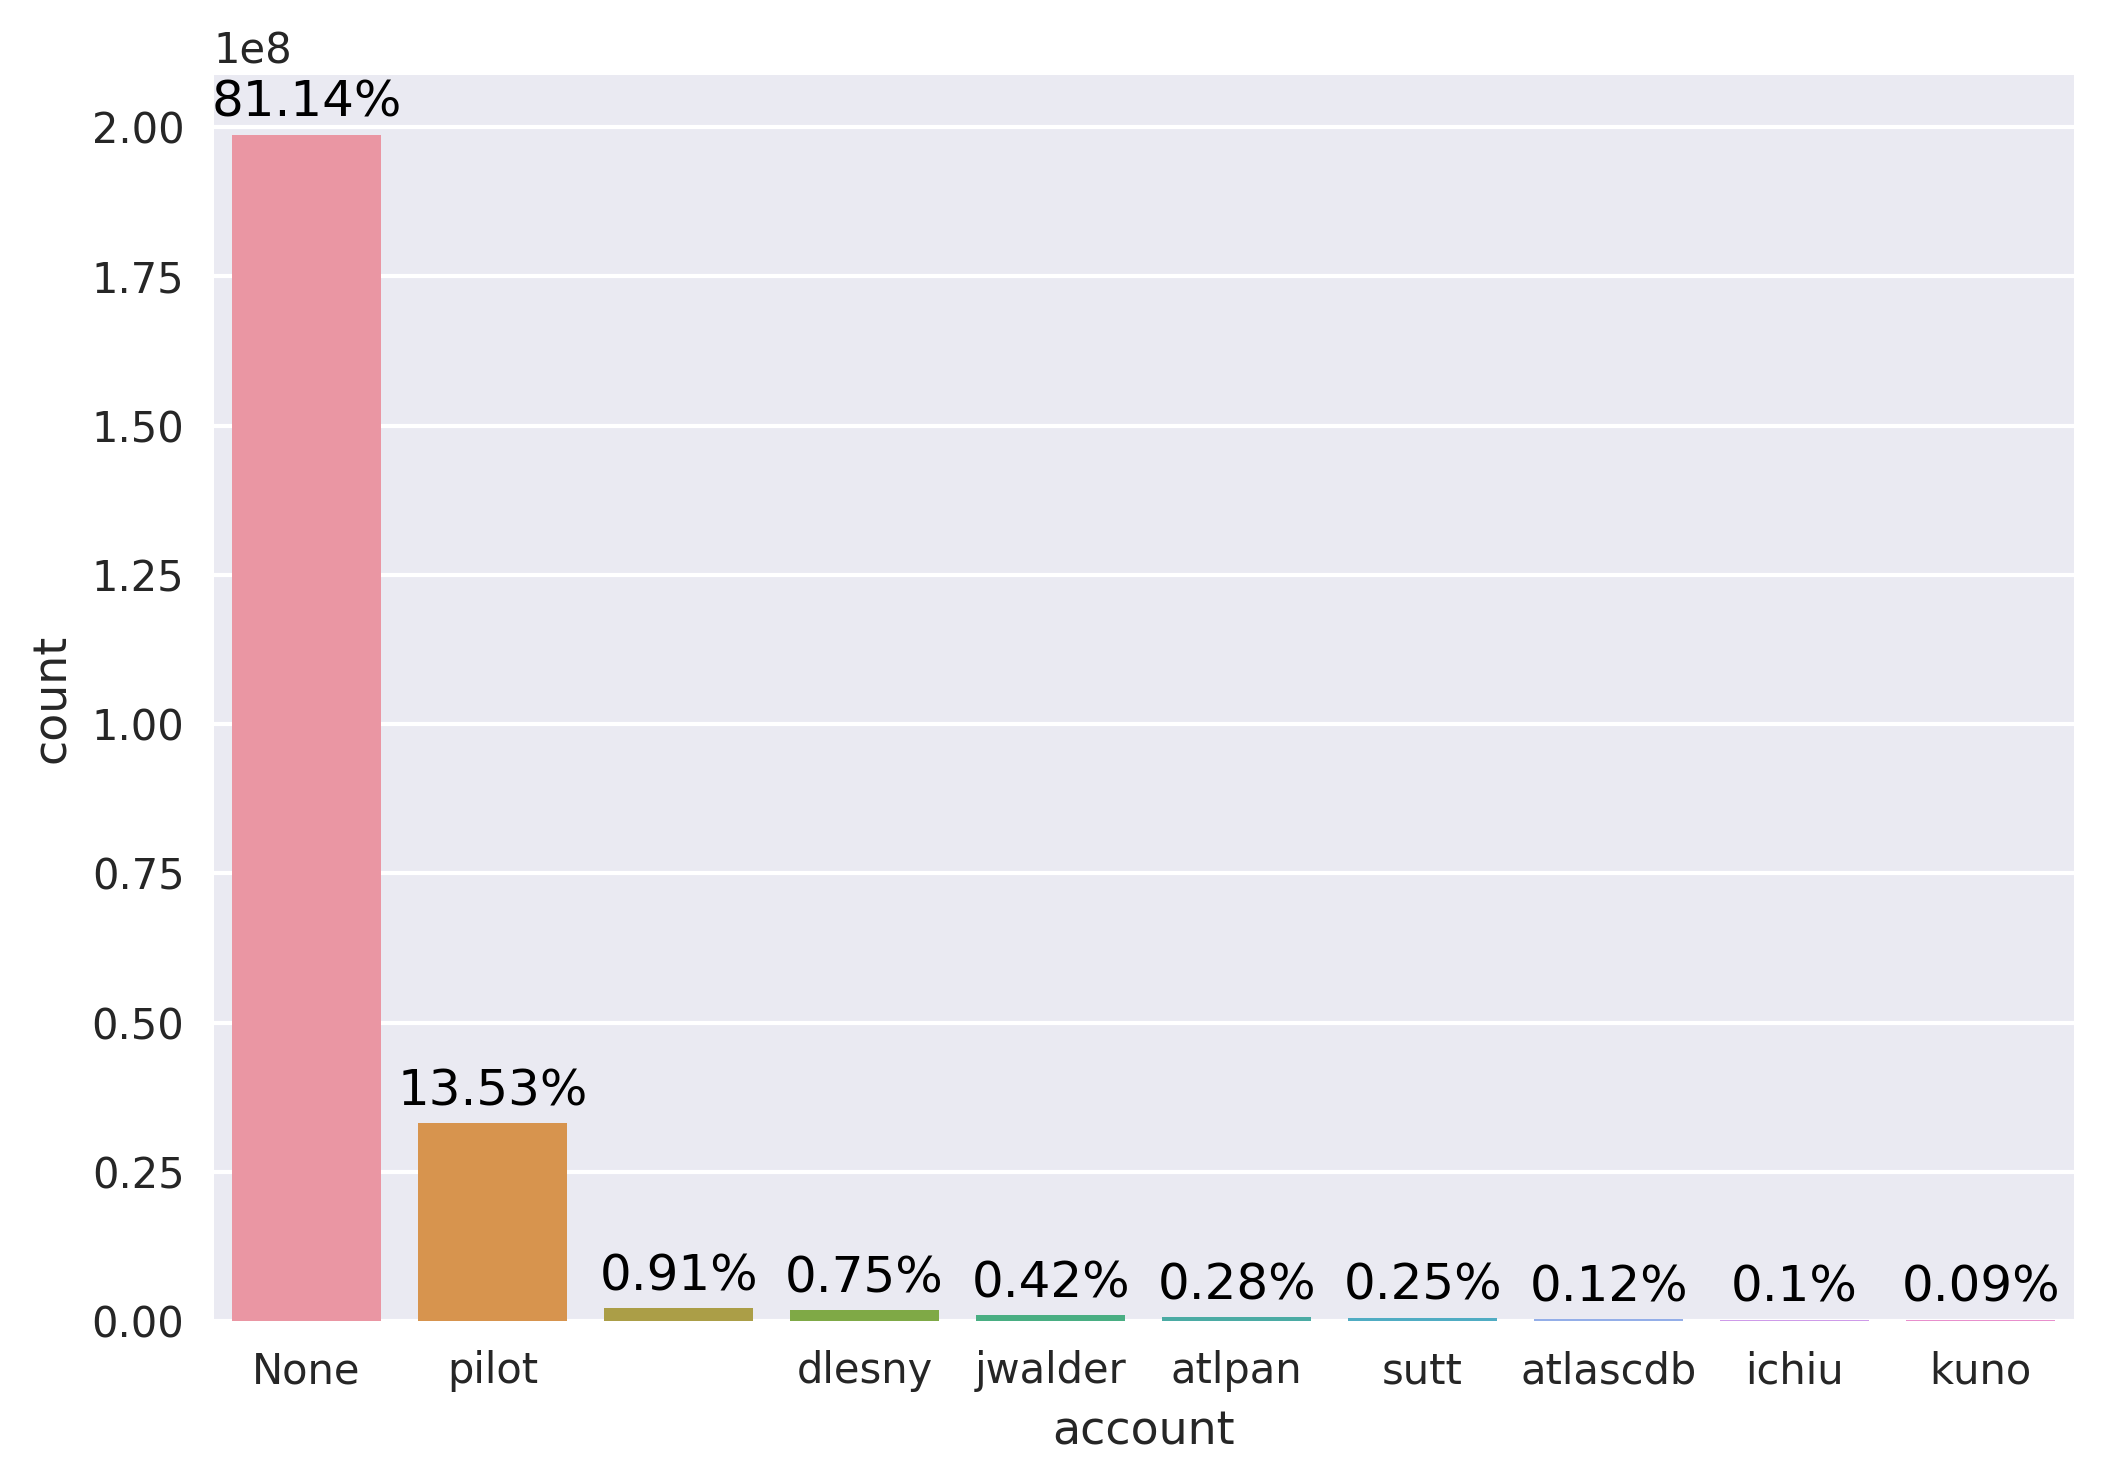

In [10]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

df_plot1['account'] = df_plot1.account.astype(str)

ax=sns.barplot(x="account", y="count", data=df_plot1, ci=None)

for index, row in df_plot1.iterrows():
    ax.text(row.name,row['count']+3000000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')

In [11]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT clientState, COUNT(*) as count\
                   FROM traces \
                   GROUP BY clientState \
                   ORDER BY count DESC)")
df_plot2 = df_ps.limit(10).toPandas()
df_plot2

clientState      count  percentage
0  DONE                     186761455  76.25     
1  FOUND_ROOT               35893241   14.66     
2  None                     8311530    3.39      
3  ALREADY_DONE             5470162    2.23      
4  STAGEIN_ATTEMPT_FAILED   4759065    1.94      
5  STAGEOUT_ATTEMPT_FAILED  1211657    0.49      
6  COPY_ERROR               780667     0.32      
7  ServiceUnavailable       605572     0.25      
8  MissingDependency        361320     0.15      
9  NO_OS_DEFINED            282965     0.12

[Text(0,0,u'DONE'),
 Text(0,0,u'FOUND_ROOT'),
 Text(0,0,u'None'),
 Text(0,0,u'ALREADY_DONE'),
 Text(0,0,u'STAGEIN_ATTEMPT_FAILED'),
 Text(0,0,u'STAGEOUT_ATTEMPT_FAILED'),
 Text(0,0,u'COPY_ERROR'),
 Text(0,0,u'ServiceUnavailable'),
 Text(0,0,u'MissingDependency'),
 Text(0,0,u'NO_OS_DEFINED')]

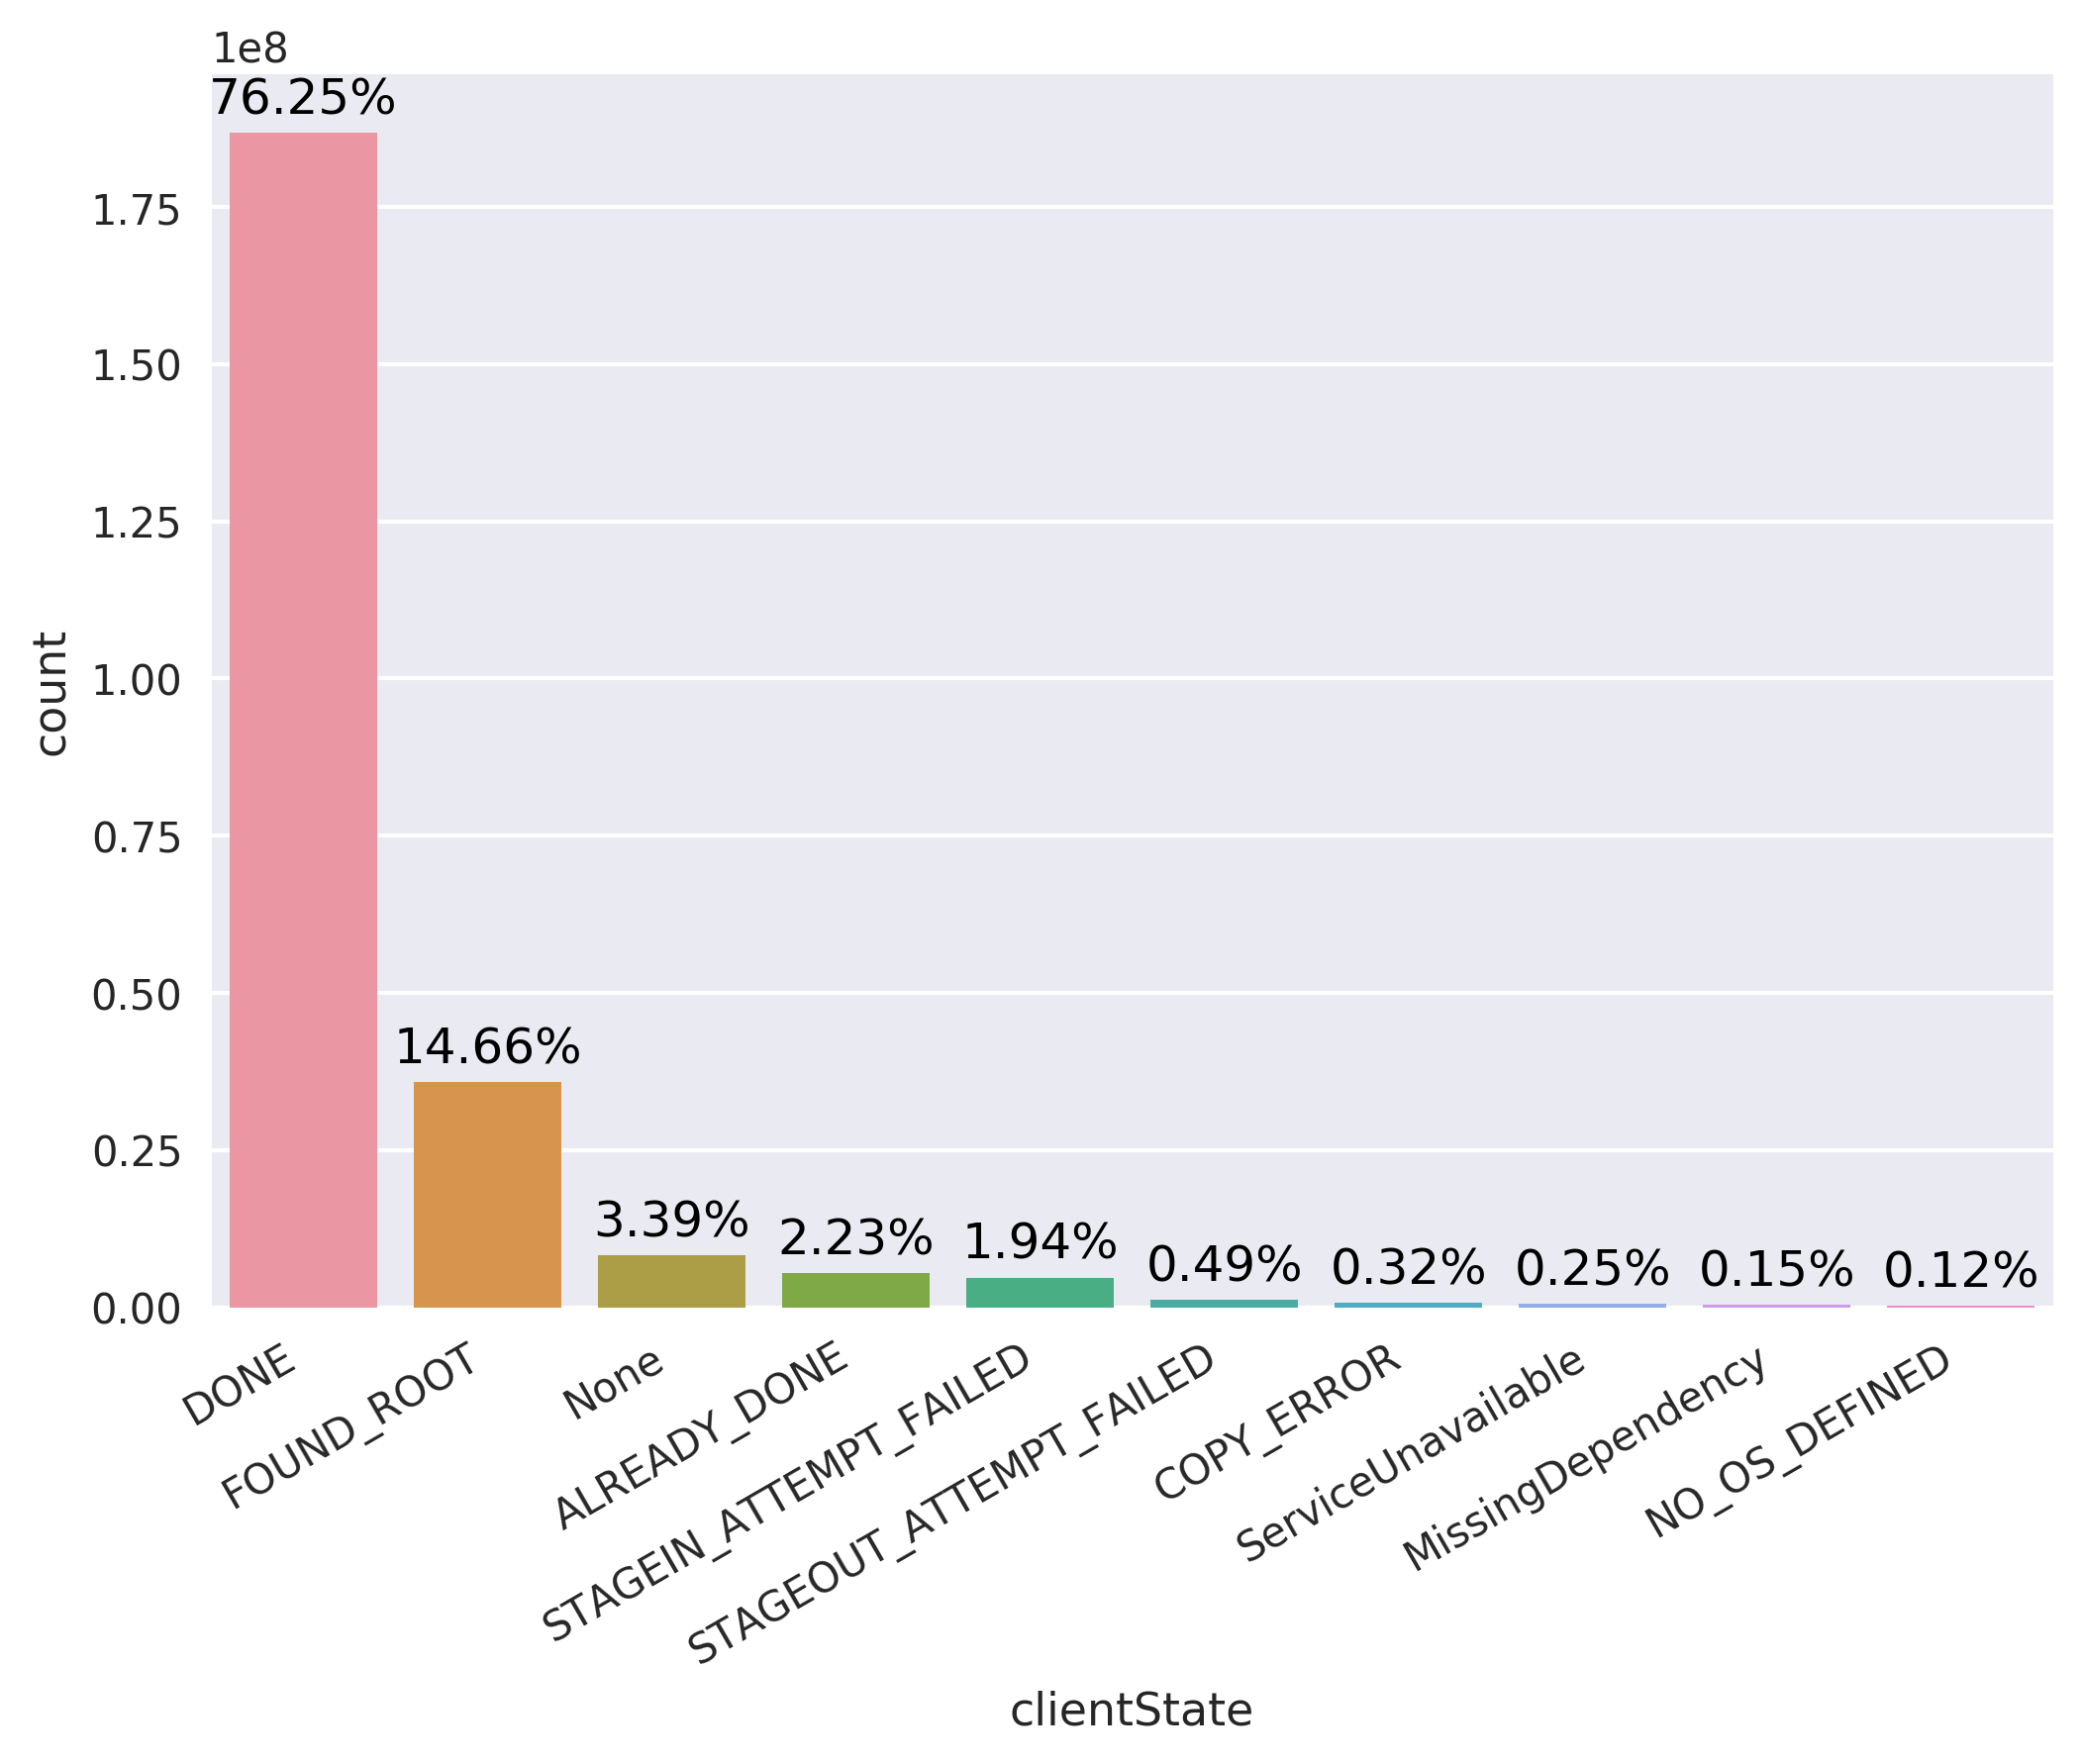

In [76]:
df_plot2['clientState'] = df_plot2.clientState.astype(str)

ax=sns.barplot(x="clientState", y="count", data=df_plot2, ci=None)

for index, row in df_plot2.iterrows():
    ax.text(row.name,row['count']+3000000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right")

In [13]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT dataset, COUNT(*) as count\
                   FROM traces \
                   GROUP BY dataset \
                   ORDER BY count DESC)")
df_plot3 = df_ps.limit(10).toPandas()
df_plot3

dataset  \
0                                                                                                                       
1  NULL                                                                                                                 
2  None                                                                                                                 
3  mc16_13TeV:mc16_13TeV.361238.Pythia8EvtGen_A3NNPDF23LO_minbias_inelastic_low.simul.HITS.e4981_s3087_s3111/           
4  mc16_13TeV:mc16_13TeV.361239.Pythia8EvtGen_A3NNPDF23LO_minbias_inelastic_high.simul.HITS.e4981_s3087_s3111/          
5  hc_test:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.evgen.EVNT.e3601_tid04972714_00                       
6  mc15_13TeV:mc15_13TeV.423202.Pythia8B_A14_CTEQ6L1_Jpsie3e13.merge.AOD.e3869_s2608_s2183_r6630_r6264_tid05536542_00   
7  mc15_13TeV:mc15_13TeV.364161.Sherpa_221_NNPDF30NNLO_Wmunu_MAXHTPTV70_140_BFilter.evgen.EVNT.e5340_tid11172999_00     
8  user.jwalder.test_15074_28212_MYSTREAM                                                                               
9  mc15_13TeV:mc15_13TeV.410450.Powheg_ttbar_hdamp258p75_LHE.evgen.TXT.e6078/                                           

      count  percentage  
0  37719600  15.40       
1  6357248   2.60        
2  4800161   1.96        
3  1641748   0.67        
4  985656    0.40        
5  823682    0.34        
6  796902    0.33        
7  791669    0.32        
8  602623    0.25        
9  465155    0.19

[Text(0,0,u''),
 Text(0,0,u'NULL'),
 Text(0,0,u'None'),
 Text(0,0,u'mc16_13TeV:mc16_13TeV.361238.Pythia8EvtGen_A3NNPDF23LO_minbias_inelastic_low.simul.HITS.e4981_s3087_s3111/'),
 Text(0,0,u'mc16_13TeV:mc16_13TeV.361239.Pythia8EvtGen_A3NNPDF23LO_minbias_inelastic_high.simul.HITS.e4981_s3087_s3111/'),
 Text(0,0,u'hc_test:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.evgen.EVNT.e3601_tid04972714_00'),
 Text(0,0,u'mc15_13TeV:mc15_13TeV.423202.Pythia8B_A14_CTEQ6L1_Jpsie3e13.merge.AOD.e3869_s2608_s2183_r6630_r6264_tid05536542_00'),
 Text(0,0,u'mc15_13TeV:mc15_13TeV.364161.Sherpa_221_NNPDF30NNLO_Wmunu_MAXHTPTV70_140_BFilter.evgen.EVNT.e5340_tid11172999_00'),
 Text(0,0,u'user.jwalder.test_15074_28212_MYSTREAM'),
 Text(0,0,u'mc15_13TeV:mc15_13TeV.410450.Powheg_ttbar_hdamp258p75_LHE.evgen.TXT.e6078/')]

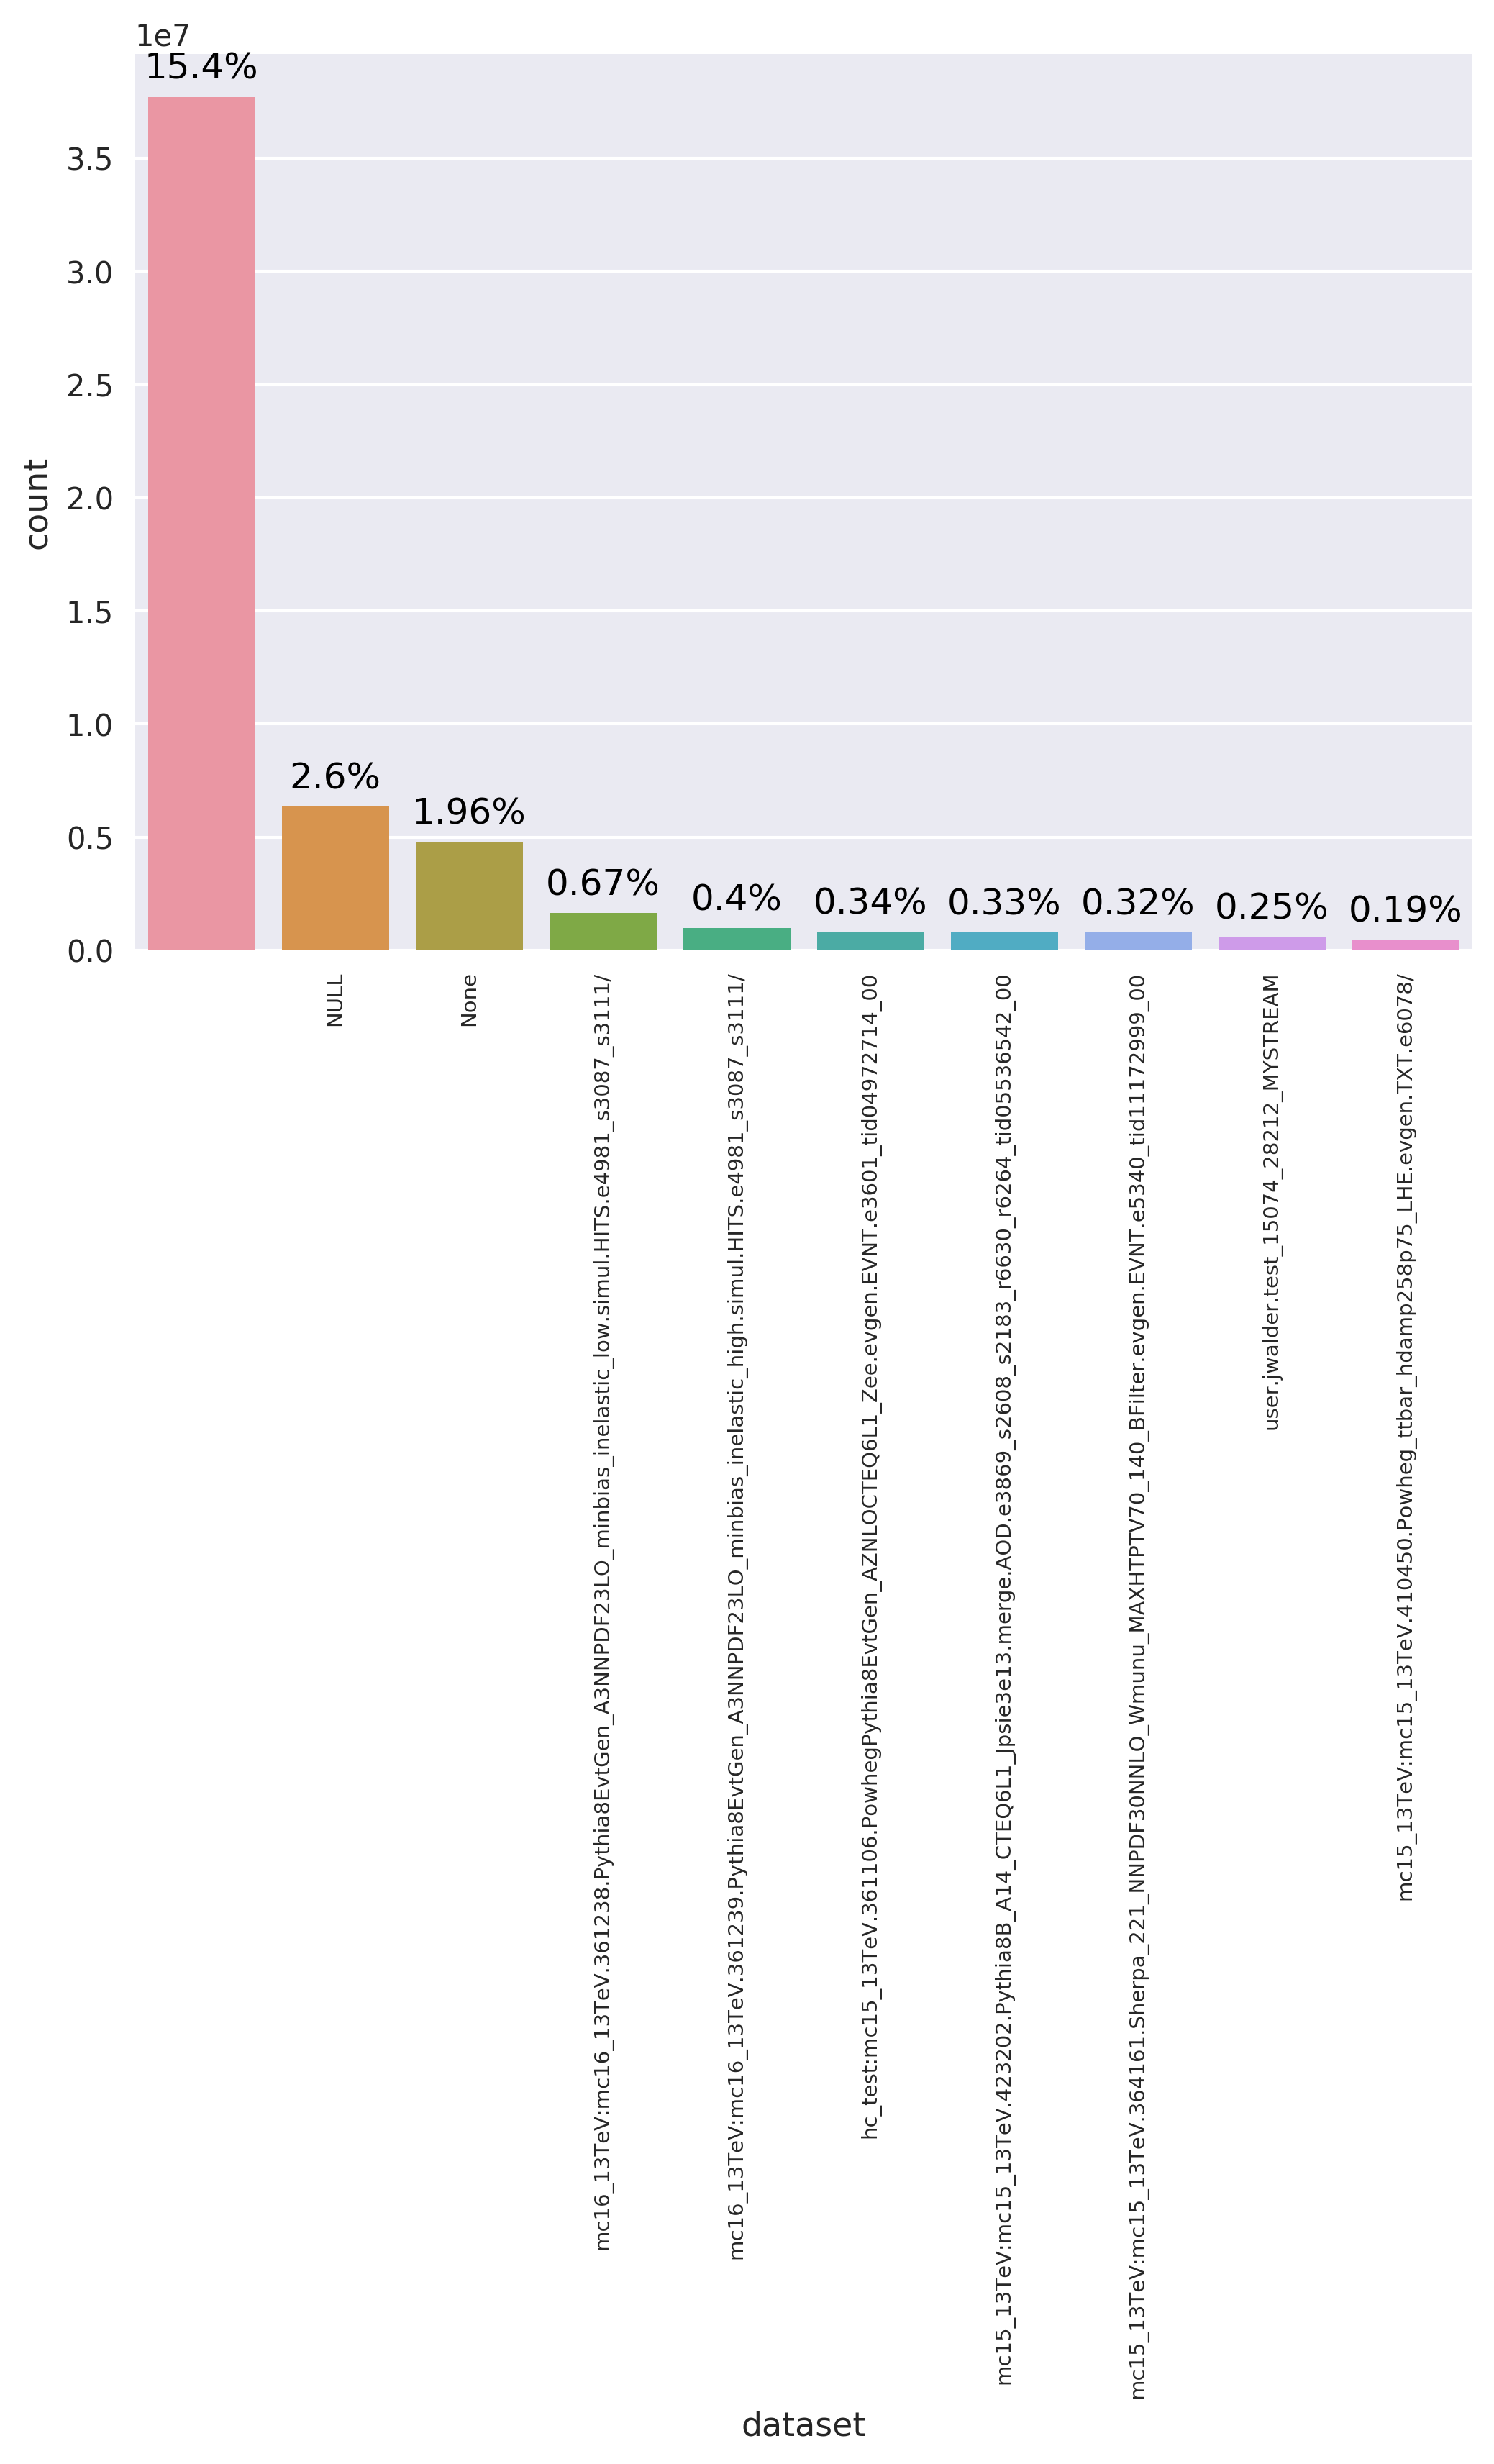

In [75]:
df_plot3['dataset'] = df_plot3.dataset.astype(str)

ax=sns.barplot(x="dataset", y="count", data=df_plot3, ci=None)

for index, row in df_plot3.iterrows():
    ax.text(row.name,row['count']+800000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=7)

In [15]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT dataset_version, COUNT(*) as count\
                   FROM traces \
                   GROUP BY dataset_version \
                   ORDER BY count DESC)")
df_plot4 = df_ps.limit(10).toPandas()
df_plot4

dataset_version     count  percentage
0  None                                          60324186  24.63     
1  deriv                                         10133728  4.14      
2  e4981_s3087_s3111/                            2657280   1.08      
3  physics_Main                                  2369528   0.97      
4  AOD                                           1111244   0.45      
5  daq                                           939319    0.38      
6  e3601_tid04972714_00                          823716    0.34      
7  e3869_s2608_s2183_r6630_r6264_tid05536542_00  796902    0.33      
8  e5340_tid11172999_00                          791669    0.32      
9  Athena                                        779592    0.32

[Text(0,0,u'None'),
 Text(0,0,u'deriv'),
 Text(0,0,u'e4981_s3087_s3111/'),
 Text(0,0,u'physics_Main'),
 Text(0,0,u'AOD'),
 Text(0,0,u'daq'),
 Text(0,0,u'e3601_tid04972714_00'),
 Text(0,0,u'e3869_s2608_s2183_r6630_r6264_tid05536542_00'),
 Text(0,0,u'e5340_tid11172999_00'),
 Text(0,0,u'Athena')]

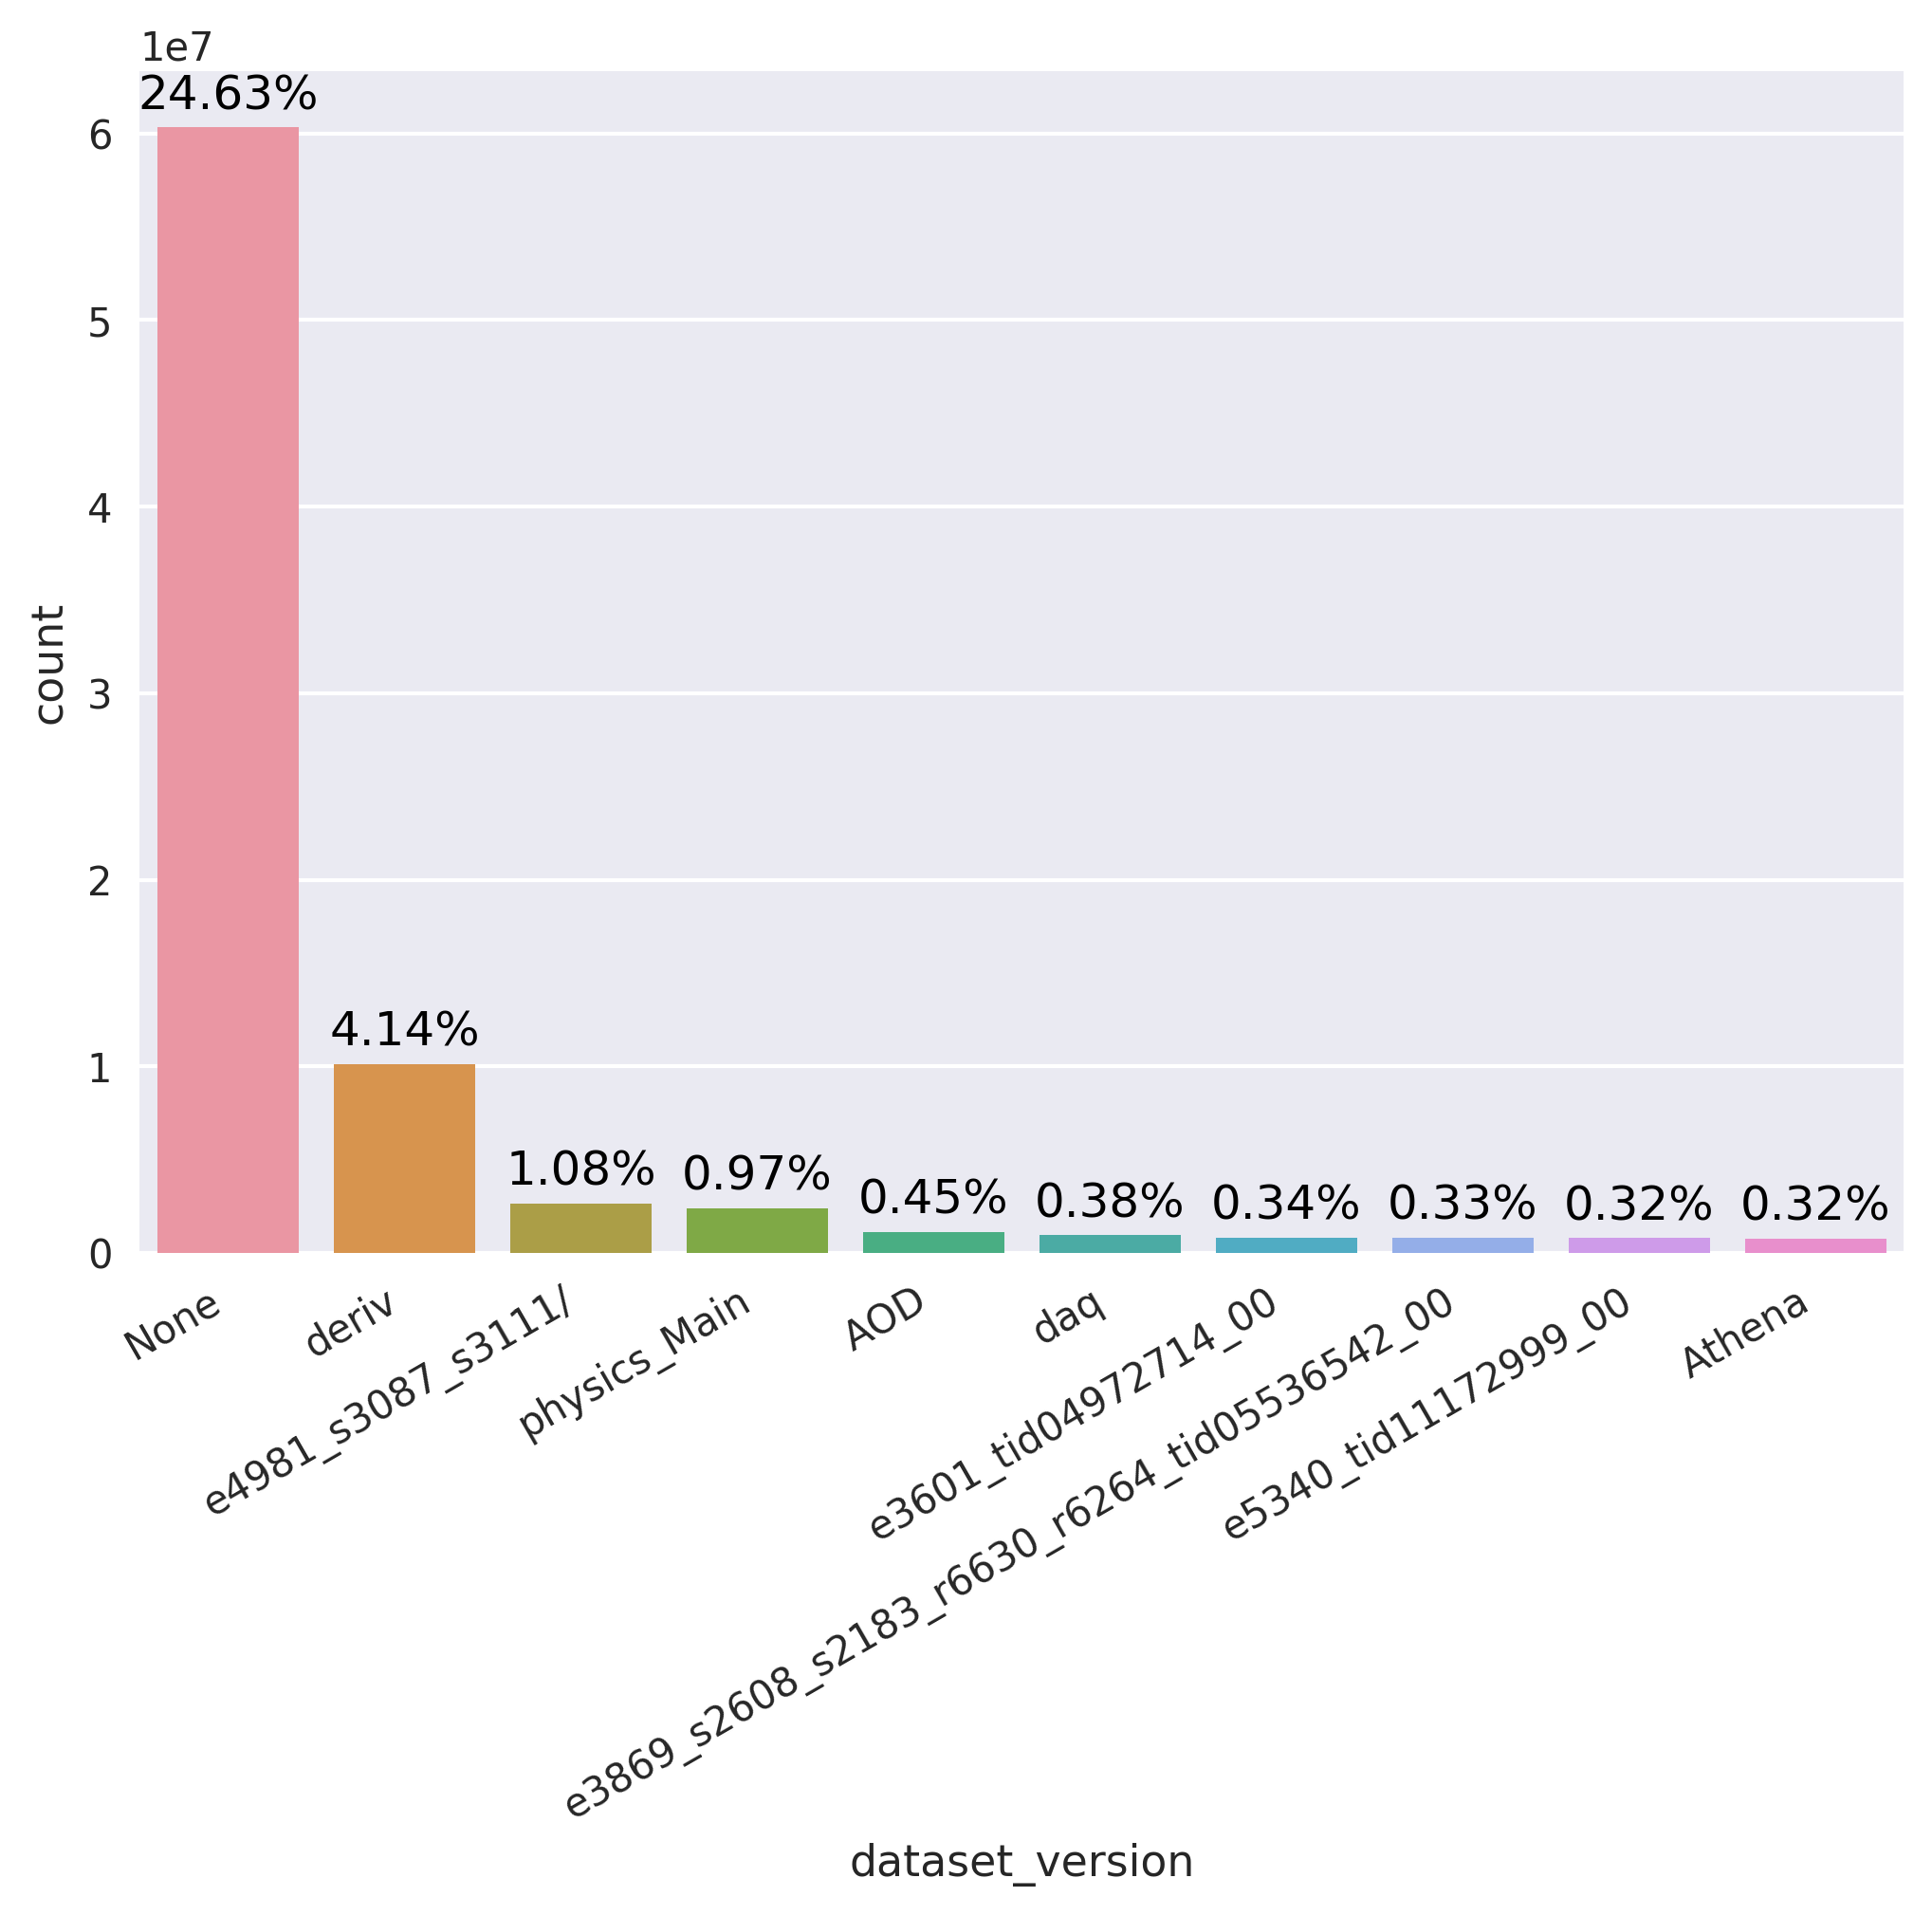

In [73]:
df_plot4['dataset_version'] = df_plot4.dataset_version.astype(str)

ax=sns.barplot(x="dataset_version", y="count", data=df_plot4, ci=None)

for index, row in df_plot4.iterrows():
    ax.text(row.name,row['count']+1000000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right")

In [17]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT datatype, COUNT(*) as count\
                   FROM traces \
                   GROUP BY datatype \
                   ORDER BY count DESC)")
df_plot5 = df_ps.limit(10).toPandas()
df_plot5

datatype     count  percentage
0  None          51185636  20.90     
1  EVNT          38149525  15.58     
2  AOD           31692154  12.94     
3  log           11222178  4.58      
4  HITS          9316815   3.80      
5  DAOD_TOPQ1    4543037   1.85      
6  physics_Main  3274077   1.34      
7  data16_13TeV  3199388   1.31      
8  data17_13TeV  2101651   0.86      
9  TXT           2013164   0.82

[Text(0,0,u'None'),
 Text(0,0,u'EVNT'),
 Text(0,0,u'AOD'),
 Text(0,0,u'log'),
 Text(0,0,u'HITS'),
 Text(0,0,u'DAOD_TOPQ1'),
 Text(0,0,u'physics_Main'),
 Text(0,0,u'data16_13TeV'),
 Text(0,0,u'data17_13TeV'),
 Text(0,0,u'TXT')]

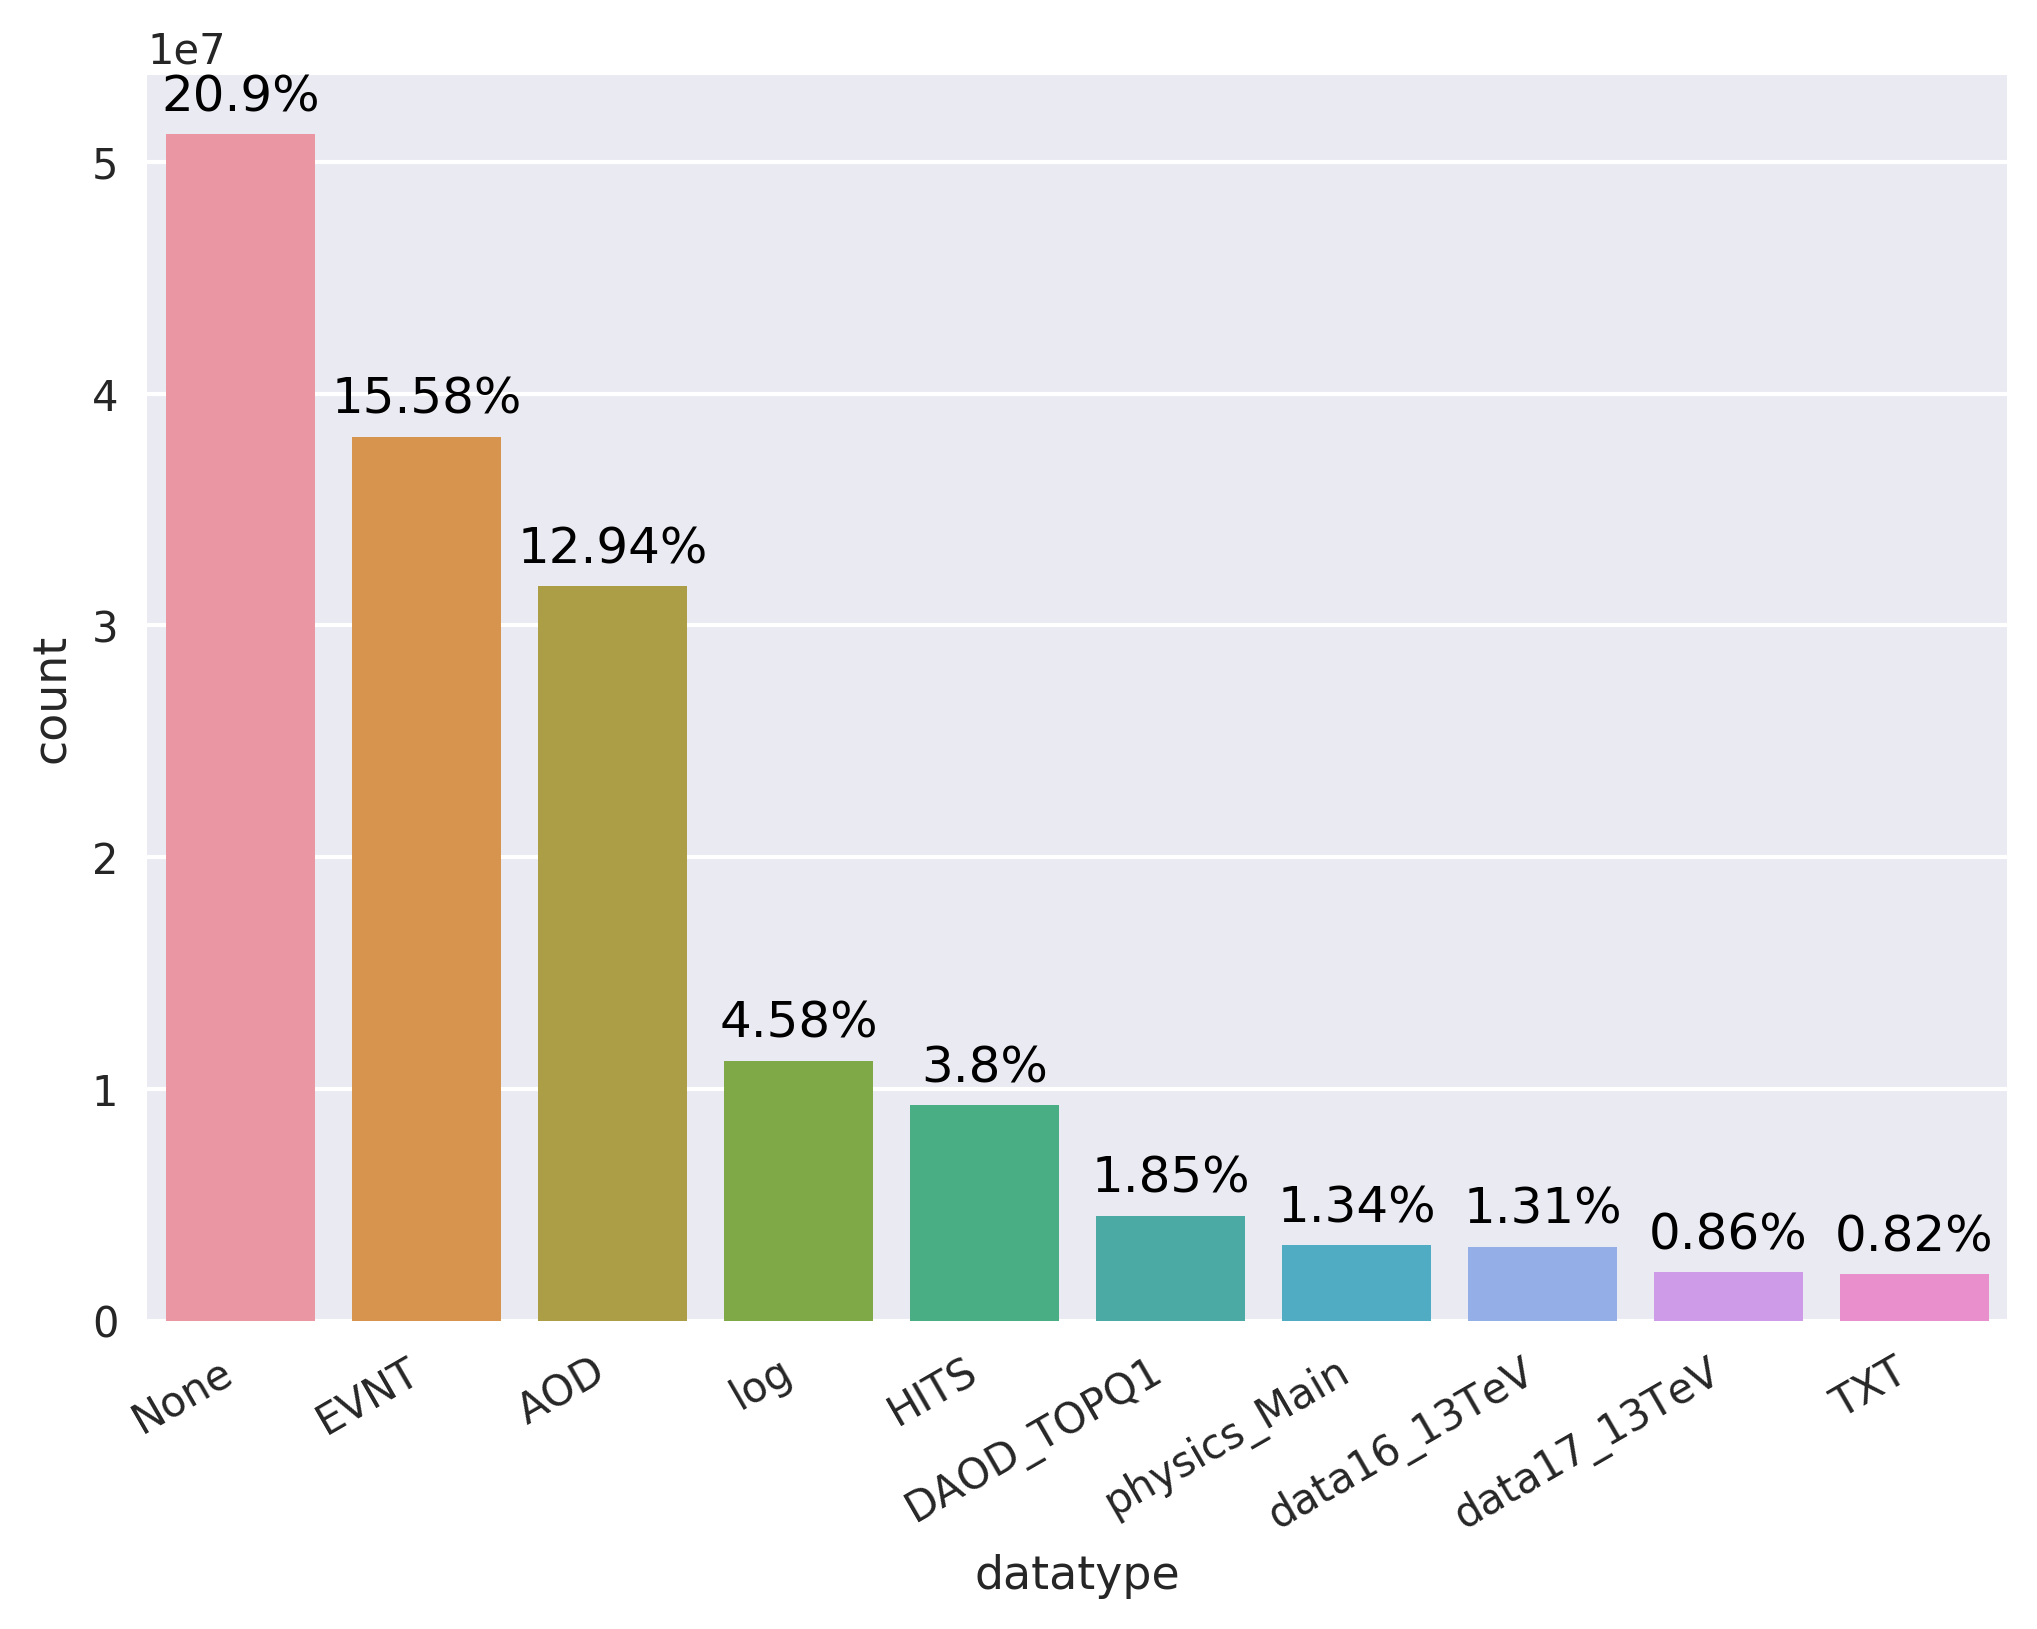

In [78]:
df_plot5['datatype'] = df_plot5.datatype.astype(str)

ax=sns.barplot(x="datatype", y="count", data=df_plot5, ci=None)

for index, row in df_plot5.iterrows():
    ax.text(row.name,row['count']+1000000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right")

In [19]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT eventType, COUNT(*) as count\
                   FROM traces \
                   GROUP BY eventType \
                   ORDER BY count DESC)")
df_plot6 = df_ps.limit(10).toPandas()
df_plot6

eventType     count  percentage
0  get_sm_a       86404641  35.28     
1  get_sm         50447719  20.60     
2  download       29380506  12.00     
3  put_sm         17246946  7.04      
4  upload         14591562  5.96      
5  put_sm_a       14104178  5.76      
6  put_sm_logs    11135310  4.55      
7  put_sm_logs_a  9385880   3.83      
8  put_es         4765952   1.95      
9  get_es         4688148   1.91

[Text(0,0,u'get_sm_a'),
 Text(0,0,u'get_sm'),
 Text(0,0,u'download'),
 Text(0,0,u'put_sm'),
 Text(0,0,u'upload'),
 Text(0,0,u'put_sm_a'),
 Text(0,0,u'put_sm_logs'),
 Text(0,0,u'put_sm_logs_a'),
 Text(0,0,u'put_es'),
 Text(0,0,u'get_es')]

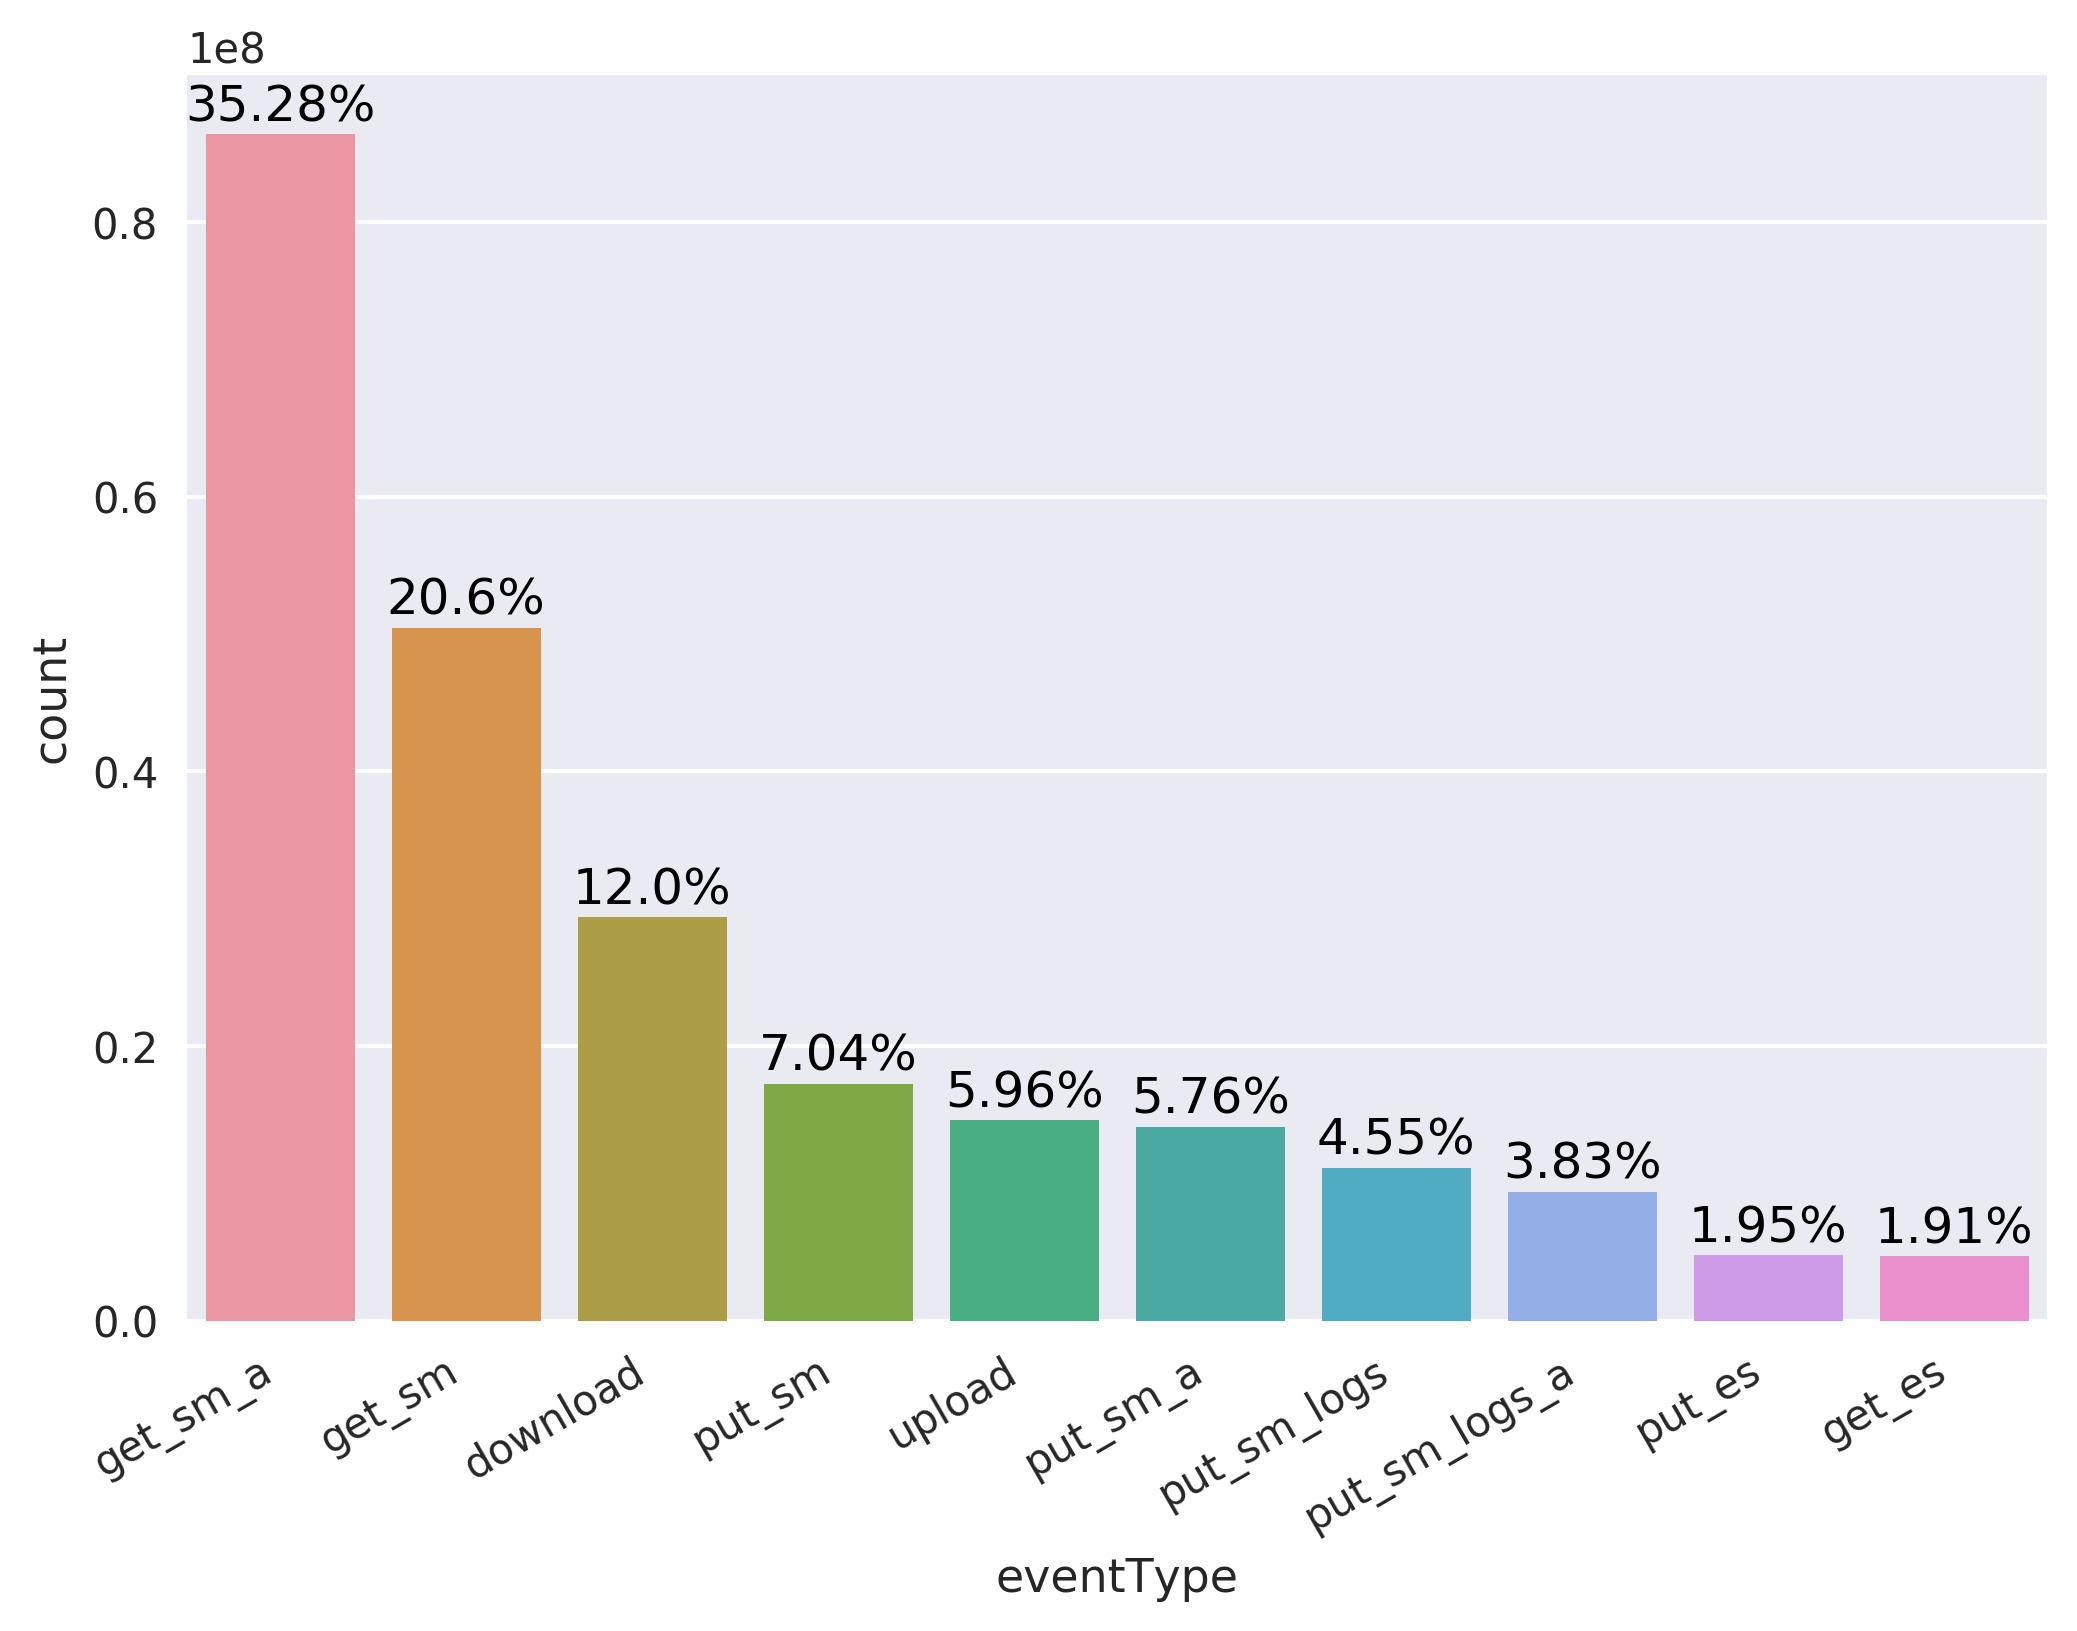

In [79]:
df_plot6['eventType'] = df_plot6.eventType.astype(str)

ax=sns.barplot(x="eventType", y="count", data=df_plot6, ci=None)

for index, row in df_plot6.iterrows():
    ax.text(row.name,row['count']+1000000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right")

In [21]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT filename, COUNT(*) as count\
                   FROM traces \
                   GROUP BY filename \
                   ORDER BY count DESC)")
df_plot7 = df_ps.limit(10).toPandas()
df_plot7

filename  \
0  None                                                                                                                           
1  AOD.05536542._000001.pool.root.1                                                                                               
2  group.phys-gener.madgraph5223p4.363608.MGPy8EG_N30NLO_Wenu_Ht140_280_13TeV.TXT.mc15_v1._00001.tar.gz                           
3  group.phys-gener.madgraph5232p1.363656.MGPy8EG_N30NLO_Wtaunu_Ht140_280_13TeV.TXT.mc15_v1._00001.tar.gz                         
4  panda.0410005528.528548.lib._13680459.13154307335.lib.tgz                                                                      
5  group.phys-gener.madgraph5232p1.363653.MGPy8EG_N30NLO_Wtaunu_Ht70_140_13TeV.TXT.mc15_v1._00001.tar.gz                          
6  group.phys-gener.madgraph5223p4.363629.MGPy8EG_N30NLO_Wmunu_Ht70_140_13TeV.TXT.mc15_v1._00001.tar.gz                           
7  group.phys-gener.powheg_V2.345054.WplvH125J_MINLO_VpT_13TeV.TXT.mc15_v1._00001.tar.gz                                          
8  group.phys-gener.madgraph5223p4.363605.MGPy8EG_N30NLO_Wenu_Ht70_140_13TeV.TXT.mc15_v1._00001.tar.gz                            
9  group.phys-gener.sherpa020201.364162.Sherpa_221_NNPDF30NNLO_Wmunu_MAXHTPTV140_280_CVetoBVeto_13TeV.TXT.mc15_v1._00001.tar.gz   

      count  percentage  
0  14971037  6.11        
1  813475    0.33        
2  228362    0.09        
3  202384    0.08        
4  193882    0.08        
5  183743    0.08        
6  169811    0.07        
7  126113    0.05        
8  125411    0.05        
9  114737    0.05

[Text(0,0,u'None'),
 Text(0,0,u'AOD.05536542._000001.pool.root.1'),
 Text(0,0,u'group.phys-gener.madgraph5223p4.363608.MGPy8EG_N30NLO_Wenu_Ht140_280_13TeV.TXT.mc15_v1._00001.tar.gz'),
 Text(0,0,u'group.phys-gener.madgraph5232p1.363656.MGPy8EG_N30NLO_Wtaunu_Ht140_280_13TeV.TXT.mc15_v1._00001.tar.gz'),
 Text(0,0,u'panda.0410005528.528548.lib._13680459.13154307335.lib.tgz'),
 Text(0,0,u'group.phys-gener.madgraph5232p1.363653.MGPy8EG_N30NLO_Wtaunu_Ht70_140_13TeV.TXT.mc15_v1._00001.tar.gz'),
 Text(0,0,u'group.phys-gener.madgraph5223p4.363629.MGPy8EG_N30NLO_Wmunu_Ht70_140_13TeV.TXT.mc15_v1._00001.tar.gz'),
 Text(0,0,u'group.phys-gener.powheg_V2.345054.WplvH125J_MINLO_VpT_13TeV.TXT.mc15_v1._00001.tar.gz'),
 Text(0,0,u'group.phys-gener.madgraph5223p4.363605.MGPy8EG_N30NLO_Wenu_Ht70_140_13TeV.TXT.mc15_v1._00001.tar.gz'),
 Text(0,0,u'group.phys-gener.sherpa020201.364162.Sherpa_221_NNPDF30NNLO_Wmunu_MAXHTPTV140_280_CVetoBVeto_13TeV.TXT.mc15_v1._00001.tar.gz')]

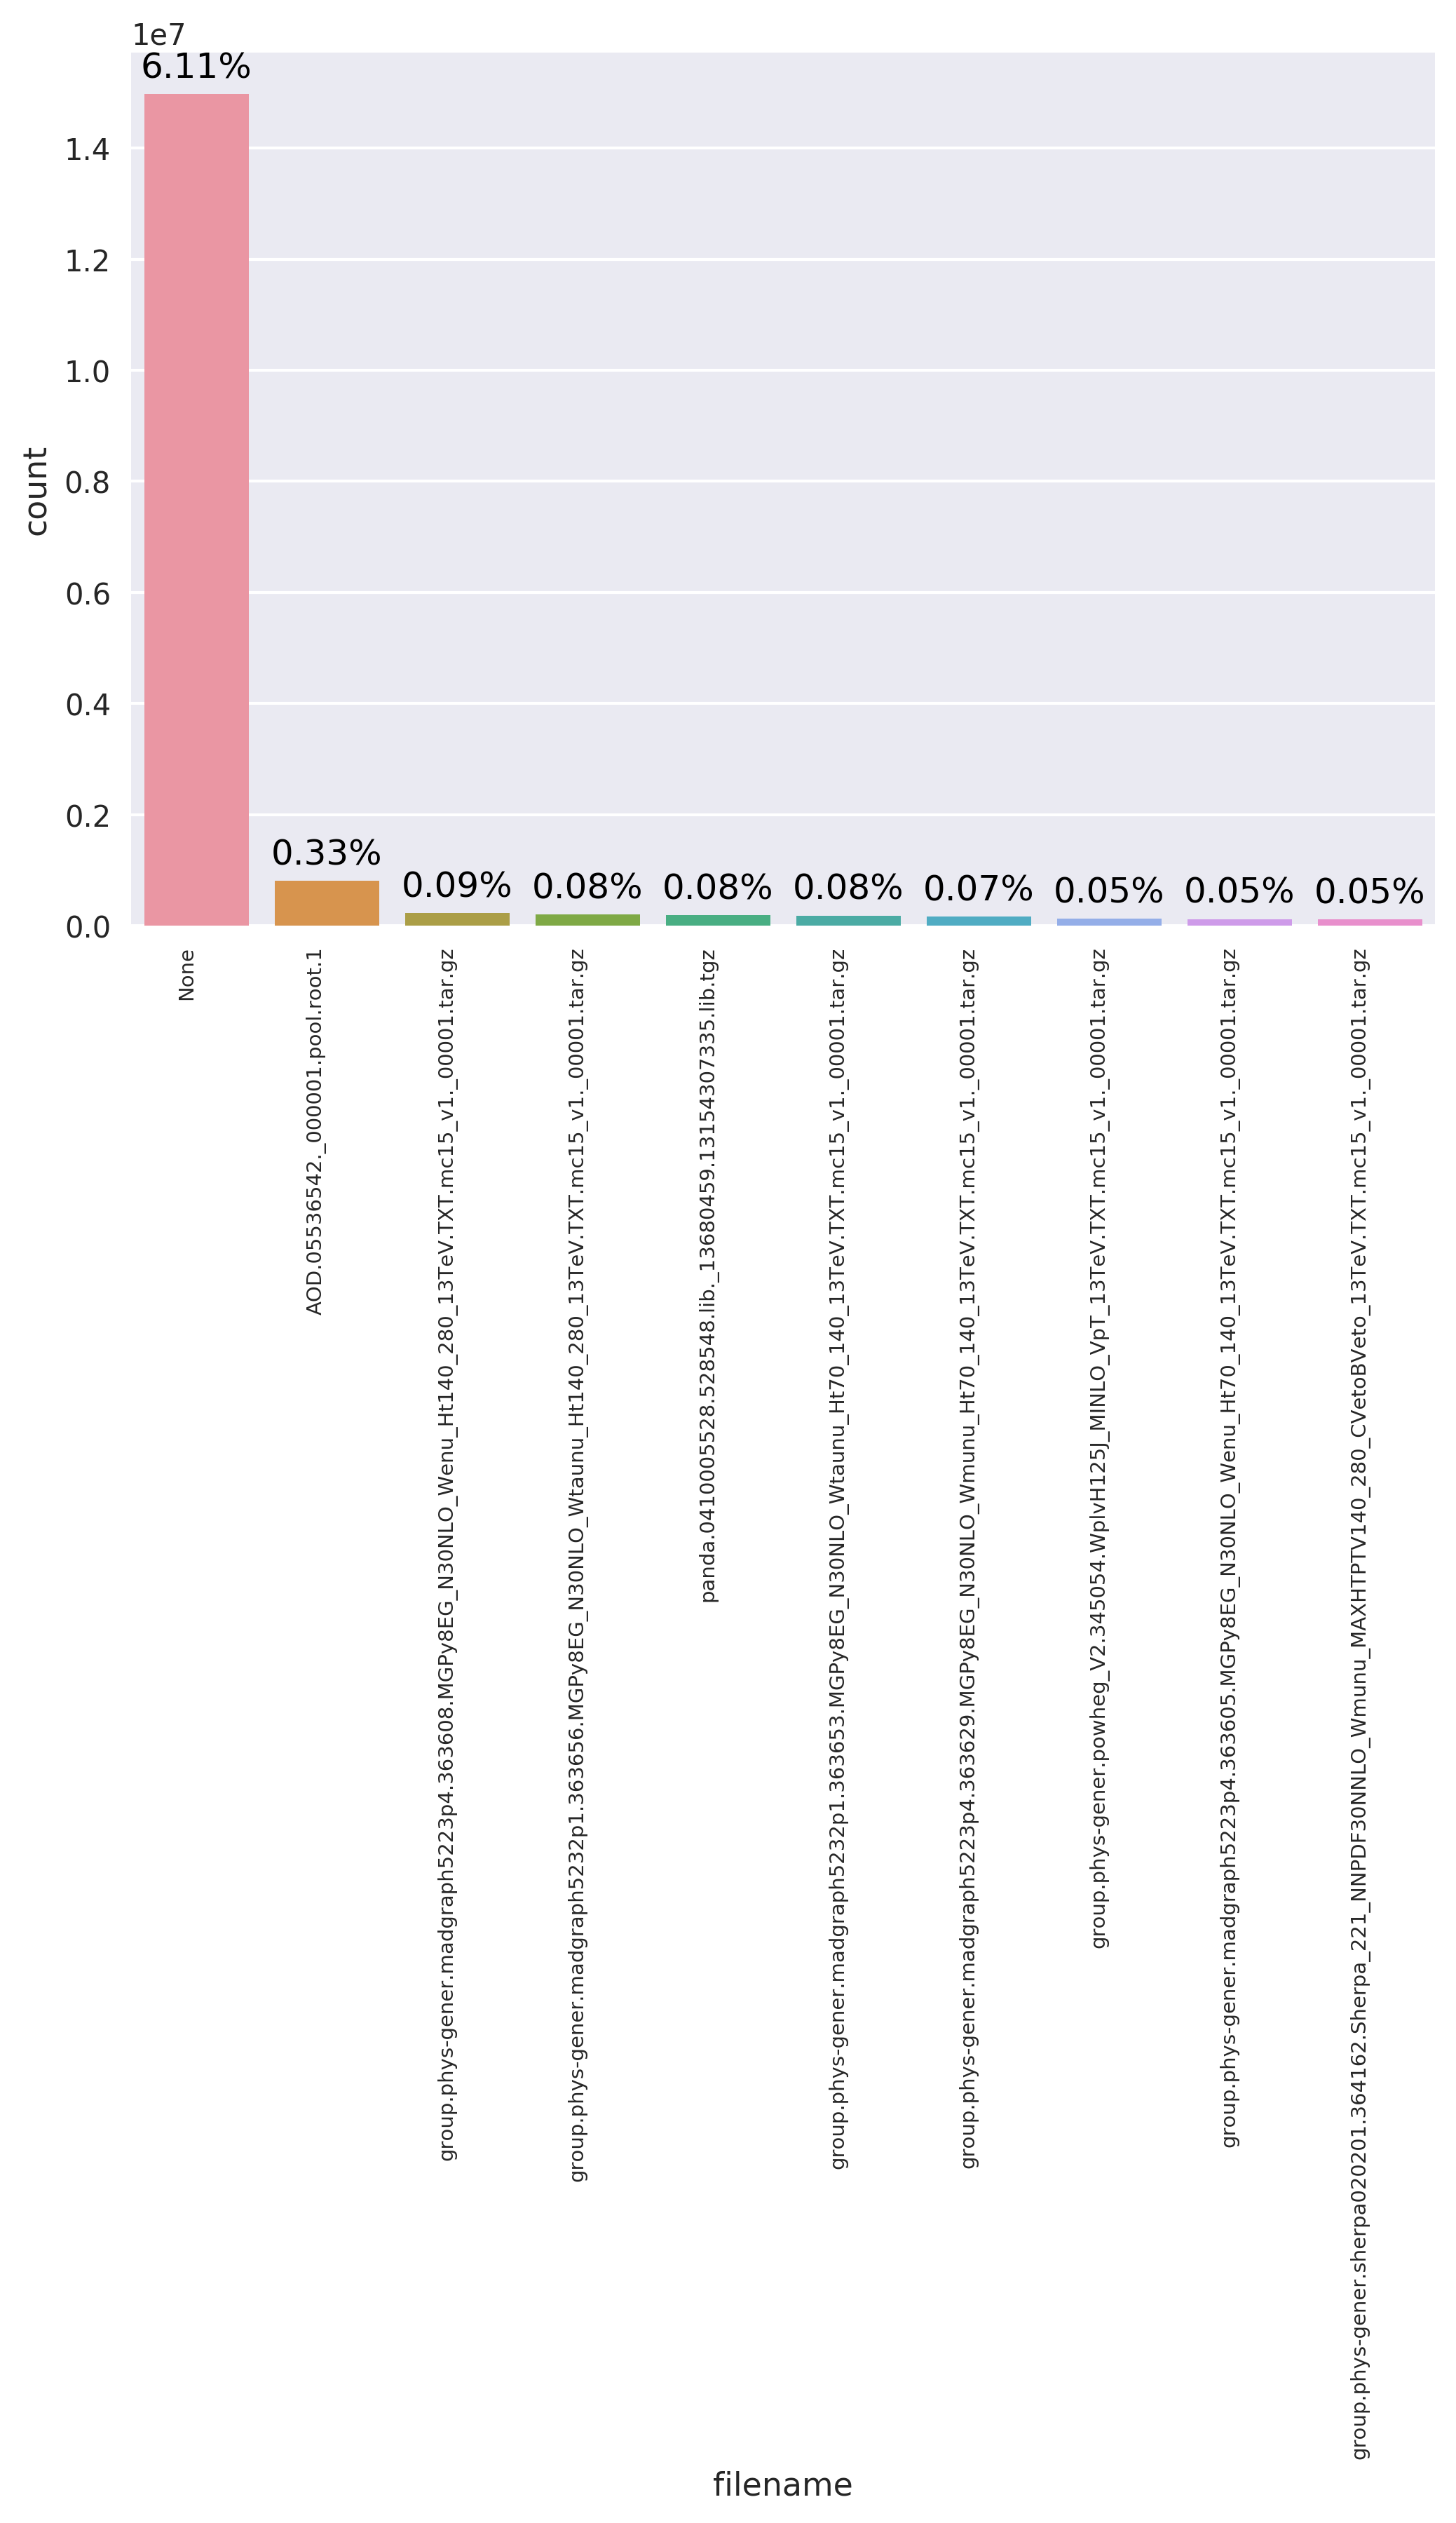

In [81]:
df_plot7['filename'] = df_plot7.filename.astype(str)

ax=sns.barplot(x="filename", y="count", data=df_plot7, ci=None)

for index, row in df_plot7.iterrows():
    ax.text(row.name,row['count']+300000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=7,ha="right")

In [23]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT prod_step, COUNT(*) as count\
                   FROM traces \
                   GROUP BY prod_step \
                   ORDER BY count DESC)")
df_plot8 = df_ps.limit(10).toPandas()
df_plot8

prod_step     count  percentage
0  None          50194456  20.49     
1  evgen         40526975  16.55     
2  merge         37820434  15.44     
3  deriv         25657103  10.48     
4  simul         11187891  4.57      
5  recon         9885688   4.04      
6  lib           7335126   2.99      
7  eschanet      1685983   0.69      
8  sim           1441179   0.59      
9  sherpa020201  1329589   0.54

[Text(0,0,u'None'),
 Text(0,0,u'evgen'),
 Text(0,0,u'merge'),
 Text(0,0,u'deriv'),
 Text(0,0,u'simul'),
 Text(0,0,u'recon'),
 Text(0,0,u'lib'),
 Text(0,0,u'eschanet'),
 Text(0,0,u'sim'),
 Text(0,0,u'sherpa020201')]

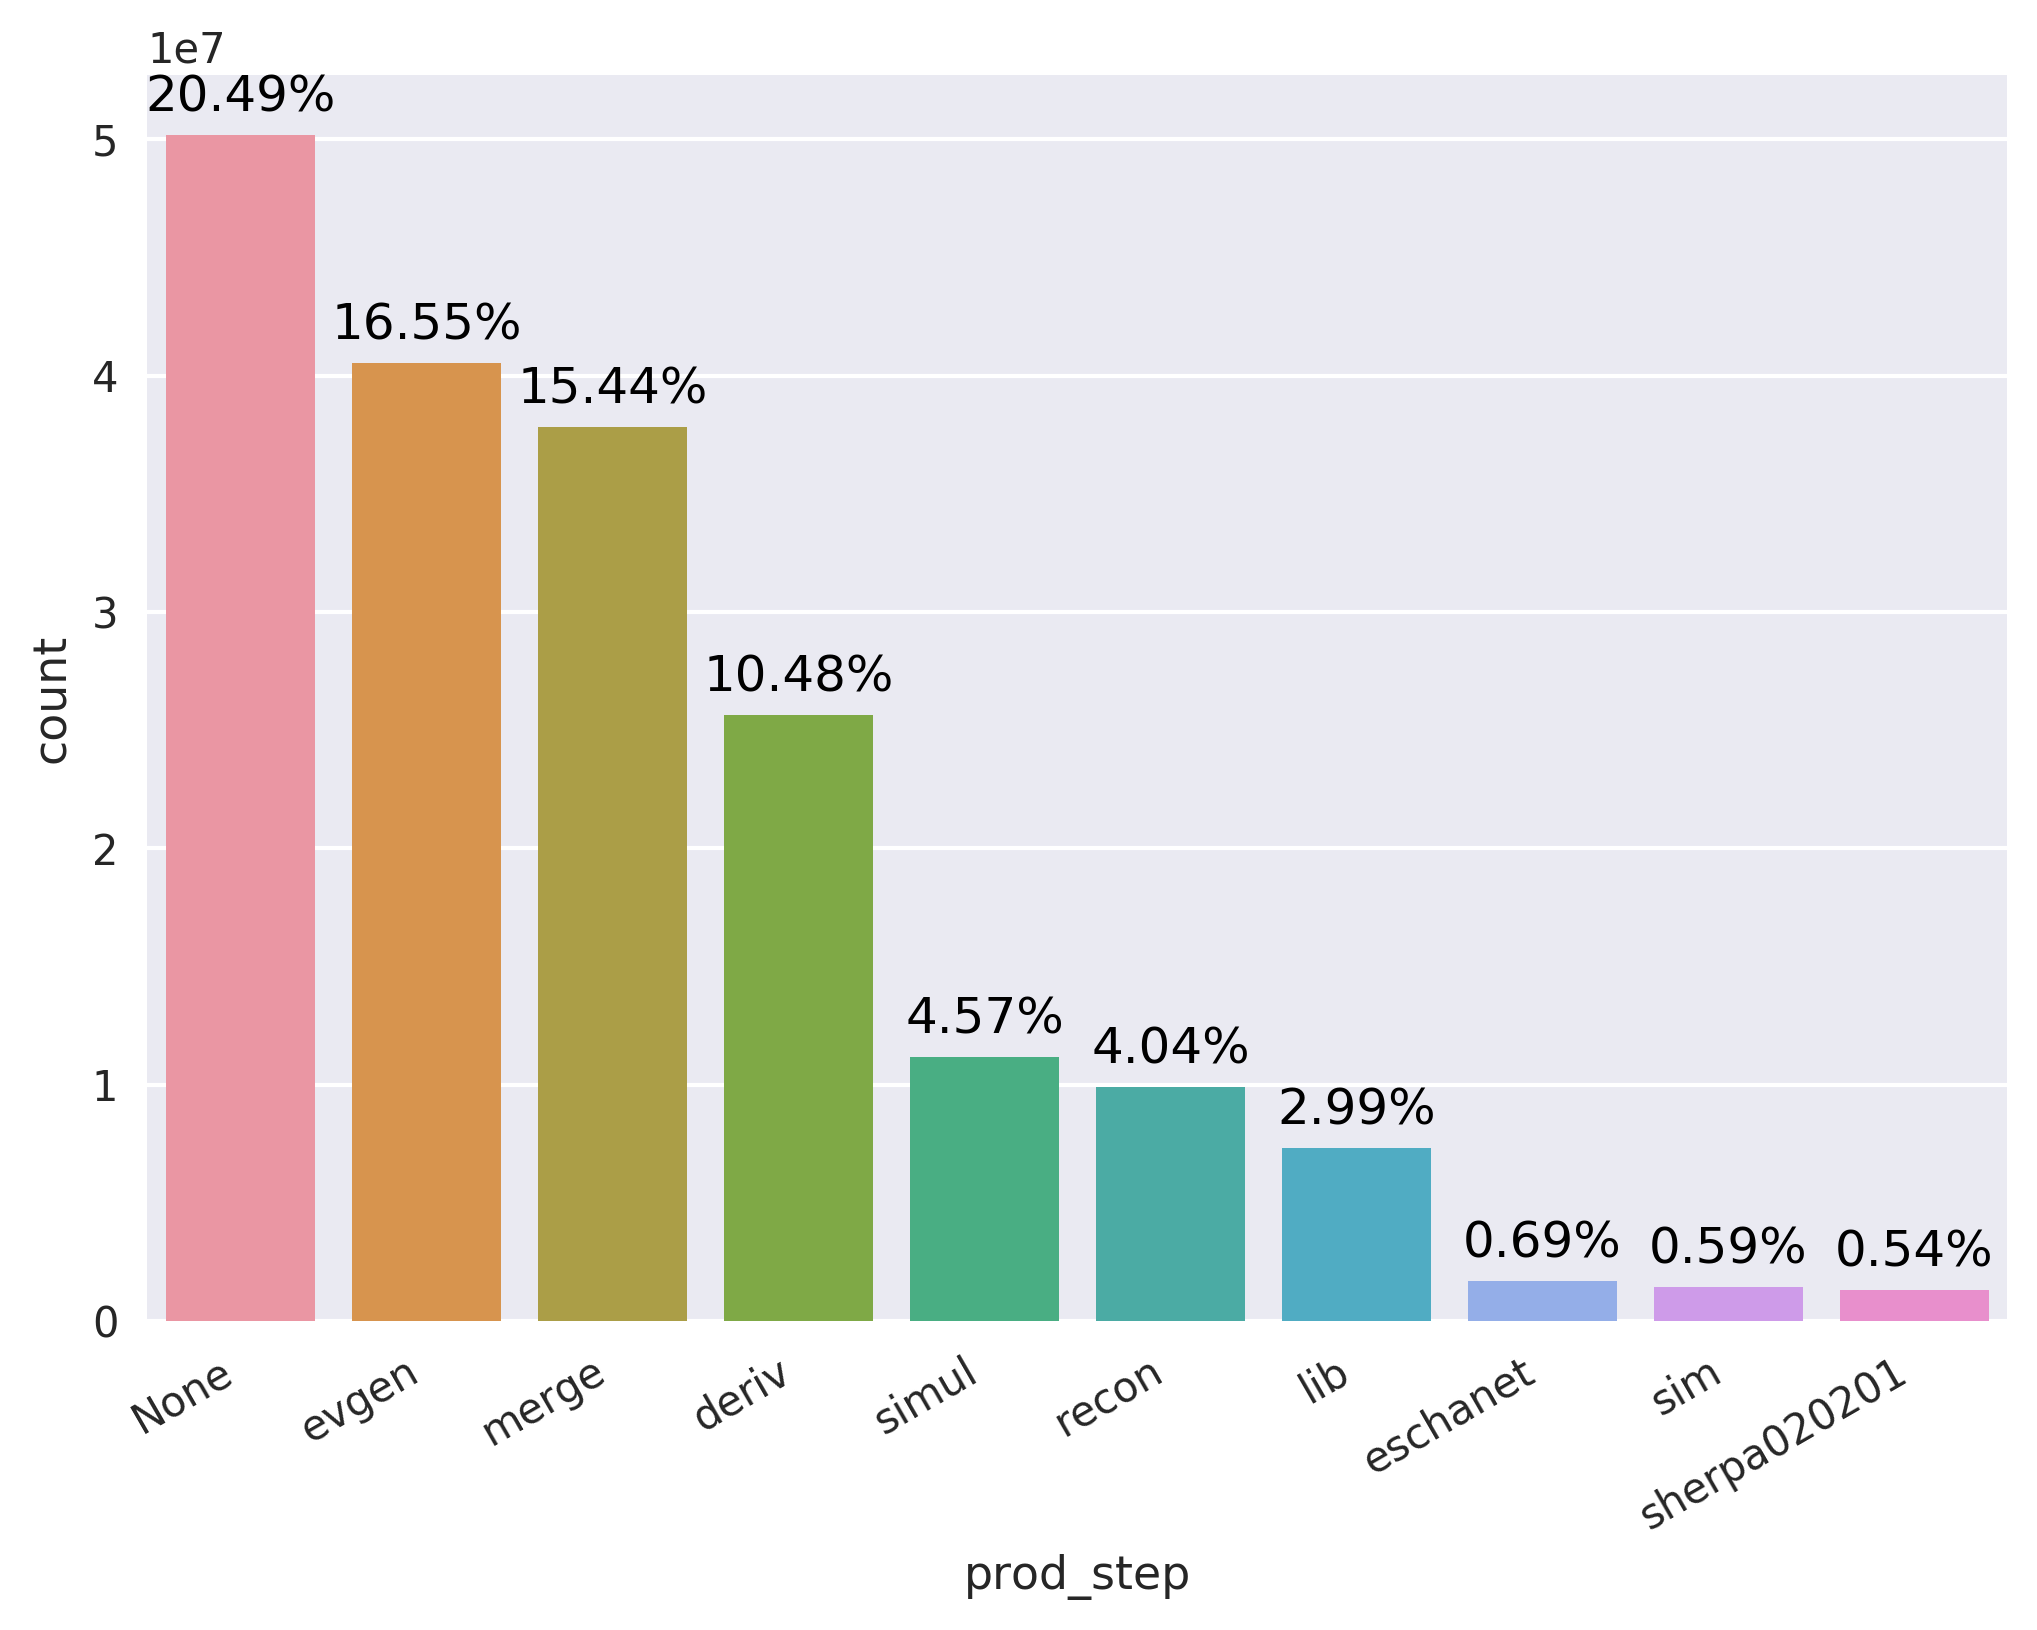

In [82]:
df_plot8['prod_step'] = df_plot8.prod_step.astype(str)

ax=sns.barplot(x="prod_step", y="count", data=df_plot8, ci=None)

for index, row in df_plot8.iterrows():
    ax.text(row.name,row['count']+1000000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right")

In [25]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT project, COUNT(*) as count\
                   FROM traces \
                   GROUP BY project \
                   ORDER BY count DESC)")
df_plot9 = df_ps.limit(10).toPandas()
df_plot9

project     count  percentage
0  panda                      42291072  17.27     
1                             37719600  15.40     
2  mc15_13TeV:mc15_13TeV      30550574  12.47     
3  data17_13TeV:data17_13TeV  21843848  8.92      
4  mc16_13TeV:mc16_13TeV      20838296  8.51      
5  user                       16472327  6.73      
6  data16_13TeV:data16_13TeV  15080686  6.16      
7  mc15_13TeV                 11131494  4.54      
8  mc16_13TeV                 10738956  4.38      
9  group                      8708220   3.56

[Text(0,0,u'panda'),
 Text(0,0,u''),
 Text(0,0,u'mc15_13TeV:mc15_13TeV'),
 Text(0,0,u'data17_13TeV:data17_13TeV'),
 Text(0,0,u'mc16_13TeV:mc16_13TeV'),
 Text(0,0,u'user'),
 Text(0,0,u'data16_13TeV:data16_13TeV'),
 Text(0,0,u'mc15_13TeV'),
 Text(0,0,u'mc16_13TeV'),
 Text(0,0,u'group')]

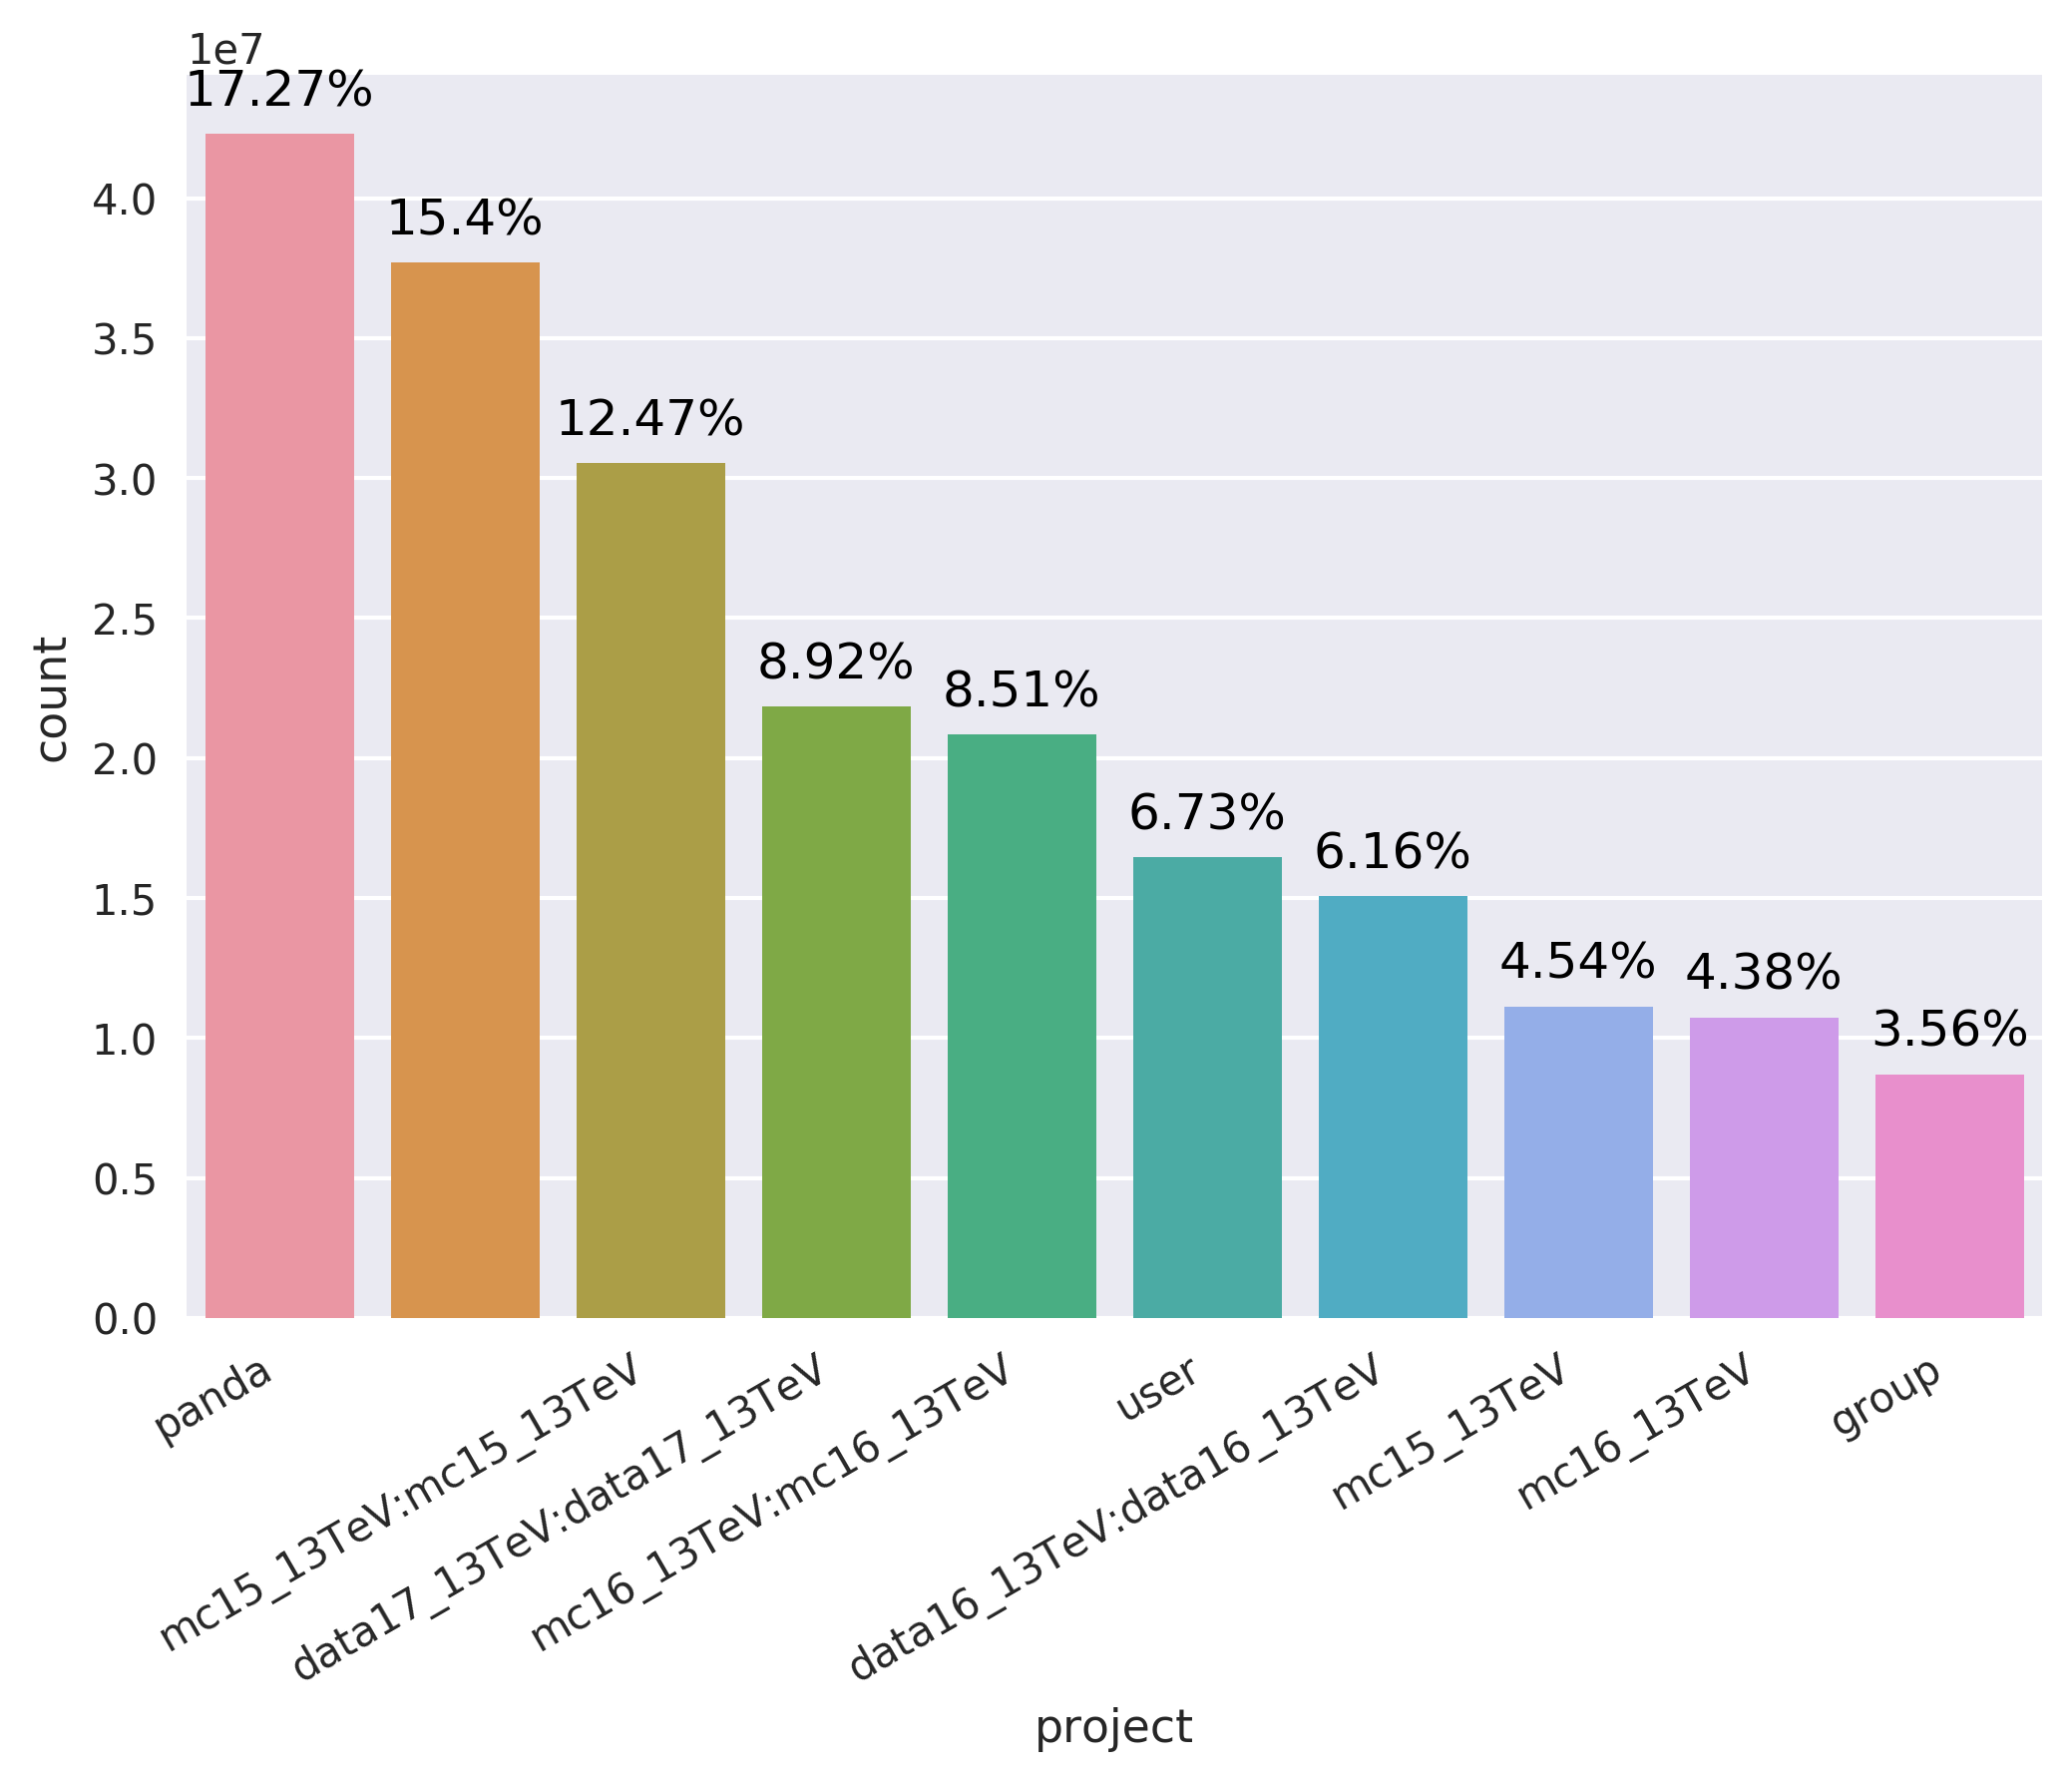

In [83]:
df_plot9['project'] = df_plot9.project.astype(str)

ax=sns.barplot(x="project", y="count", data=df_plot9, ci=None)

for index, row in df_plot9.iterrows():
    ax.text(row.name,row['count']+1000000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right")

In [27]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT stream_name, COUNT(*) as count\
                   FROM traces \
                   GROUP BY stream_name \
                   ORDER BY count DESC)")
df_plot10 = df_ps.limit(10).toPandas()
df_plot10

stream_name     count  percentage
0  None                                             49032087  20.02     
1  physics_Main                                     44092060  18.00     
2  user                                             23104761  9.43      
3  mc16_13TeV                                       10830262  4.42      
4  phys-gener                                       2904604   1.19      
5  group                                            1946002   0.79      
6  Pythia8EvtGen_A3NNPDF23LO_minbias_inelastic_low  1803905   0.74      
7  PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee             1731924   0.71      
8  okumura                                          1439828   0.59      
9  atlas                                            1414786   0.58

[Text(0,0,u'None'),
 Text(0,0,u'physics_Main'),
 Text(0,0,u'user'),
 Text(0,0,u'mc16_13TeV'),
 Text(0,0,u'phys-gener'),
 Text(0,0,u'group'),
 Text(0,0,u'Pythia8EvtGen_A3NNPDF23LO_minbias_inelastic_low'),
 Text(0,0,u'PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee'),
 Text(0,0,u'okumura'),
 Text(0,0,u'atlas')]

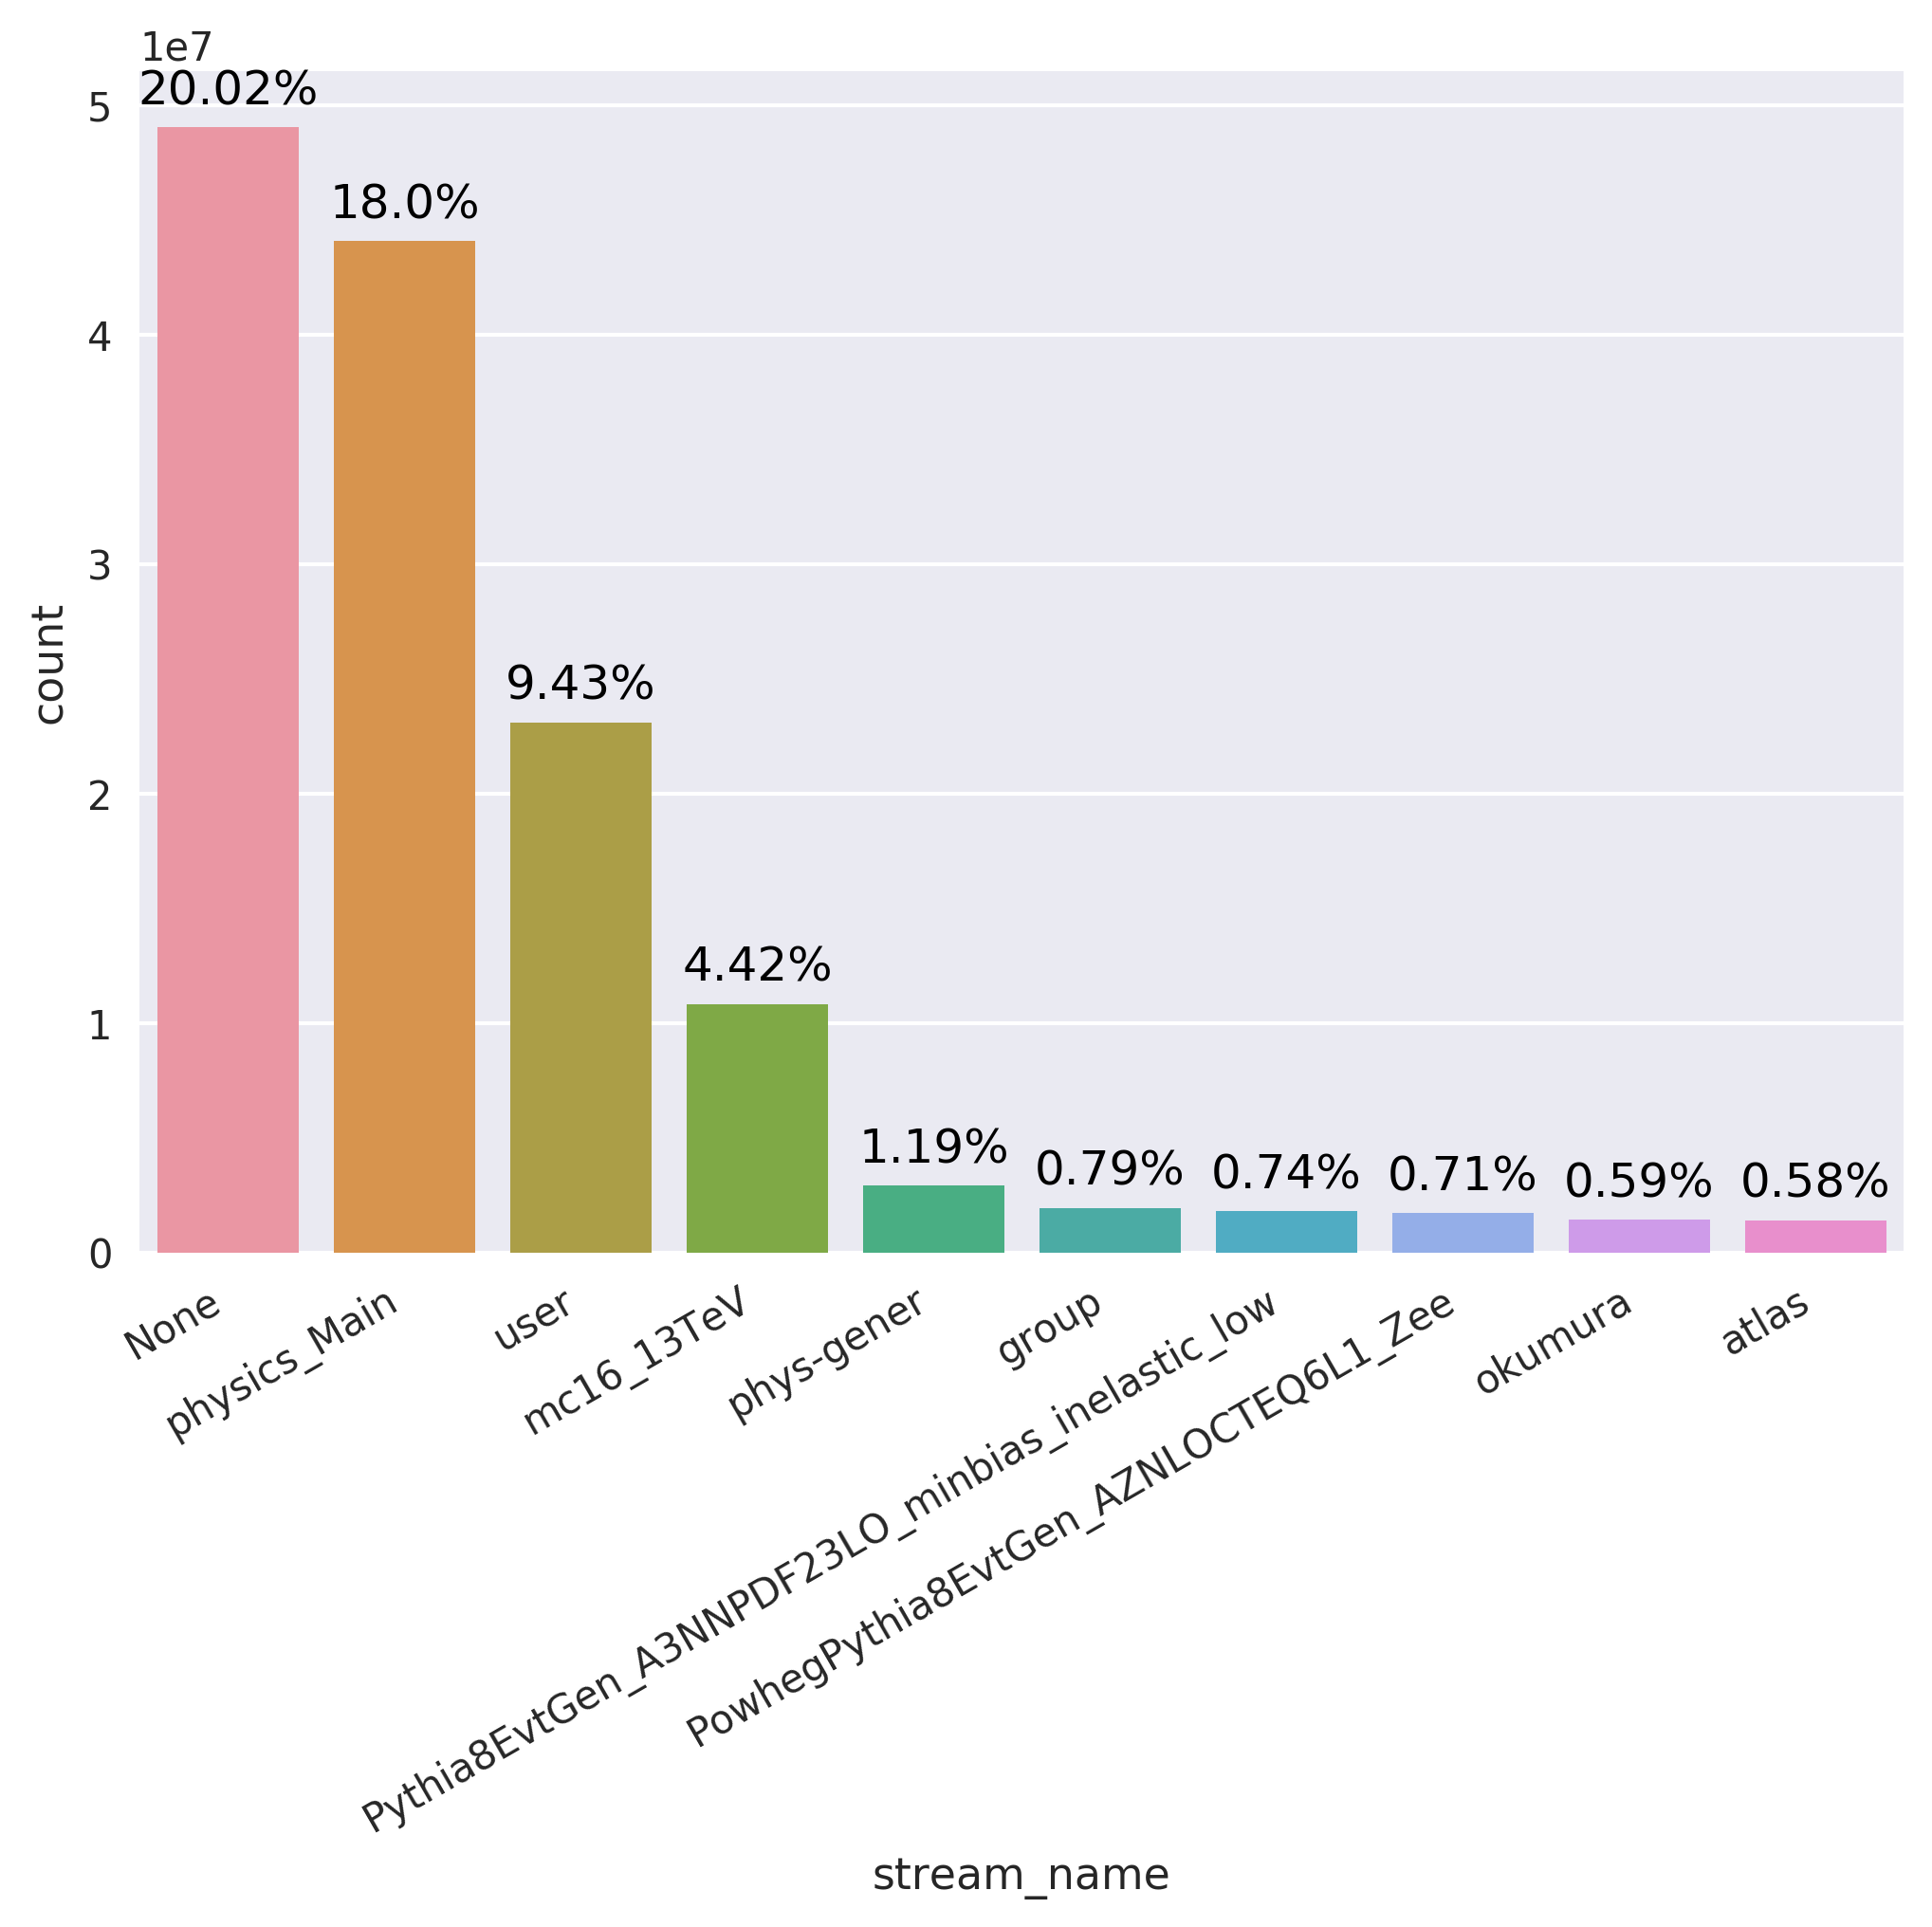

In [84]:
df_plot10['stream_name'] = df_plot10.stream_name.astype(str)

ax=sns.barplot(x="stream_name", y="count", data=df_plot10, ci=None)

for index, row in df_plot10.iterrows():
    ax.text(row.name,row['count']+1000000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right")

In [29]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT traceTimeentryUnix, COUNT(*) as count\
                   FROM traces \
                   GROUP BY traceTimeentryUnix \
                   ORDER BY count DESC)")
df_plot11 = df_ps.limit(10).toPandas()
df_plot11

traceTimeentryUnix  count  percentage
0  1.524270e+09        4      0.0       
1  1.524270e+09        4      0.0       
2  1.524270e+09        4      0.0       
3  1.524270e+09        4      0.0       
4  1.524270e+09        4      0.0       
5  1.524270e+09        4      0.0       
6  1.524270e+09        4      0.0       
7  1.524270e+09        4      0.0       
8  1.524270e+09        4      0.0       
9  1.524270e+09        4      0.0

In [30]:
#df_plot['traceTimeentryUnix'] = df_plot.traceTimeentryUnix.astype(str)

#ax=sns.barplot(x="traceTimeentryUnix", y="count", data=df_plot, ci=None)

#for index, row in df_plot.iterrows():
#    ax.text(row.name,row['count']+3000000, "%s%%" % row.percentage , color='black', ha="center")

#ax.set(ylabel='count')

In [31]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT uuid, COUNT(*) as count\
                   FROM traces \
                   GROUP BY uuid \
                   ORDER BY count DESC)")
df_plot12 = df_ps.limit(10).toPandas()
df_plot12

uuid   count  percentage
0  04f6d2a2a201b7b6b2cb5893d8622ab3  514183  0.21      
1  b28dd24eb58d420dbb29ce250701ca08  76912   0.03      
2  e18c7ea9b5e049668e9fce874706b440  67208   0.03      
3  a673bc10b74546dca33de7d36eb54239  57505   0.02      
4  dda87a65787147a9ba32f15f00ff6082  52684   0.02      
5  d58c13d67d6b465dbe1c439be51c35a5  41061   0.02      
6  48ef59281b59420b9416b6284890aaae  40563   0.02      
7  13be6e6be40a4da6873b1ff339deb4a1  35292   0.01      
8  38abe9fd9e4843e8bcae0c2e8b5161b1  35292   0.01      
9  f016a5cd291140cbbb4e5821a38efa01  32629   0.01

[Text(0,0,u'04f6d2a2a201b7b6b2cb5893d8622ab3'),
 Text(0,0,u'b28dd24eb58d420dbb29ce250701ca08'),
 Text(0,0,u'e18c7ea9b5e049668e9fce874706b440'),
 Text(0,0,u'a673bc10b74546dca33de7d36eb54239'),
 Text(0,0,u'dda87a65787147a9ba32f15f00ff6082'),
 Text(0,0,u'd58c13d67d6b465dbe1c439be51c35a5'),
 Text(0,0,u'48ef59281b59420b9416b6284890aaae'),
 Text(0,0,u'13be6e6be40a4da6873b1ff339deb4a1'),
 Text(0,0,u'38abe9fd9e4843e8bcae0c2e8b5161b1'),
 Text(0,0,u'f016a5cd291140cbbb4e5821a38efa01')]

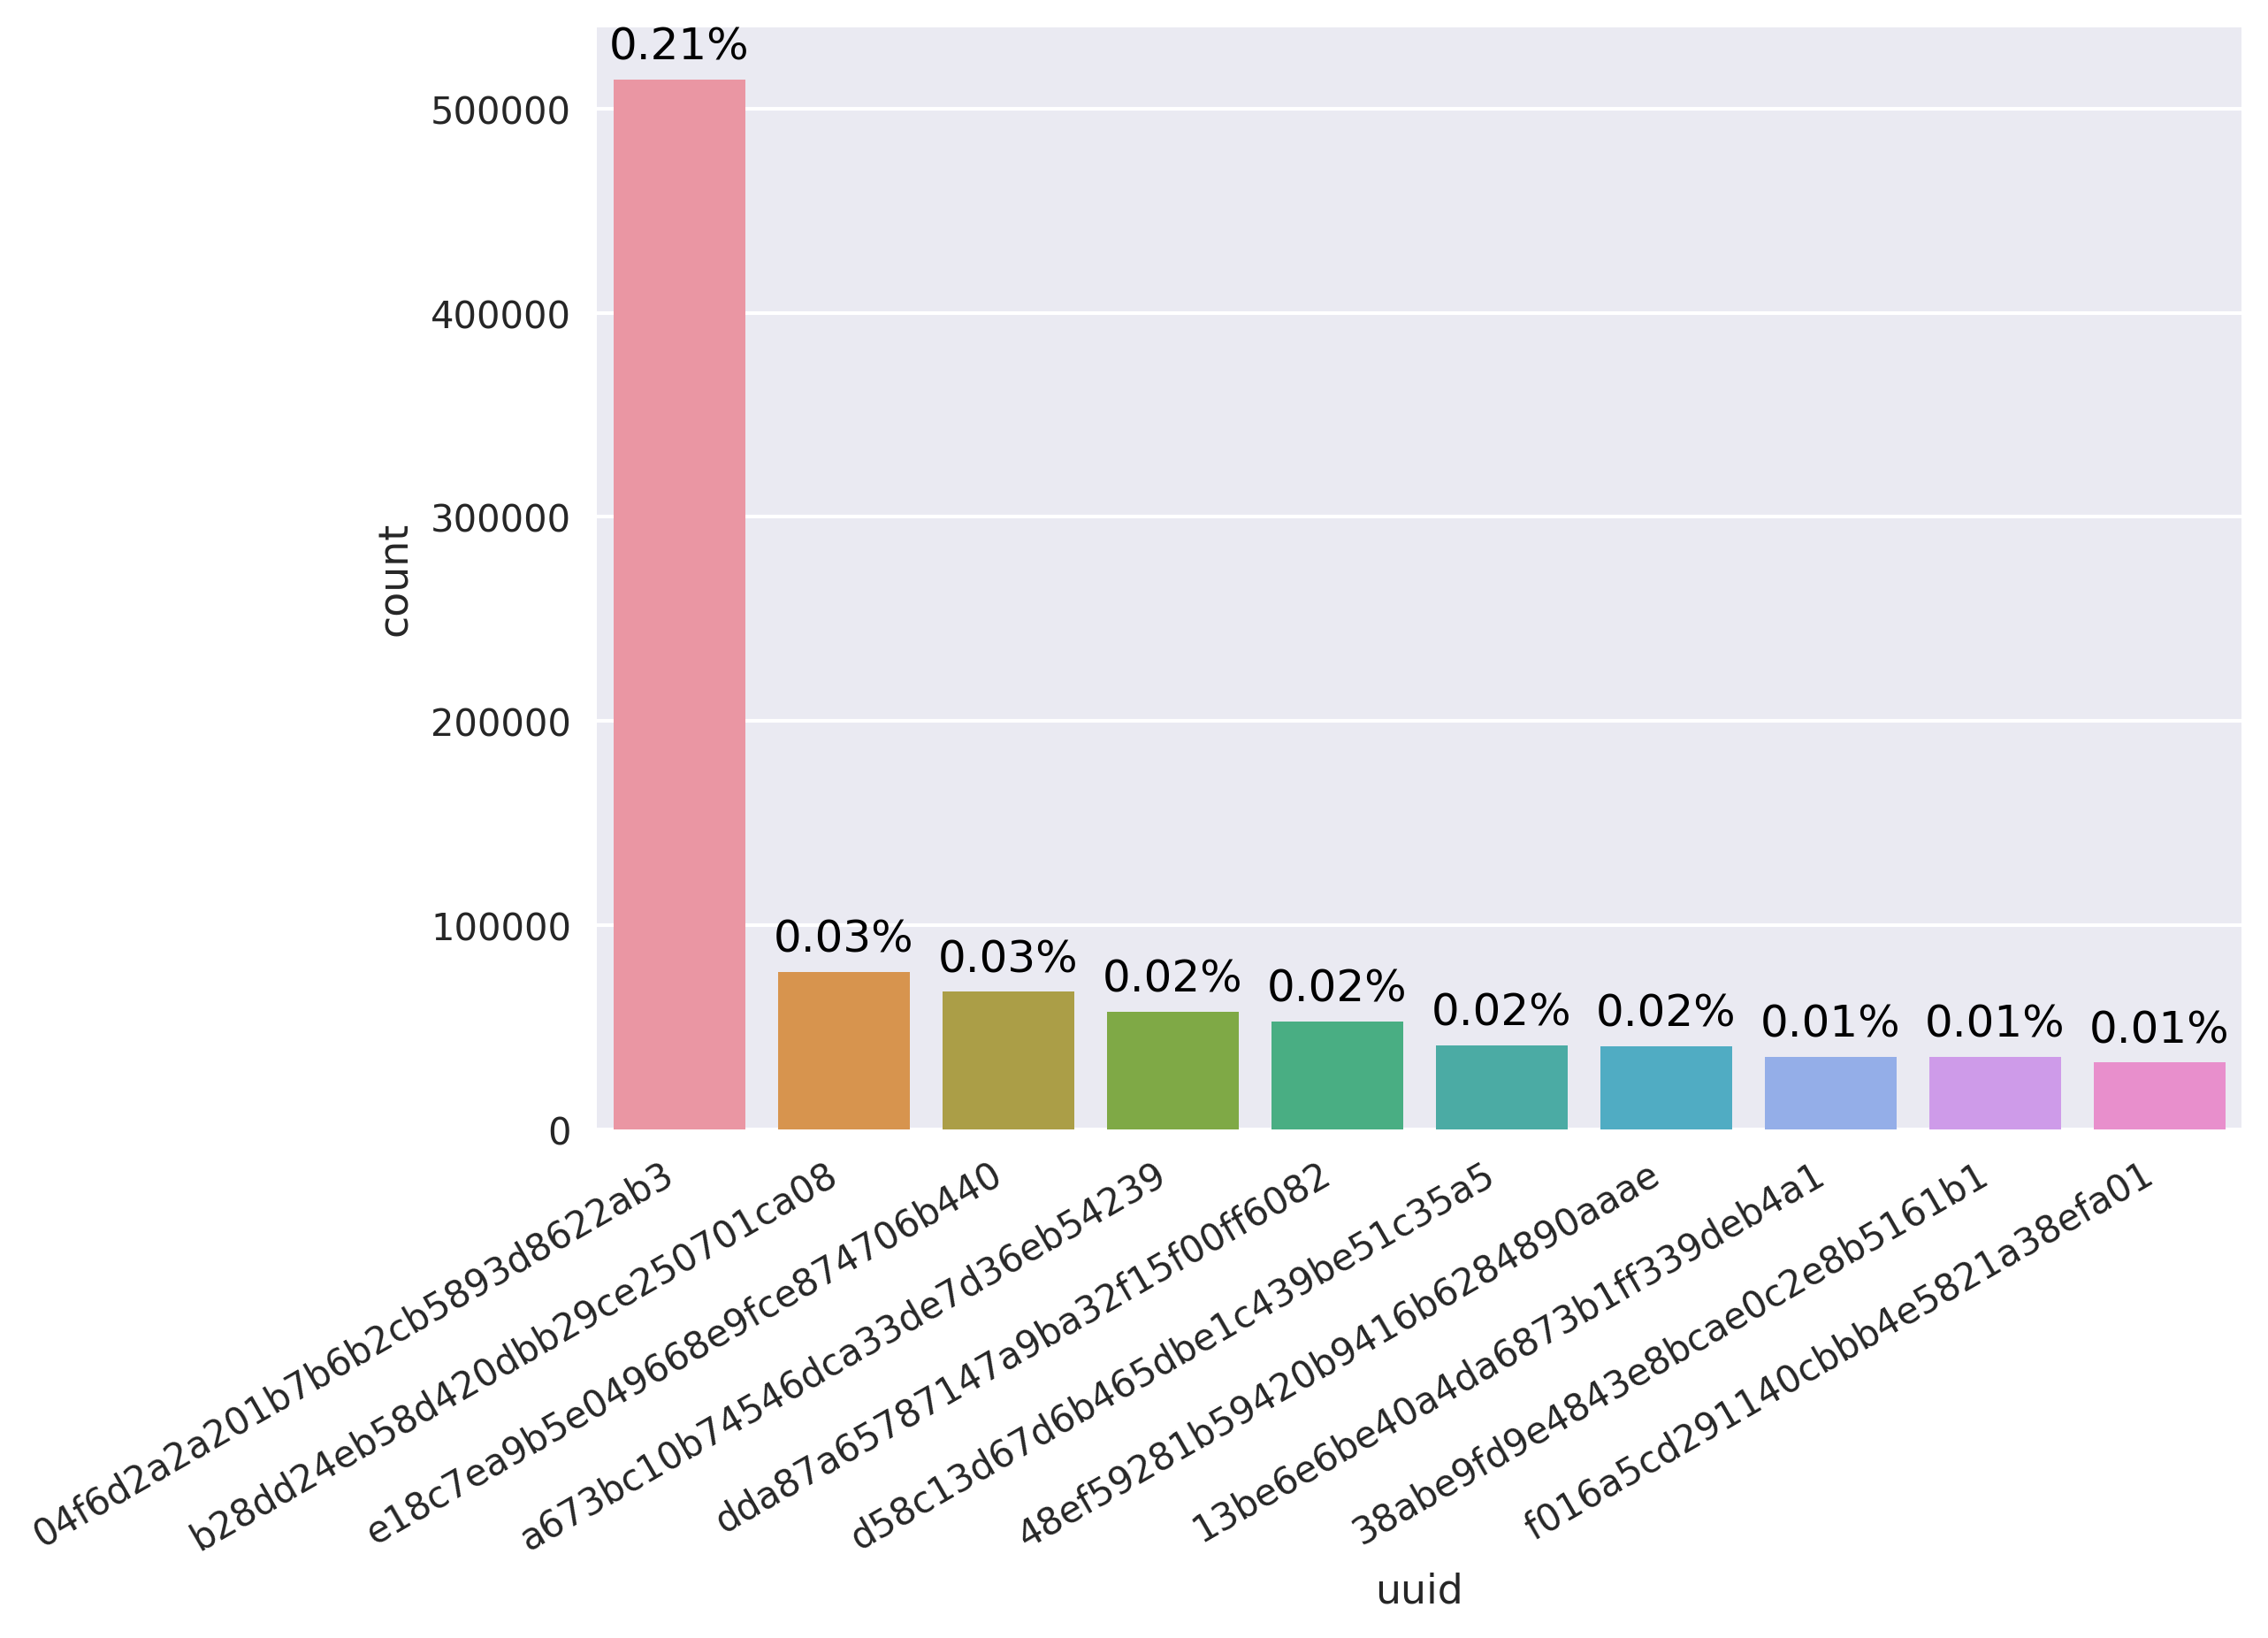

In [89]:
df_plot12['uuid'] = df_plot12.uuid.astype(str)

ax=sns.barplot(x="uuid", y="count", data=df_plot12, ci=None)

for index, row in df_plot12.iterrows():
    ax.text(row.name,row['count']+10000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right")

In [33]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT guid, COUNT(*) as count\
                   FROM traces \
                   GROUP BY guid \
                   ORDER BY count DESC)")
df_plot13 = df_ps.limit(10).toPandas()
df_plot13

guid     count  percentage
0  None                              51334564  20.96     
1  8CE4807D2A9DE549B64E67D4C302CE19  760227    0.31      
2  AB4DF900FCDC4FB1A31F57E7770986C7  179636    0.07      
3  AEEAF82394064D5DB564C325370C0DA0  162514    0.07      
4  4CD86893346B4D3C87B011FBD17A483D  145007    0.06      
5  B6F38B5EBD2E4CF397D85FC7901FD408  139821    0.06      
6  79D0C31747D64AC1A869253DA22A7DAE  104162    0.04      
7  ef14ee0b74cb49e999a2521f3e0e0d82  96939     0.04      
8  C3F5B85D89BF40C7AC3D415BBE52F561  96723     0.04      
9  BF851E562D344F4E9DD45E8066D7D0D3  92128     0.04

[Text(0,0,u'None'),
 Text(0,0,u'8CE4807D2A9DE549B64E67D4C302CE19'),
 Text(0,0,u'AB4DF900FCDC4FB1A31F57E7770986C7'),
 Text(0,0,u'AEEAF82394064D5DB564C325370C0DA0'),
 Text(0,0,u'4CD86893346B4D3C87B011FBD17A483D'),
 Text(0,0,u'B6F38B5EBD2E4CF397D85FC7901FD408'),
 Text(0,0,u'79D0C31747D64AC1A869253DA22A7DAE'),
 Text(0,0,u'ef14ee0b74cb49e999a2521f3e0e0d82'),
 Text(0,0,u'C3F5B85D89BF40C7AC3D415BBE52F561'),
 Text(0,0,u'BF851E562D344F4E9DD45E8066D7D0D3')]

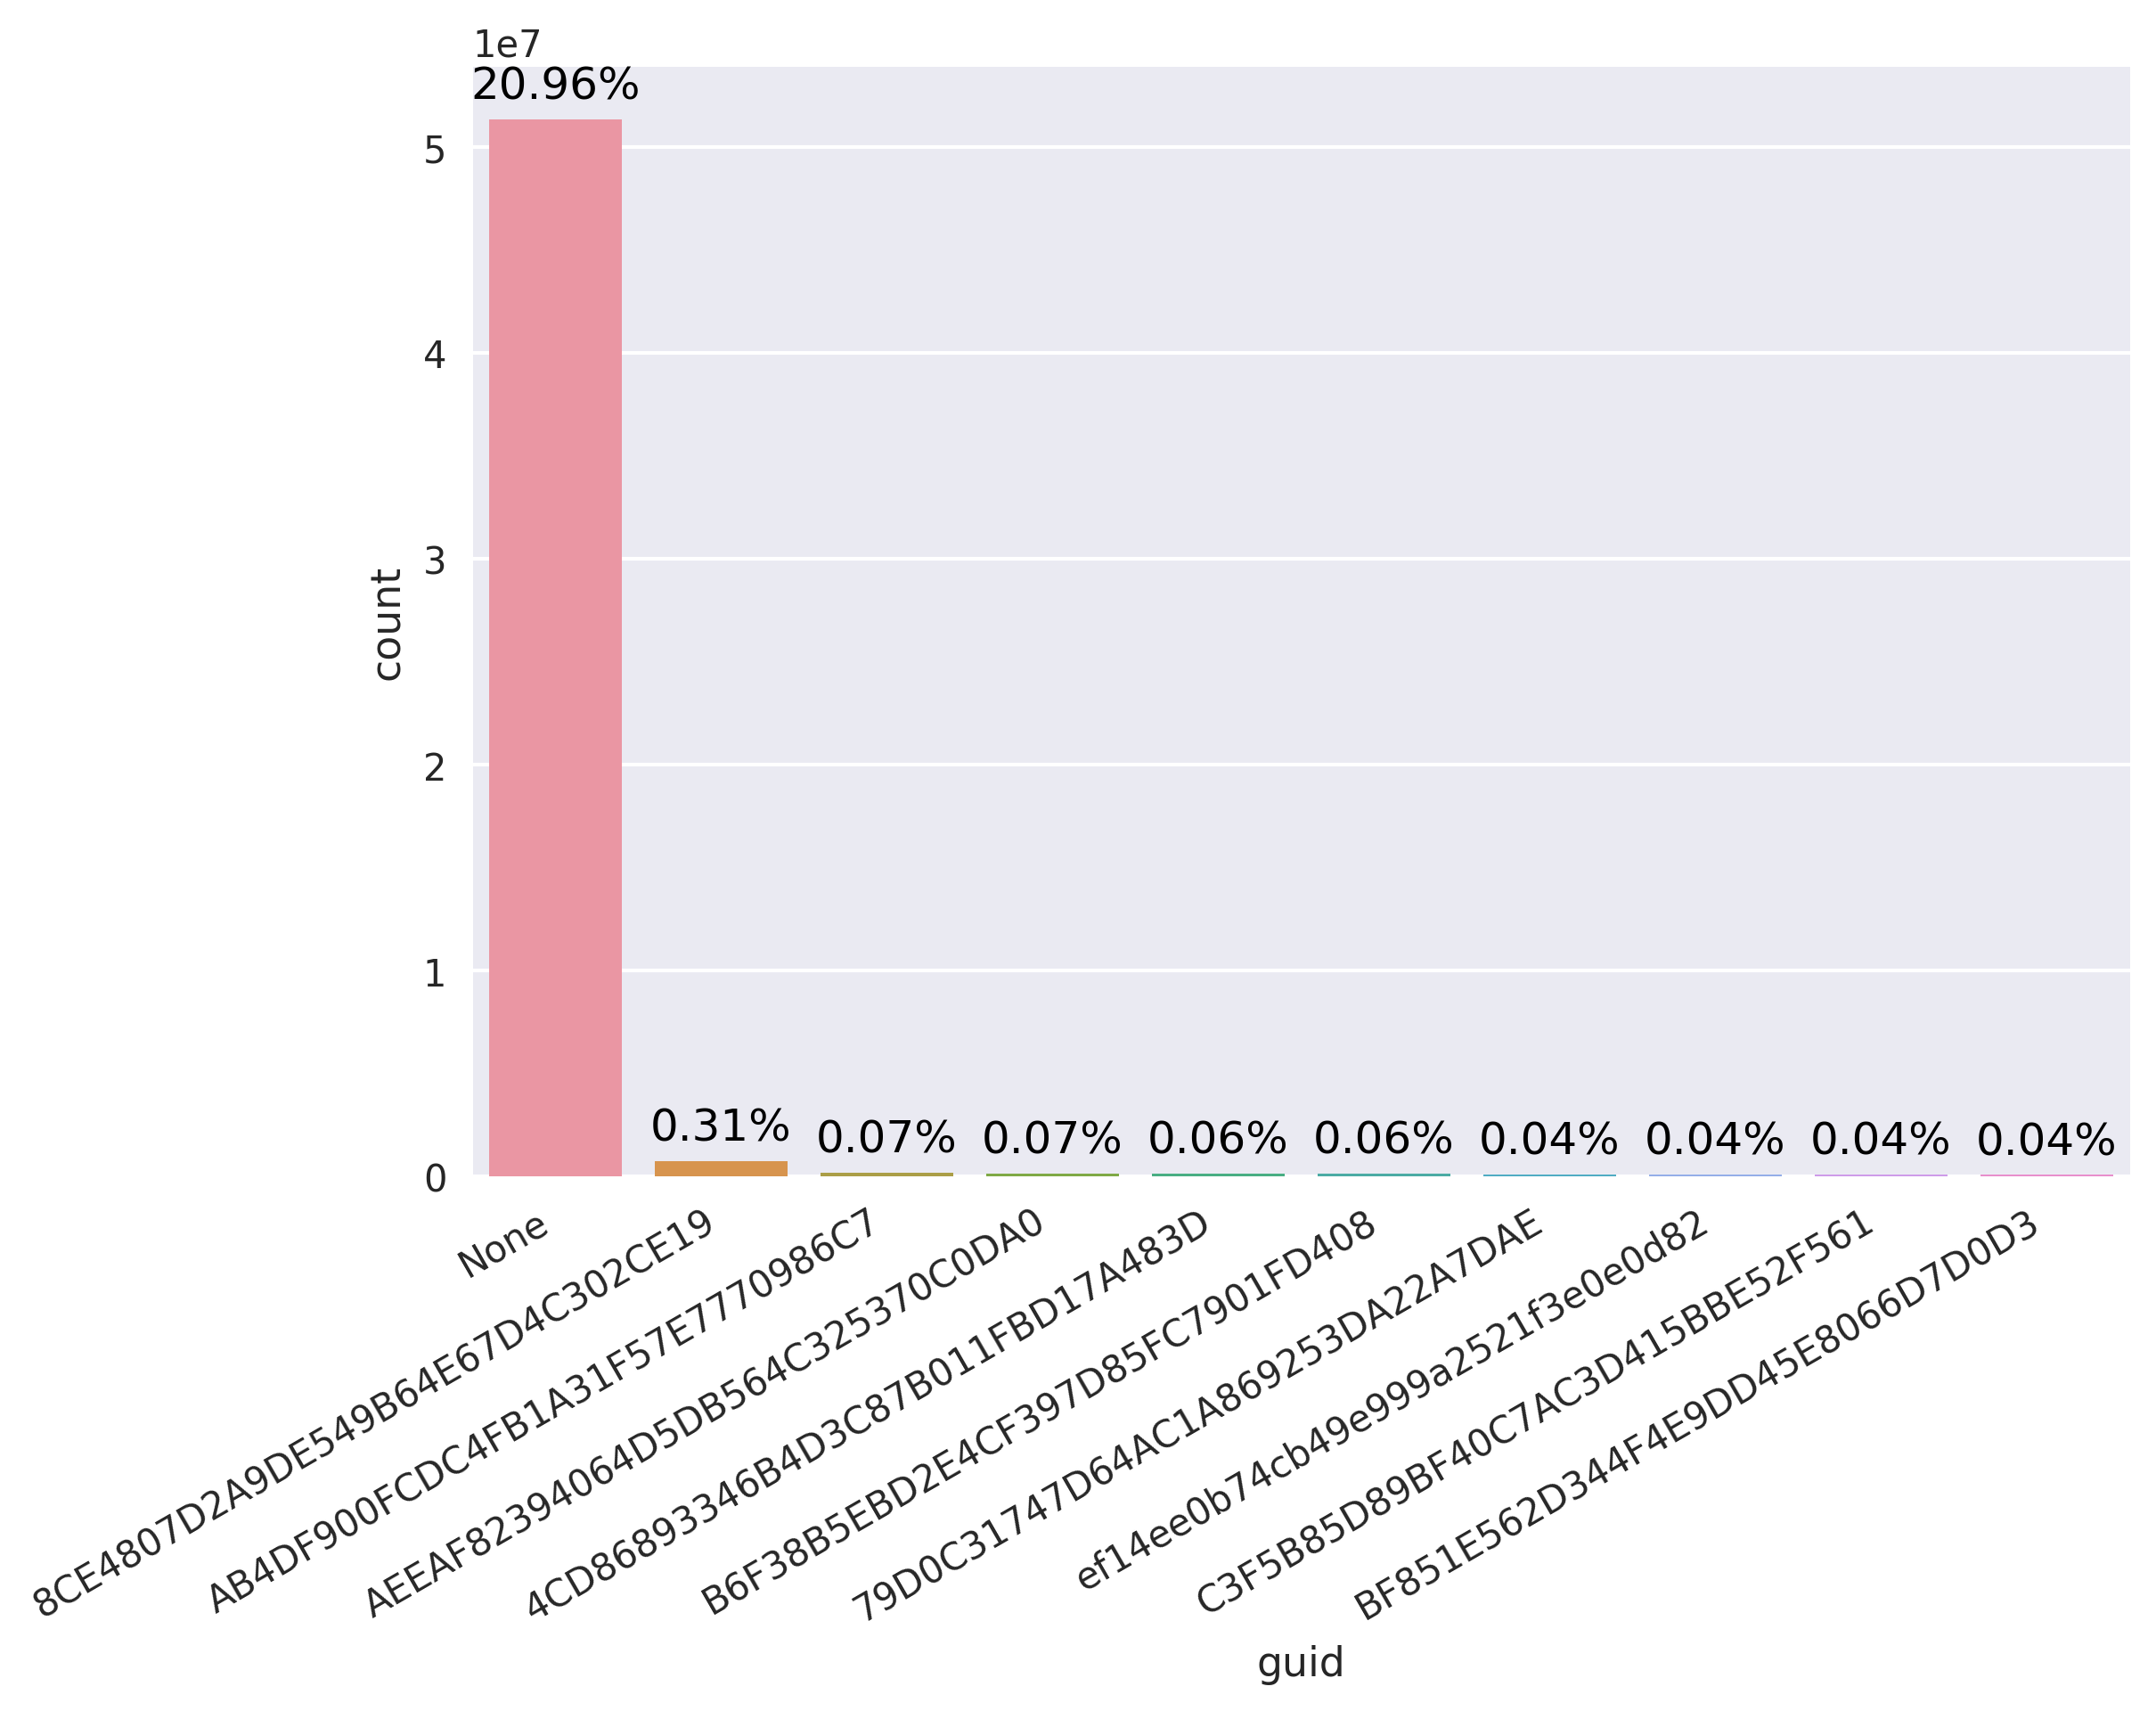

In [90]:
df_plot13['guid'] = df_plot13.guid.astype(str)

ax=sns.barplot(x="guid", y="count", data=df_plot13, ci=None)

for index, row in df_plot13.iterrows():
    ax.text(row.name,row['count']+1000000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right")

In [35]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT hostname, COUNT(*) as count\
                   FROM traces \
                   GROUP BY hostname \
                   ORDER BY count DESC)")
df_plot14 = df_ps.limit(10).toPandas()
df_plot14

hostname     count  percentage
0  None                  10537460  4.30      
1                        1175888   0.48      
2  lapa.lancs.ac.uk      1024981   0.42      
3  dtn35.ccs.ornl.gov    437457    0.18      
4  dtn37.ccs.ornl.gov    434893    0.18      
5  dtn36.ccs.ornl.gov    429234    0.18      
6  lxcvmfs64.cern.ch     303218    0.12      
7  localhost             252052    0.10      
8  lxatut01.cern.ch      216202    0.09      
9  eprexa.ph.bham.ac.uk  196364    0.08

[Text(0,0,u'None'),
 Text(0,0,u''),
 Text(0,0,u'lapa.lancs.ac.uk'),
 Text(0,0,u'dtn35.ccs.ornl.gov'),
 Text(0,0,u'dtn37.ccs.ornl.gov'),
 Text(0,0,u'dtn36.ccs.ornl.gov'),
 Text(0,0,u'lxcvmfs64.cern.ch'),
 Text(0,0,u'localhost'),
 Text(0,0,u'lxatut01.cern.ch'),
 Text(0,0,u'eprexa.ph.bham.ac.uk')]

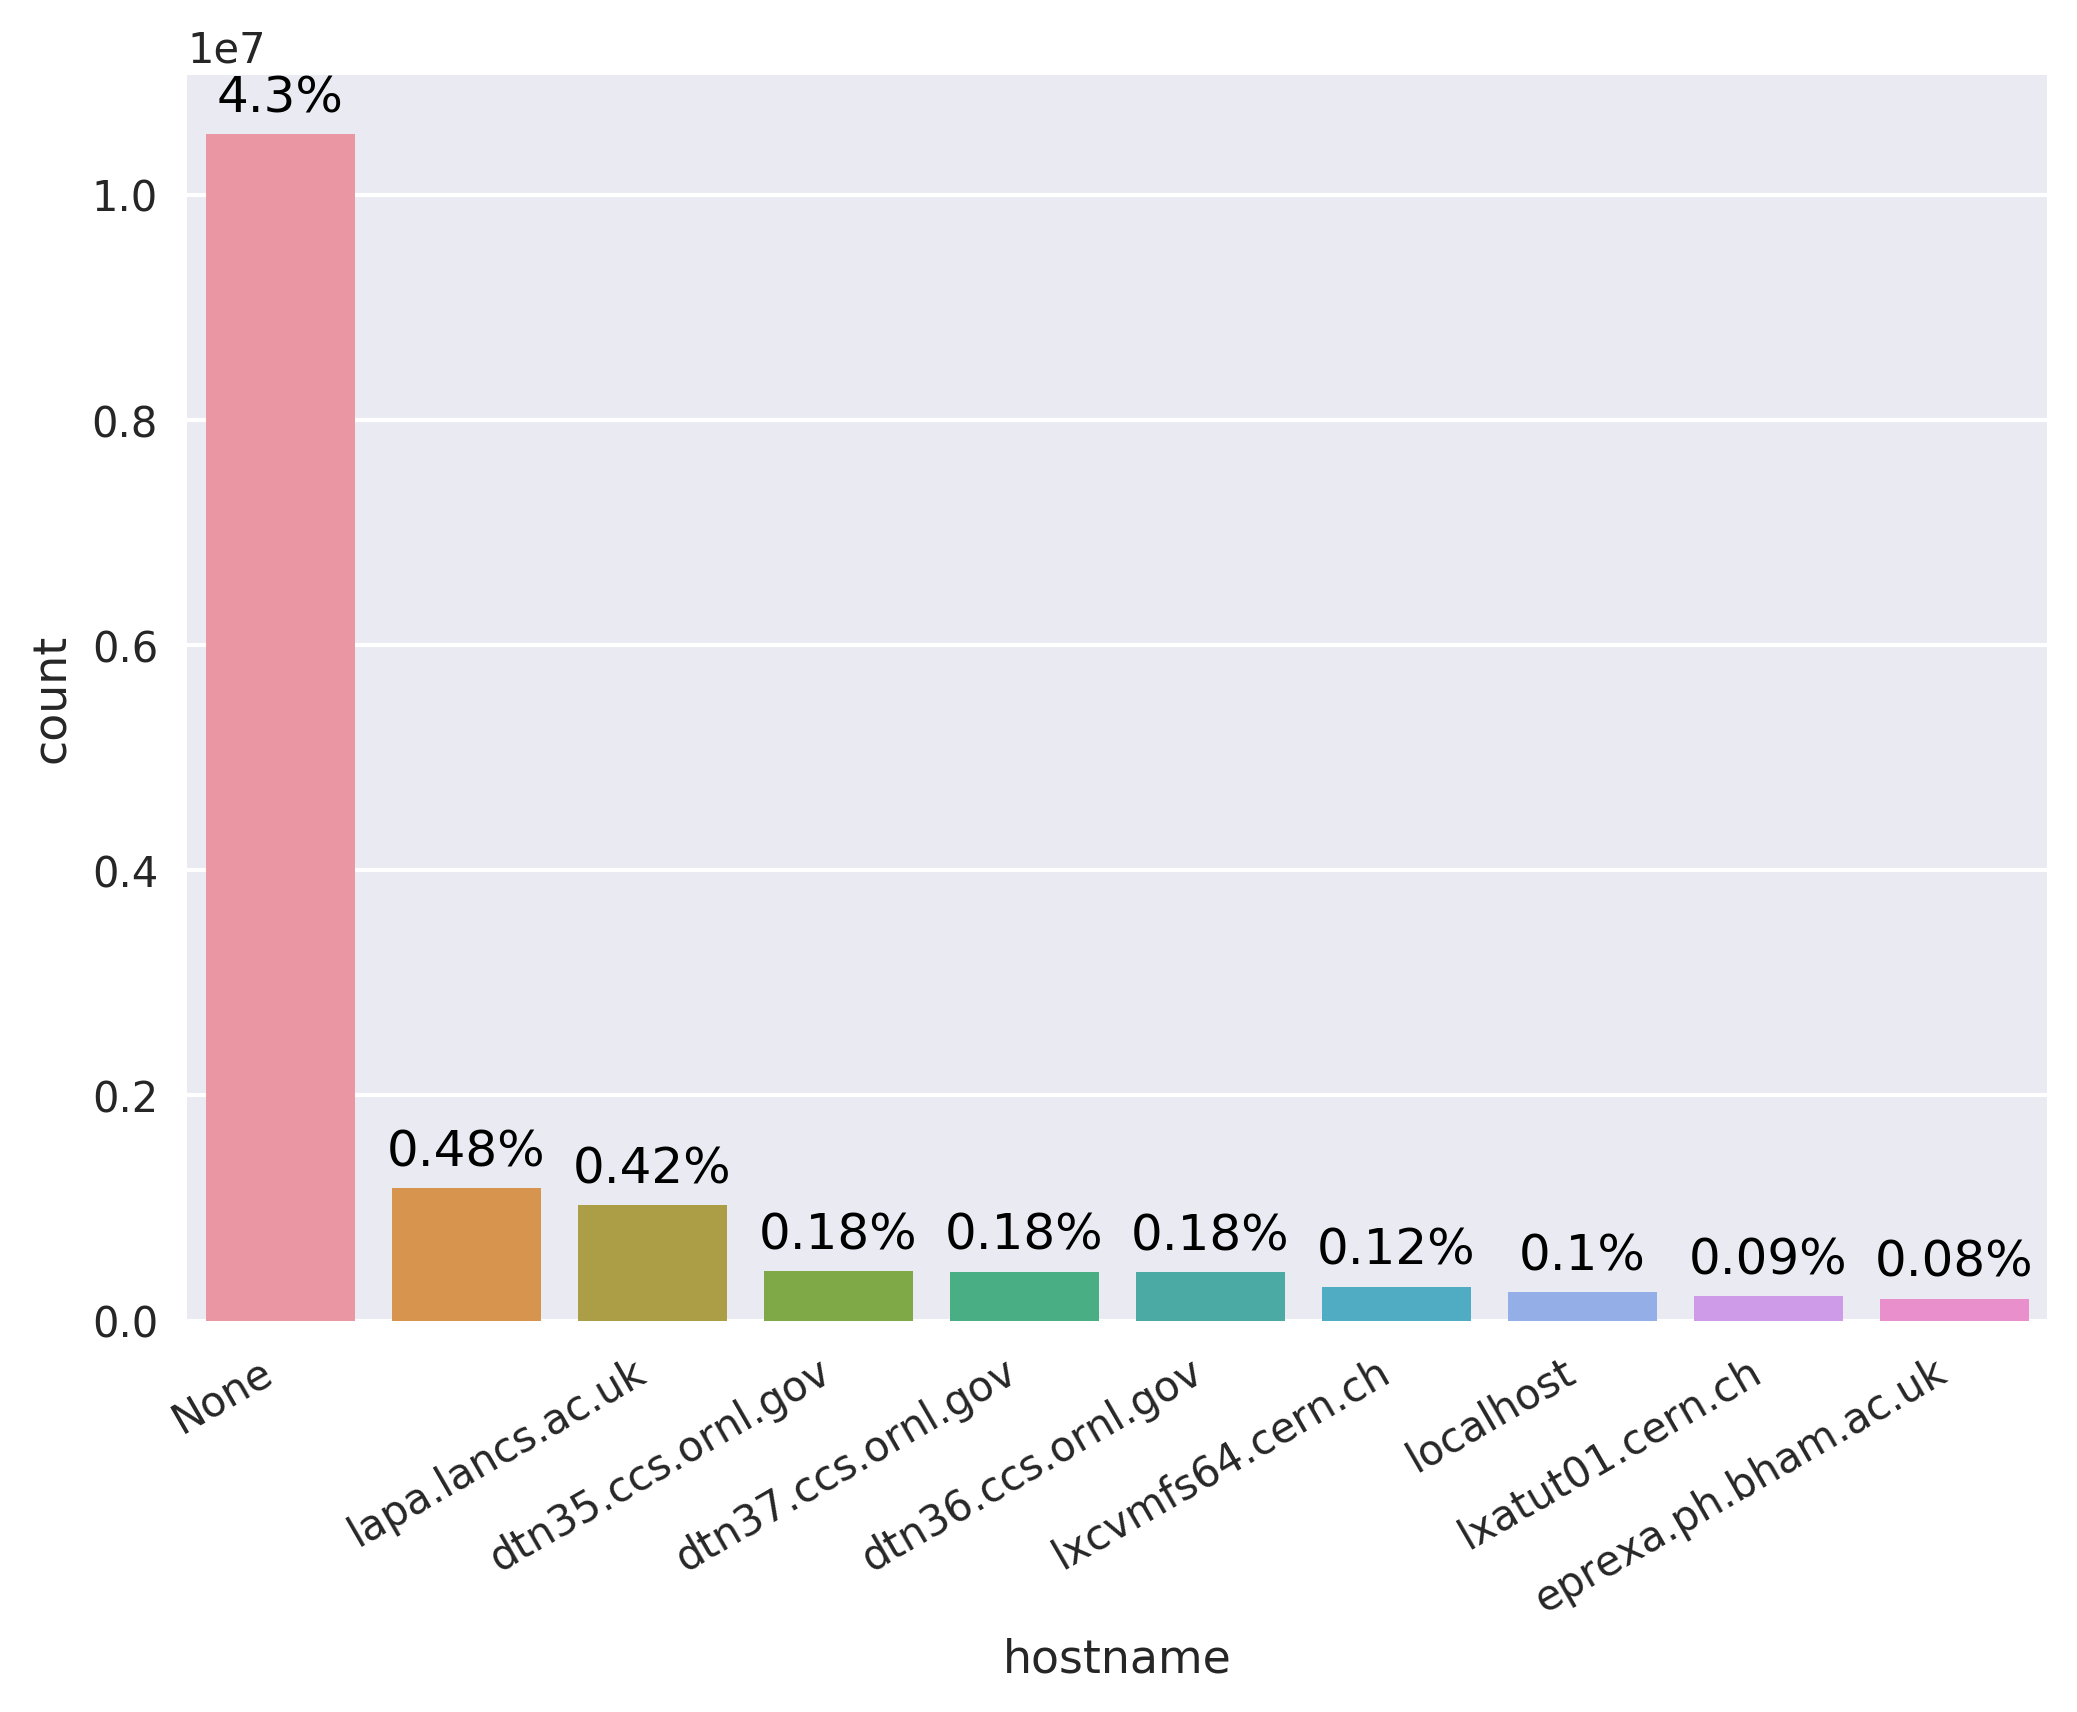

In [93]:
df_plot14['hostname'] = df_plot14.hostname.astype(str)

ax=sns.barplot(x="hostname", y="count", data=df_plot14, ci=None)

for index, row in df_plot14.iterrows():
    ax.text(row.name,row['count']+200000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right")

In [37]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT ip, COUNT(*) as count\
                   FROM traces \
                   GROUP BY ip \
                   ORDER BY count DESC)")
df_plot15 = df_ps.limit(10).toPandas()
df_plot15

ip     count  percentage
0  None            54509526  22.26     
1  172.28.5.0      1202228   0.49      
2  172.28.5.1      1105725   0.45      
3  172.28.5.2      1039855   0.42      
4  172.28.5.3      888263    0.36      
5  172.28.5.4      683316    0.28      
6  172.28.5.5      581197    0.24      
7                  575425    0.23      
8  172.28.5.6      468500    0.19      
9  160.91.195.155  437457    0.18

[Text(0,0,u'None'),
 Text(0,0,u'172.28.5.0'),
 Text(0,0,u'172.28.5.1'),
 Text(0,0,u'172.28.5.2'),
 Text(0,0,u'172.28.5.3'),
 Text(0,0,u'172.28.5.4'),
 Text(0,0,u'172.28.5.5'),
 Text(0,0,u''),
 Text(0,0,u'172.28.5.6'),
 Text(0,0,u'160.91.195.155')]

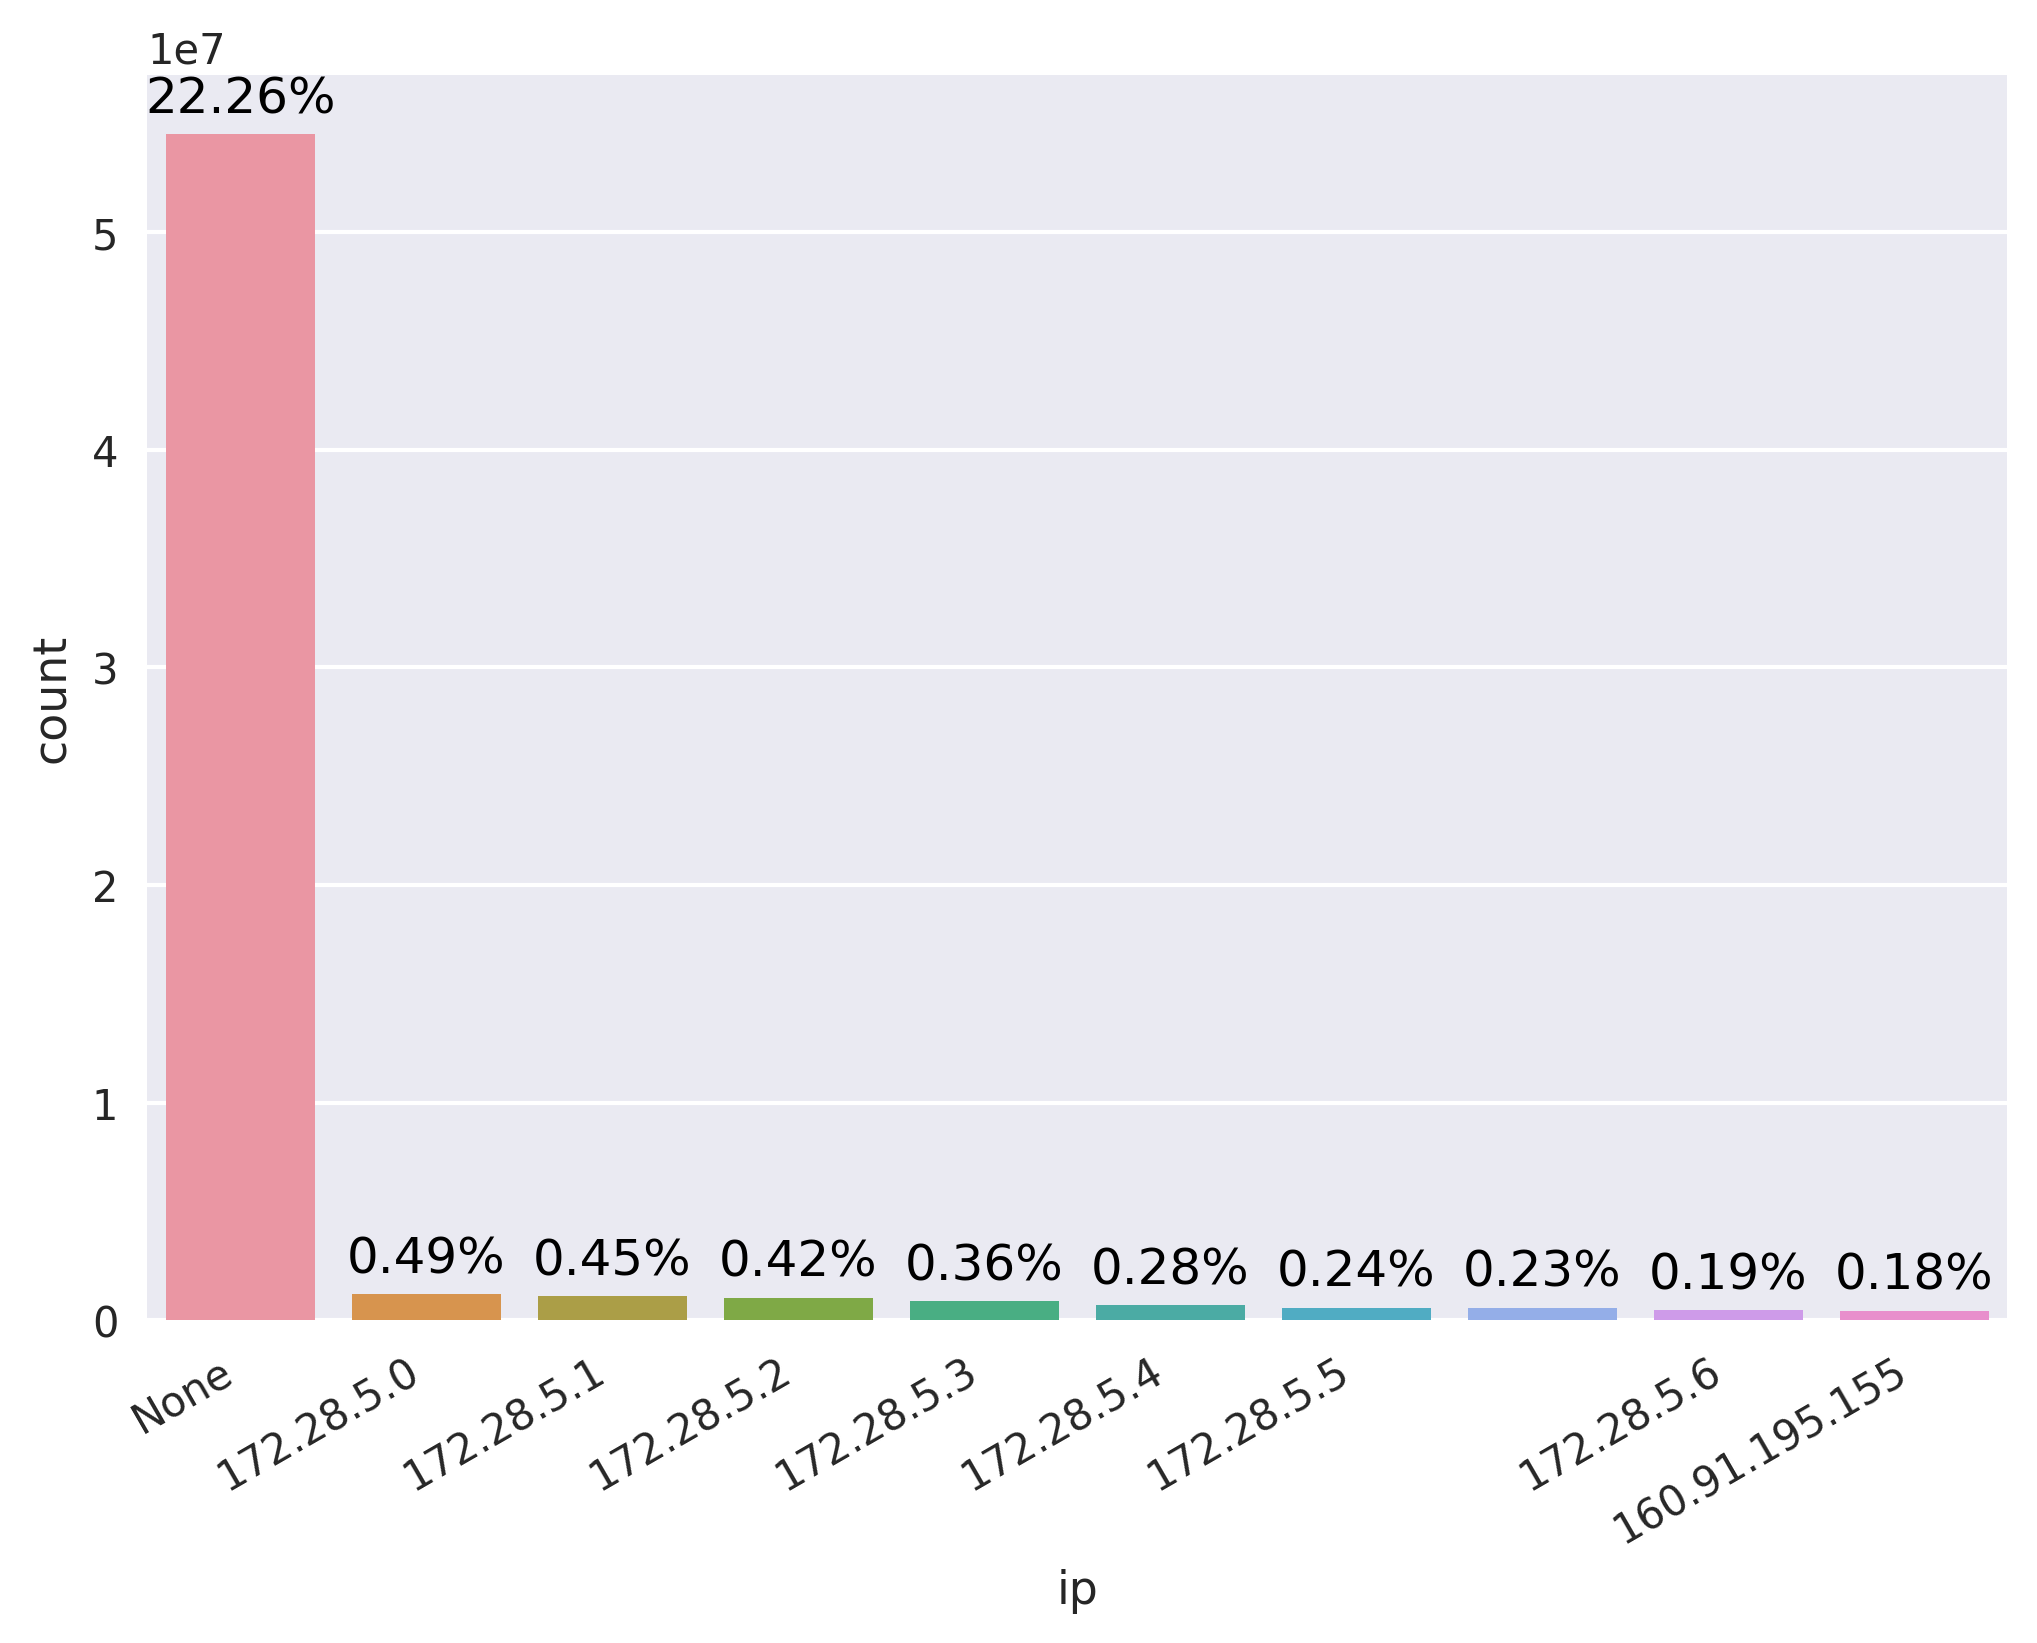

In [94]:
df_plot15['ip'] = df_plot15.ip.astype(str)

ax=sns.barplot(x="ip", y="count", data=df_plot15, ci=None)

for index, row in df_plot15.iterrows():
    ax.text(row.name,row['count']+1000000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right")

In [39]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT localsite, COUNT(*) as count\
                   FROM traces \
                   GROUP BY localsite \
                   ORDER BY count DESC)")
df_plot16 = df_ps.limit(10).toPandas()
df_plot16

localsite     count  percentage
0  None                   44002731  17.97     
1  BNL-OSG2_DATADISK      14356069  5.86      
2  CERN-PROD_DATADISK     11177969  4.56      
3  CERN-PROD_ES           9433016   3.85      
4  NDGF-T1_DATADISK       8022847   3.28      
5  MWT2_DATADISK          7216397   2.95      
6  IN2P3-CC_DATADISK      6392797   2.61      
7  INFN-T1_DATADISK       5855518   2.39      
8  CERN-PROD_SCRATCHDISK  5497477   2.24      
9  NDGF-T1_SCRATCHDISK    5383851   2.20

[Text(0,0,u'None'),
 Text(0,0,u'BNL-OSG2_DATADISK'),
 Text(0,0,u'CERN-PROD_DATADISK'),
 Text(0,0,u'CERN-PROD_ES'),
 Text(0,0,u'NDGF-T1_DATADISK'),
 Text(0,0,u'MWT2_DATADISK'),
 Text(0,0,u'IN2P3-CC_DATADISK'),
 Text(0,0,u'INFN-T1_DATADISK'),
 Text(0,0,u'CERN-PROD_SCRATCHDISK'),
 Text(0,0,u'NDGF-T1_SCRATCHDISK')]

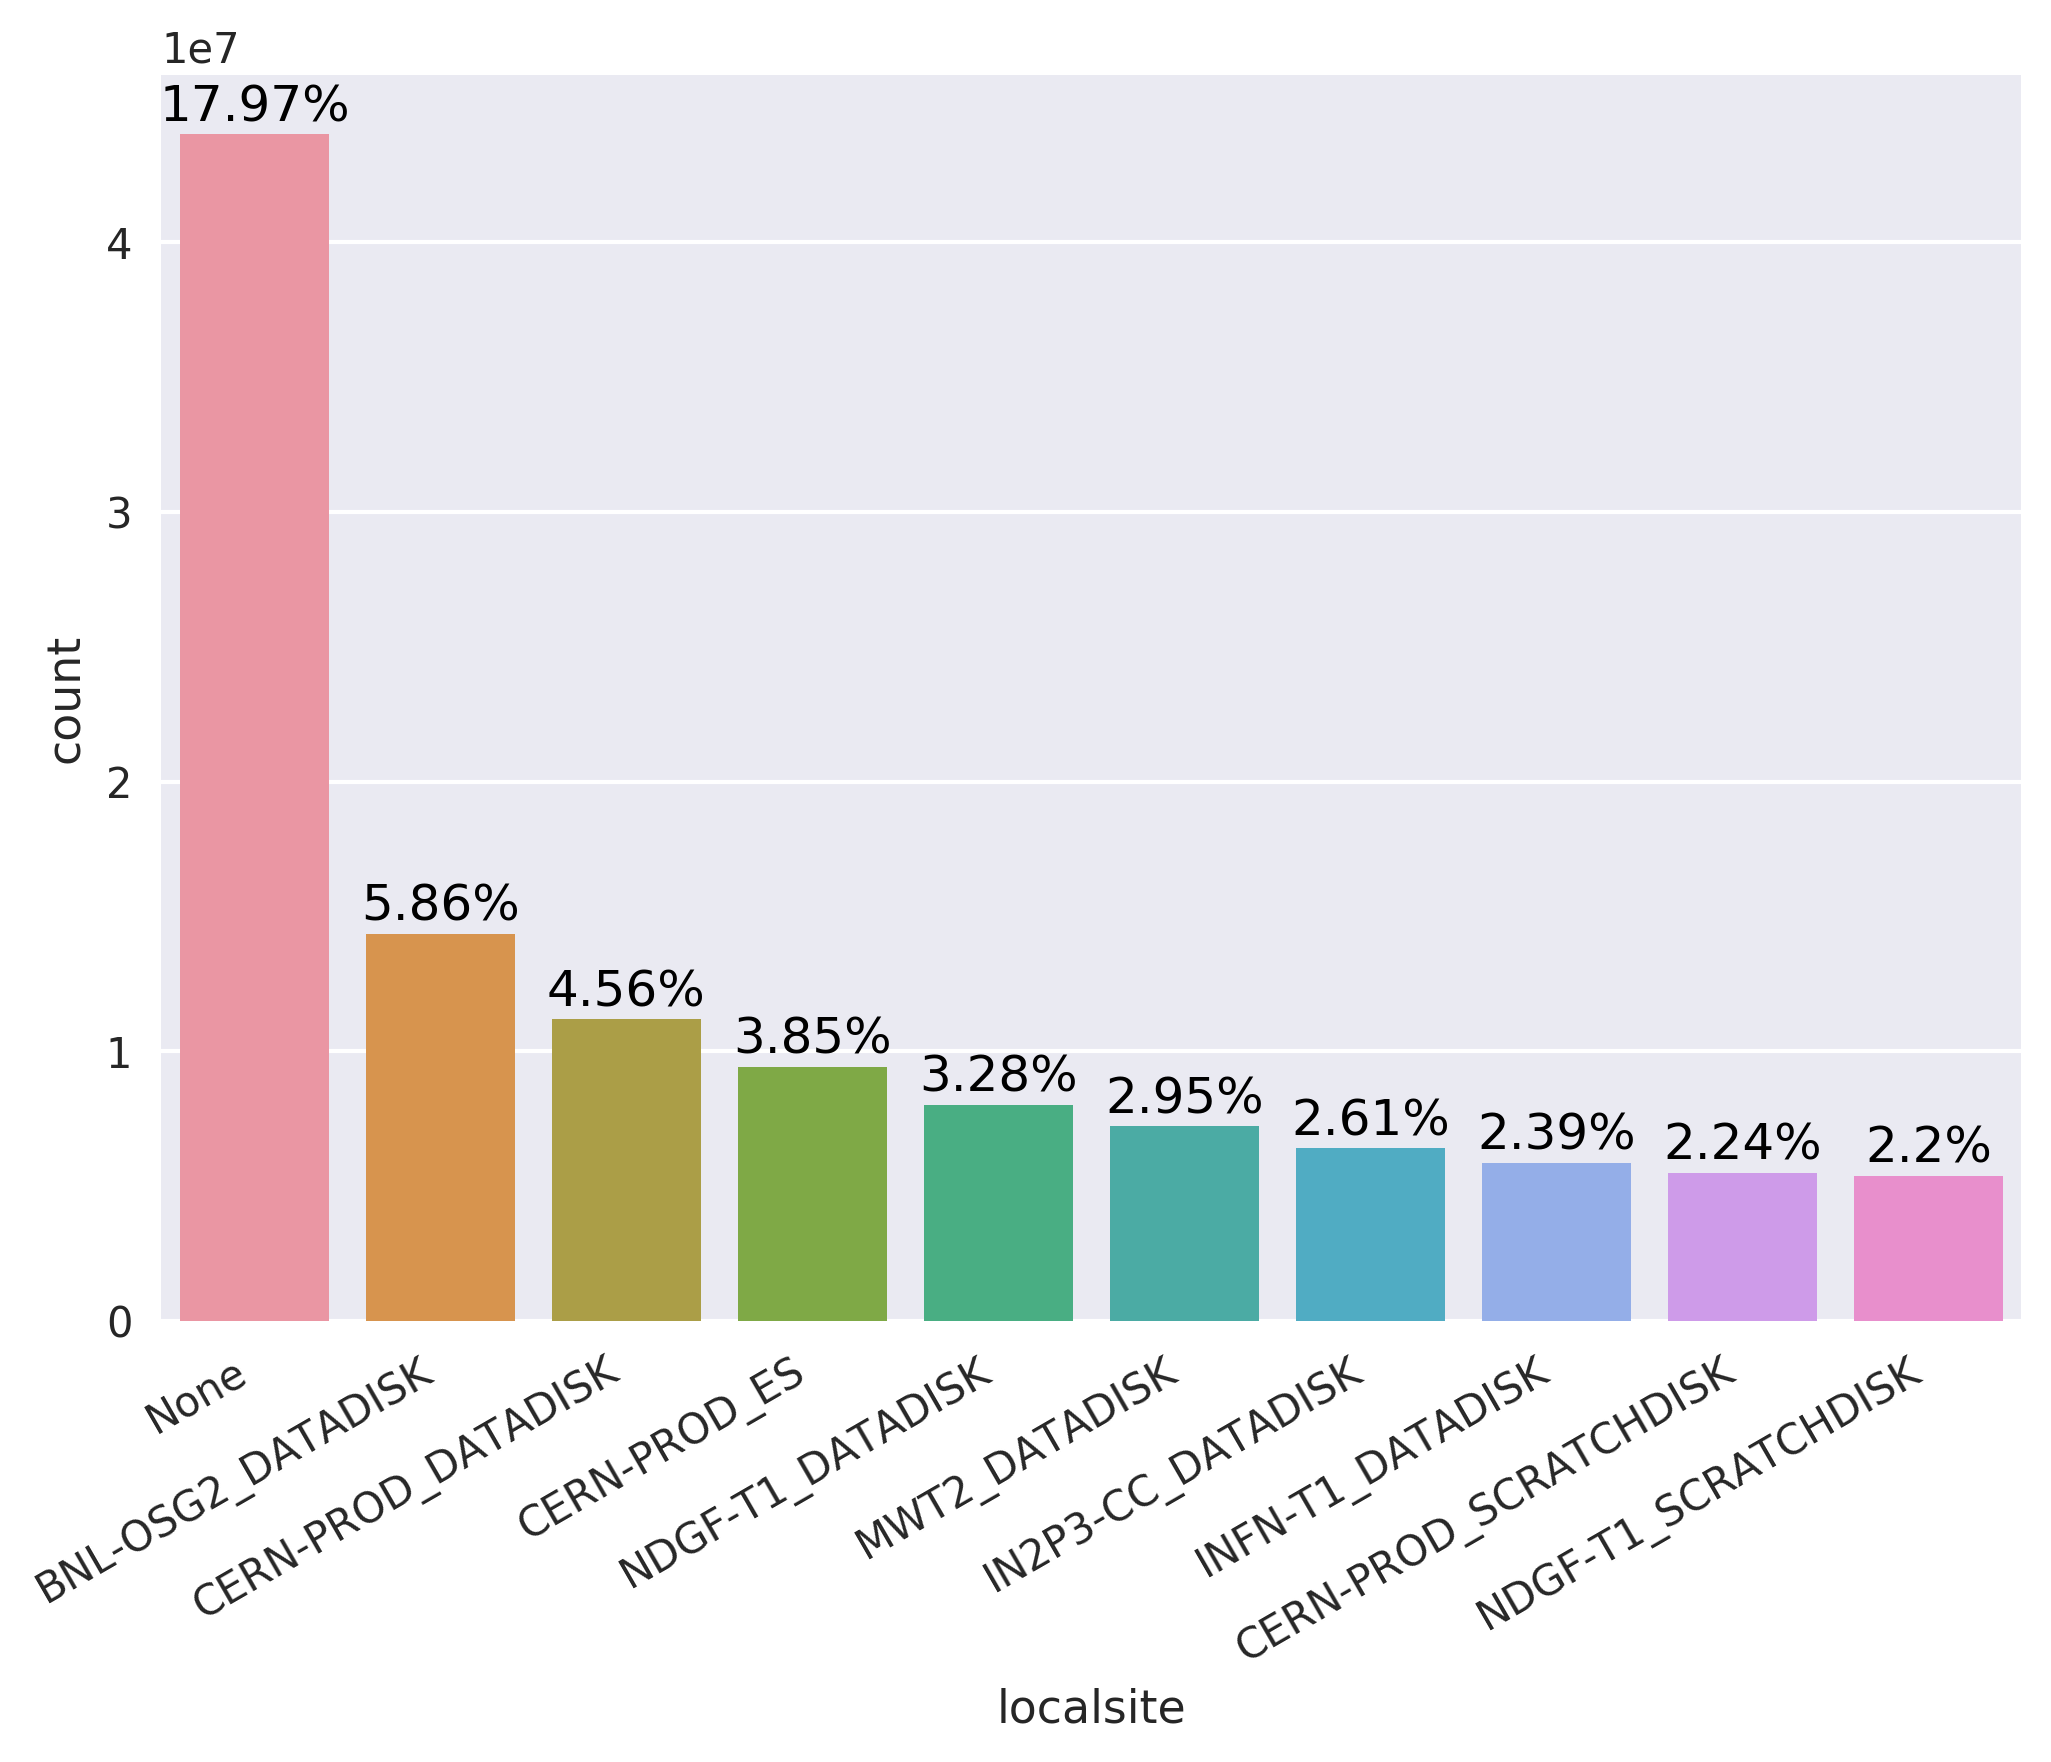

In [96]:
df_plot16['localsite'] = df_plot16.localsite.astype(str)

ax=sns.barplot(x="localsite", y="count", data=df_plot16, ci=None)

for index, row in df_plot16.iterrows():
    ax.text(row.name,row['count']+500000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right")

In [41]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT name, COUNT(*) as count\
                   FROM traces \
                   GROUP BY name \
                   ORDER BY count DESC)")
df_plot17 = df_ps.limit(10).toPandas()
df_plot17

name      count  percentage
0  None                                      244908635  100.0     
1  NTUP_PILEUP.11325647._000001.pool.root.1  64         0.0       
2  NTUP_PILEUP.11325647._000002.pool.root.1  64         0.0       
3  NTUP_PILEUP.11325965._000001.pool.root.1  52         0.0       
4  NTUP_PILEUP.11326165._000002.pool.root.1  52         0.0       
5  NTUP_PILEUP.11326165._000001.pool.root.1  52         0.0       
6  NTUP_PILEUP.11325705._000002.pool.root.1  52         0.0       
7  NTUP_PILEUP.11326105._000005.pool.root.1  52         0.0       
8  NTUP_PILEUP.11326153._000001.pool.root.1  52         0.0       
9  NTUP_PILEUP.11326105._000004.pool.root.1  52         0.0

[Text(0,0,u'None'),
 Text(0,0,u'NTUP_PILEUP.11325647._000001.pool.root.1'),
 Text(0,0,u'NTUP_PILEUP.11325647._000002.pool.root.1'),
 Text(0,0,u'NTUP_PILEUP.11325965._000001.pool.root.1'),
 Text(0,0,u'NTUP_PILEUP.11326165._000002.pool.root.1'),
 Text(0,0,u'NTUP_PILEUP.11326165._000001.pool.root.1'),
 Text(0,0,u'NTUP_PILEUP.11325705._000002.pool.root.1'),
 Text(0,0,u'NTUP_PILEUP.11326105._000005.pool.root.1'),
 Text(0,0,u'NTUP_PILEUP.11326153._000001.pool.root.1'),
 Text(0,0,u'NTUP_PILEUP.11326105._000004.pool.root.1')]

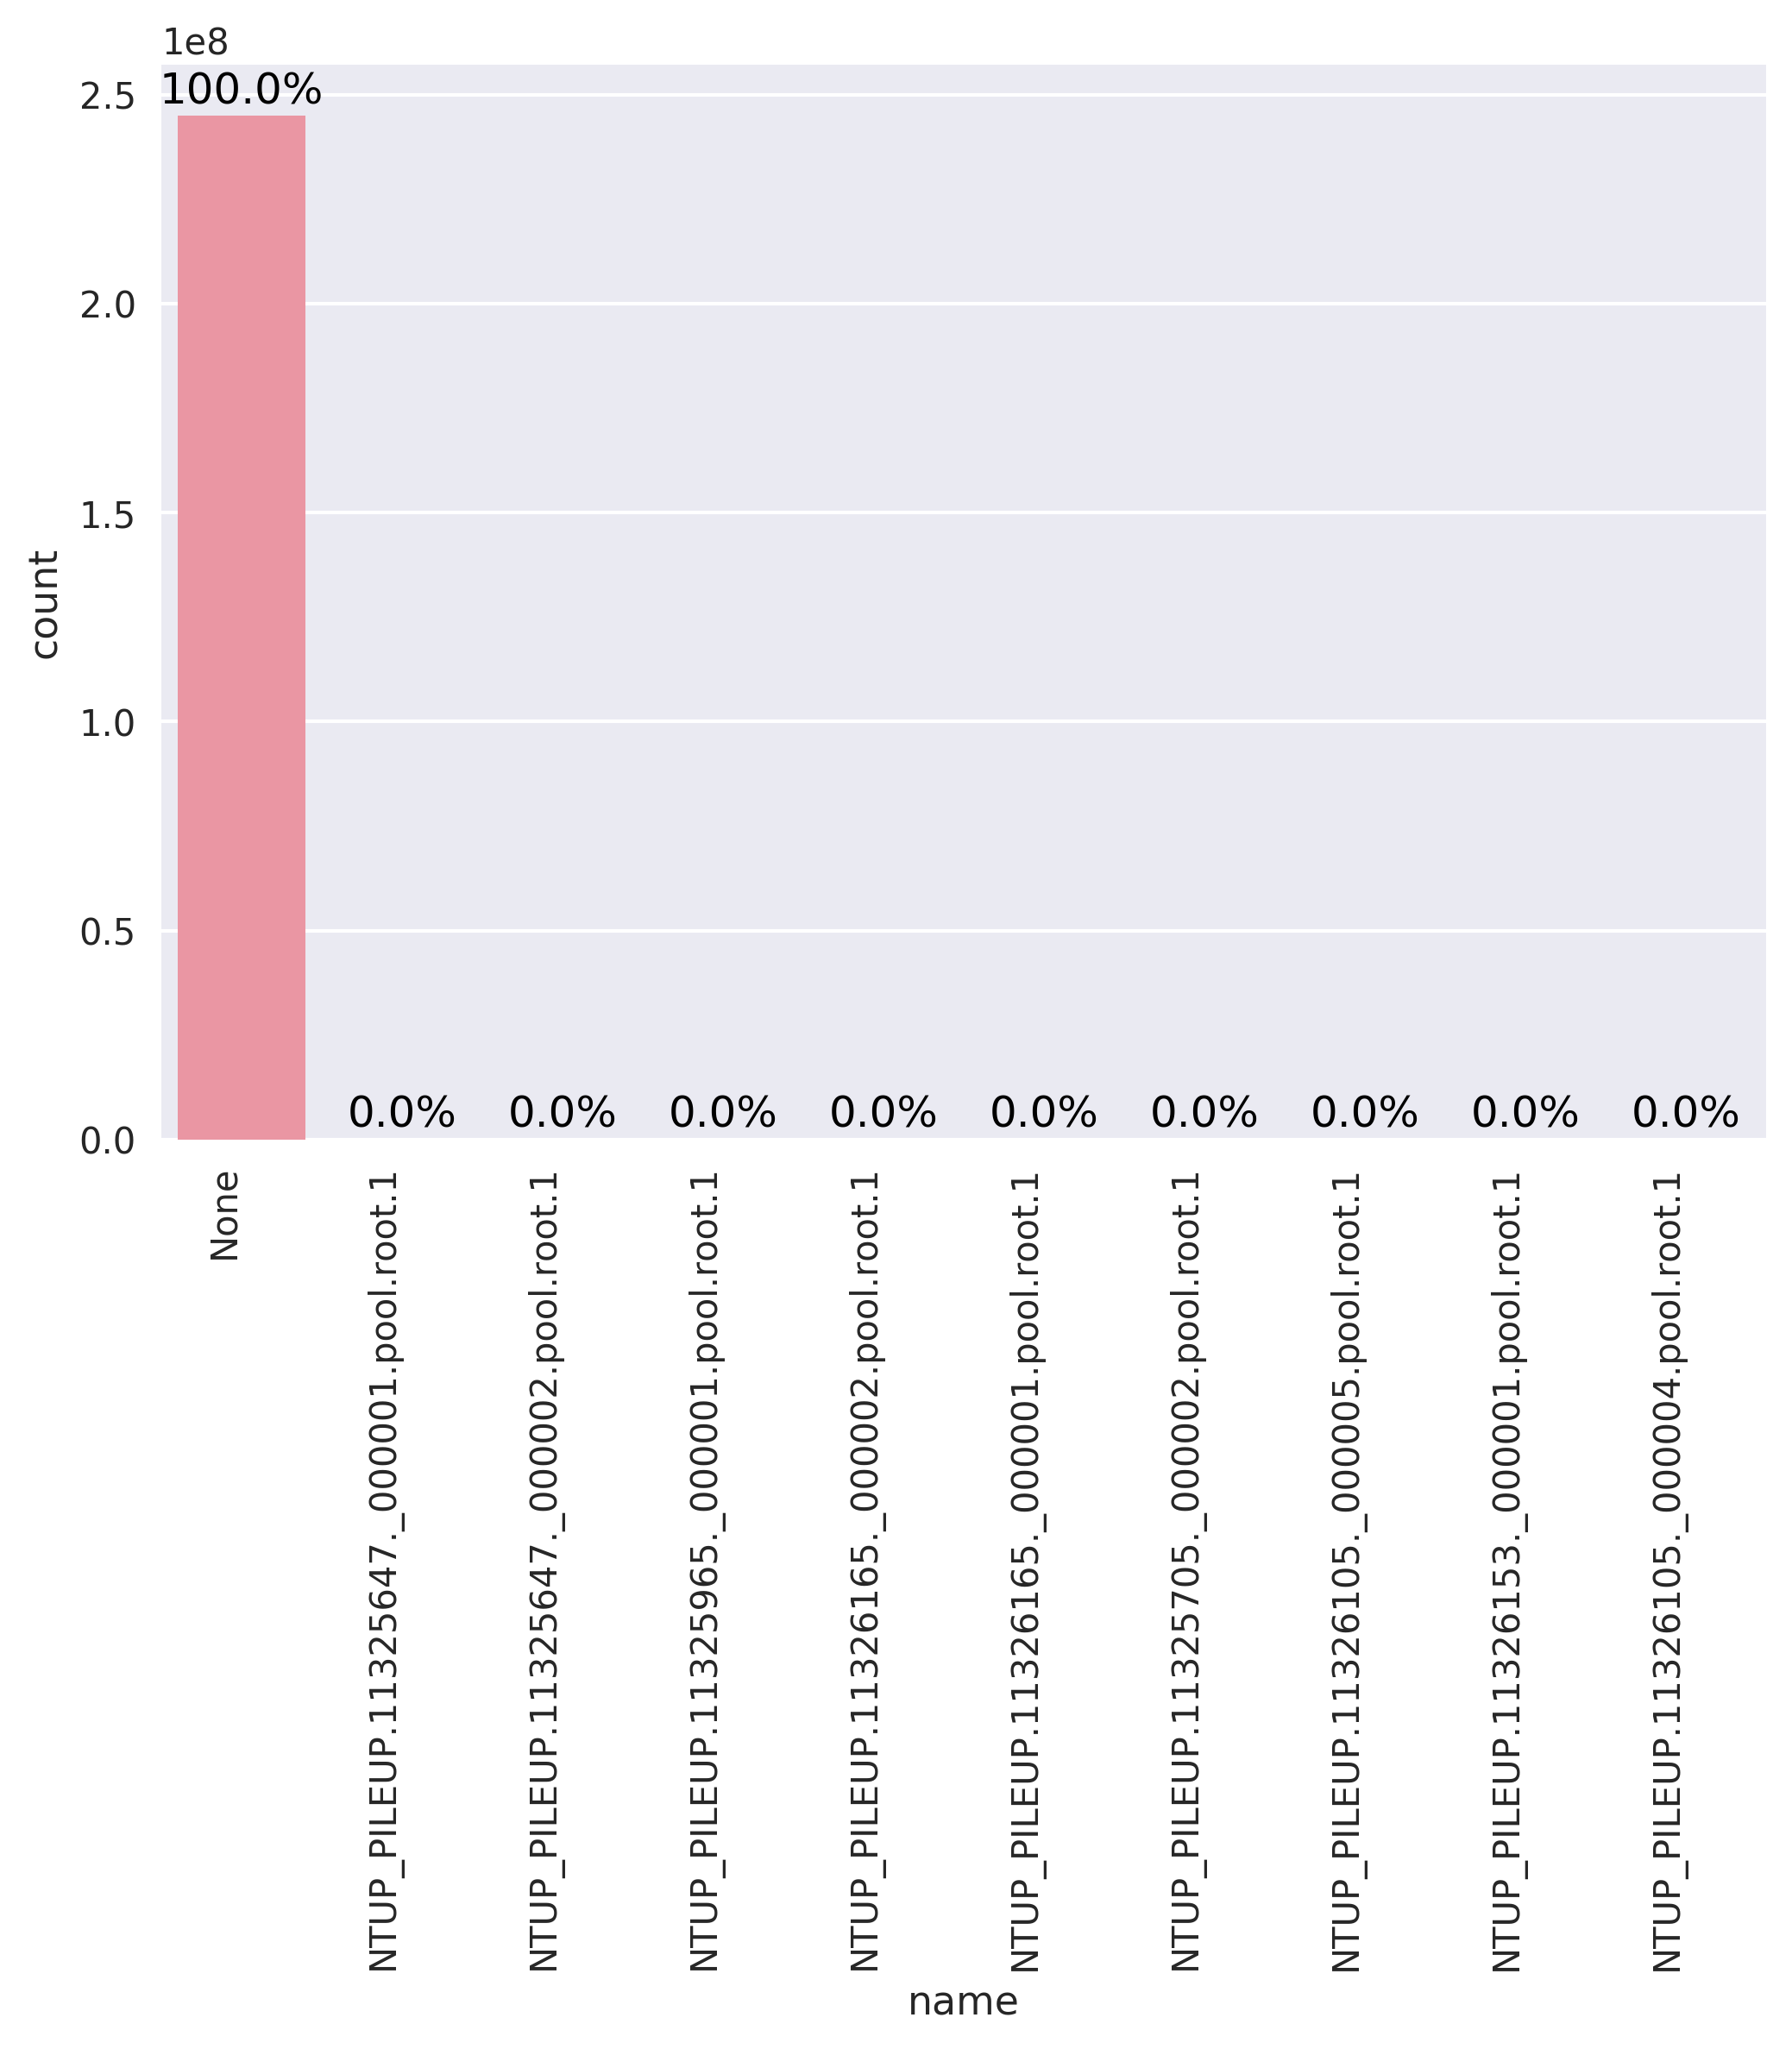

In [98]:
df_plot17['name'] = df_plot17.name.astype(str)

ax=sns.barplot(x="name", y="count", data=df_plot17, ci=None)

for index, row in df_plot17.iterrows():
    ax.text(row.name,row['count']+3000000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, ha="right")

In [43]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT pq, COUNT(*) as count\
                   FROM traces \
                   GROUP BY pq \
                   ORDER BY count DESC)")
df_plot18 = df_ps.limit(10).toPandas()
df_plot18

pq     count  percentage
0  None             55743107  22.76     
1  ANALY_CERN       8505088   3.47      
2  ANALY_BNL_SHORT  5906794   2.41      
3  ANALY_BNL_LONG   5431572   2.22      
4  ANALY_TOKYO_ARC  5426251   2.22      
5  ANALY_MWT2_SL6   5235975   2.14      
6  ANALY_FZK_UCORE  4895962   2.00      
7  BNL_PROD_MCORE   4603420   1.88      
8  ANALY_INFN-T1    4544906   1.86      
9  ANALY_IN2P3-CC   3431413   1.40

[Text(0,0,u'None'),
 Text(0,0,u'ANALY_CERN'),
 Text(0,0,u'ANALY_BNL_SHORT'),
 Text(0,0,u'ANALY_BNL_LONG'),
 Text(0,0,u'ANALY_TOKYO_ARC'),
 Text(0,0,u'ANALY_MWT2_SL6'),
 Text(0,0,u'ANALY_FZK_UCORE'),
 Text(0,0,u'BNL_PROD_MCORE'),
 Text(0,0,u'ANALY_INFN-T1'),
 Text(0,0,u'ANALY_IN2P3-CC')]

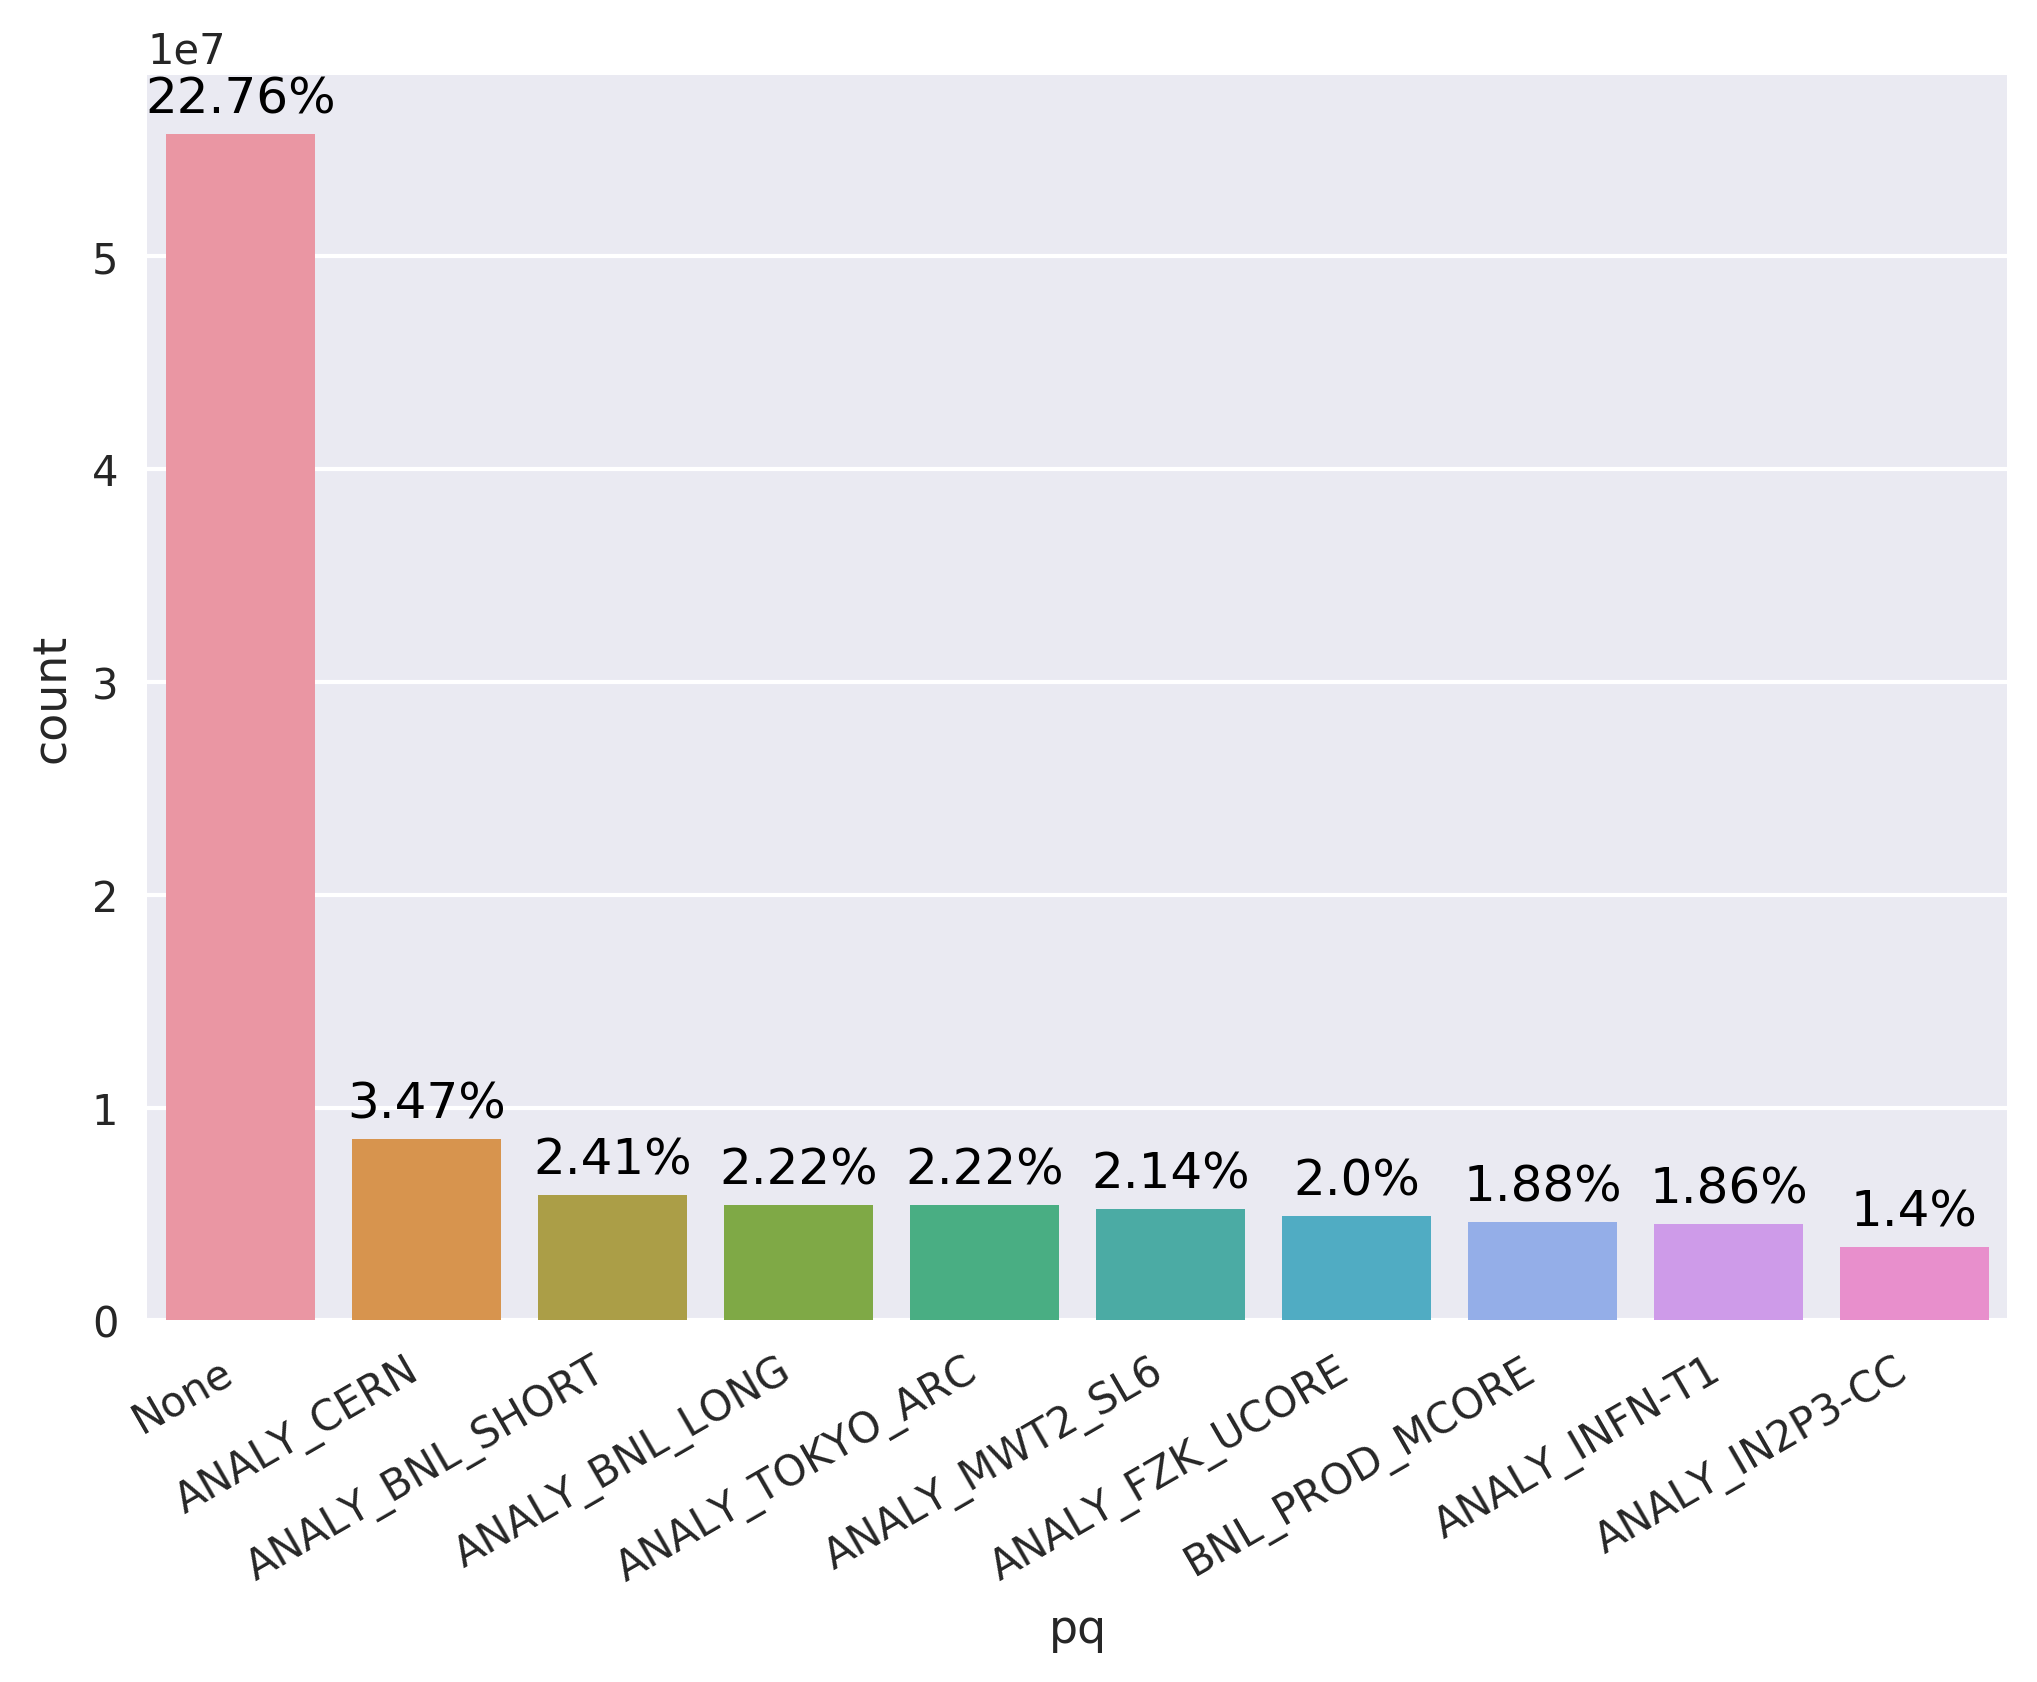

In [99]:
df_plot18['pq'] = df_plot18.pq.astype(str)

ax=sns.barplot(x="pq", y="count", data=df_plot18, ci=None)

for index, row in df_plot18.iterrows():
    ax.text(row.name,row['count']+1000000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right")

In [45]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT protocol, COUNT(*) as count\
                   FROM traces \
                   GROUP BY protocol \
                   ORDER BY count DESC)")
df_plot19 = df_ps.limit(10).toPandas()
df_plot19

protocol     count  percentage
0  lsm          43643666  17.82     
1  lcgcp        42286286  17.27     
2  xrdcp        39362432  16.07     
3  rucio        32509670  13.27     
4  None         16330107  6.67      
5  davs         12440388  5.08      
6  mv           11511036  4.70      
7  objectstore  9700583   3.96      
8  s3           9658276   3.94      
9  root         8969844   3.66

[Text(0,0.5,u'count')]

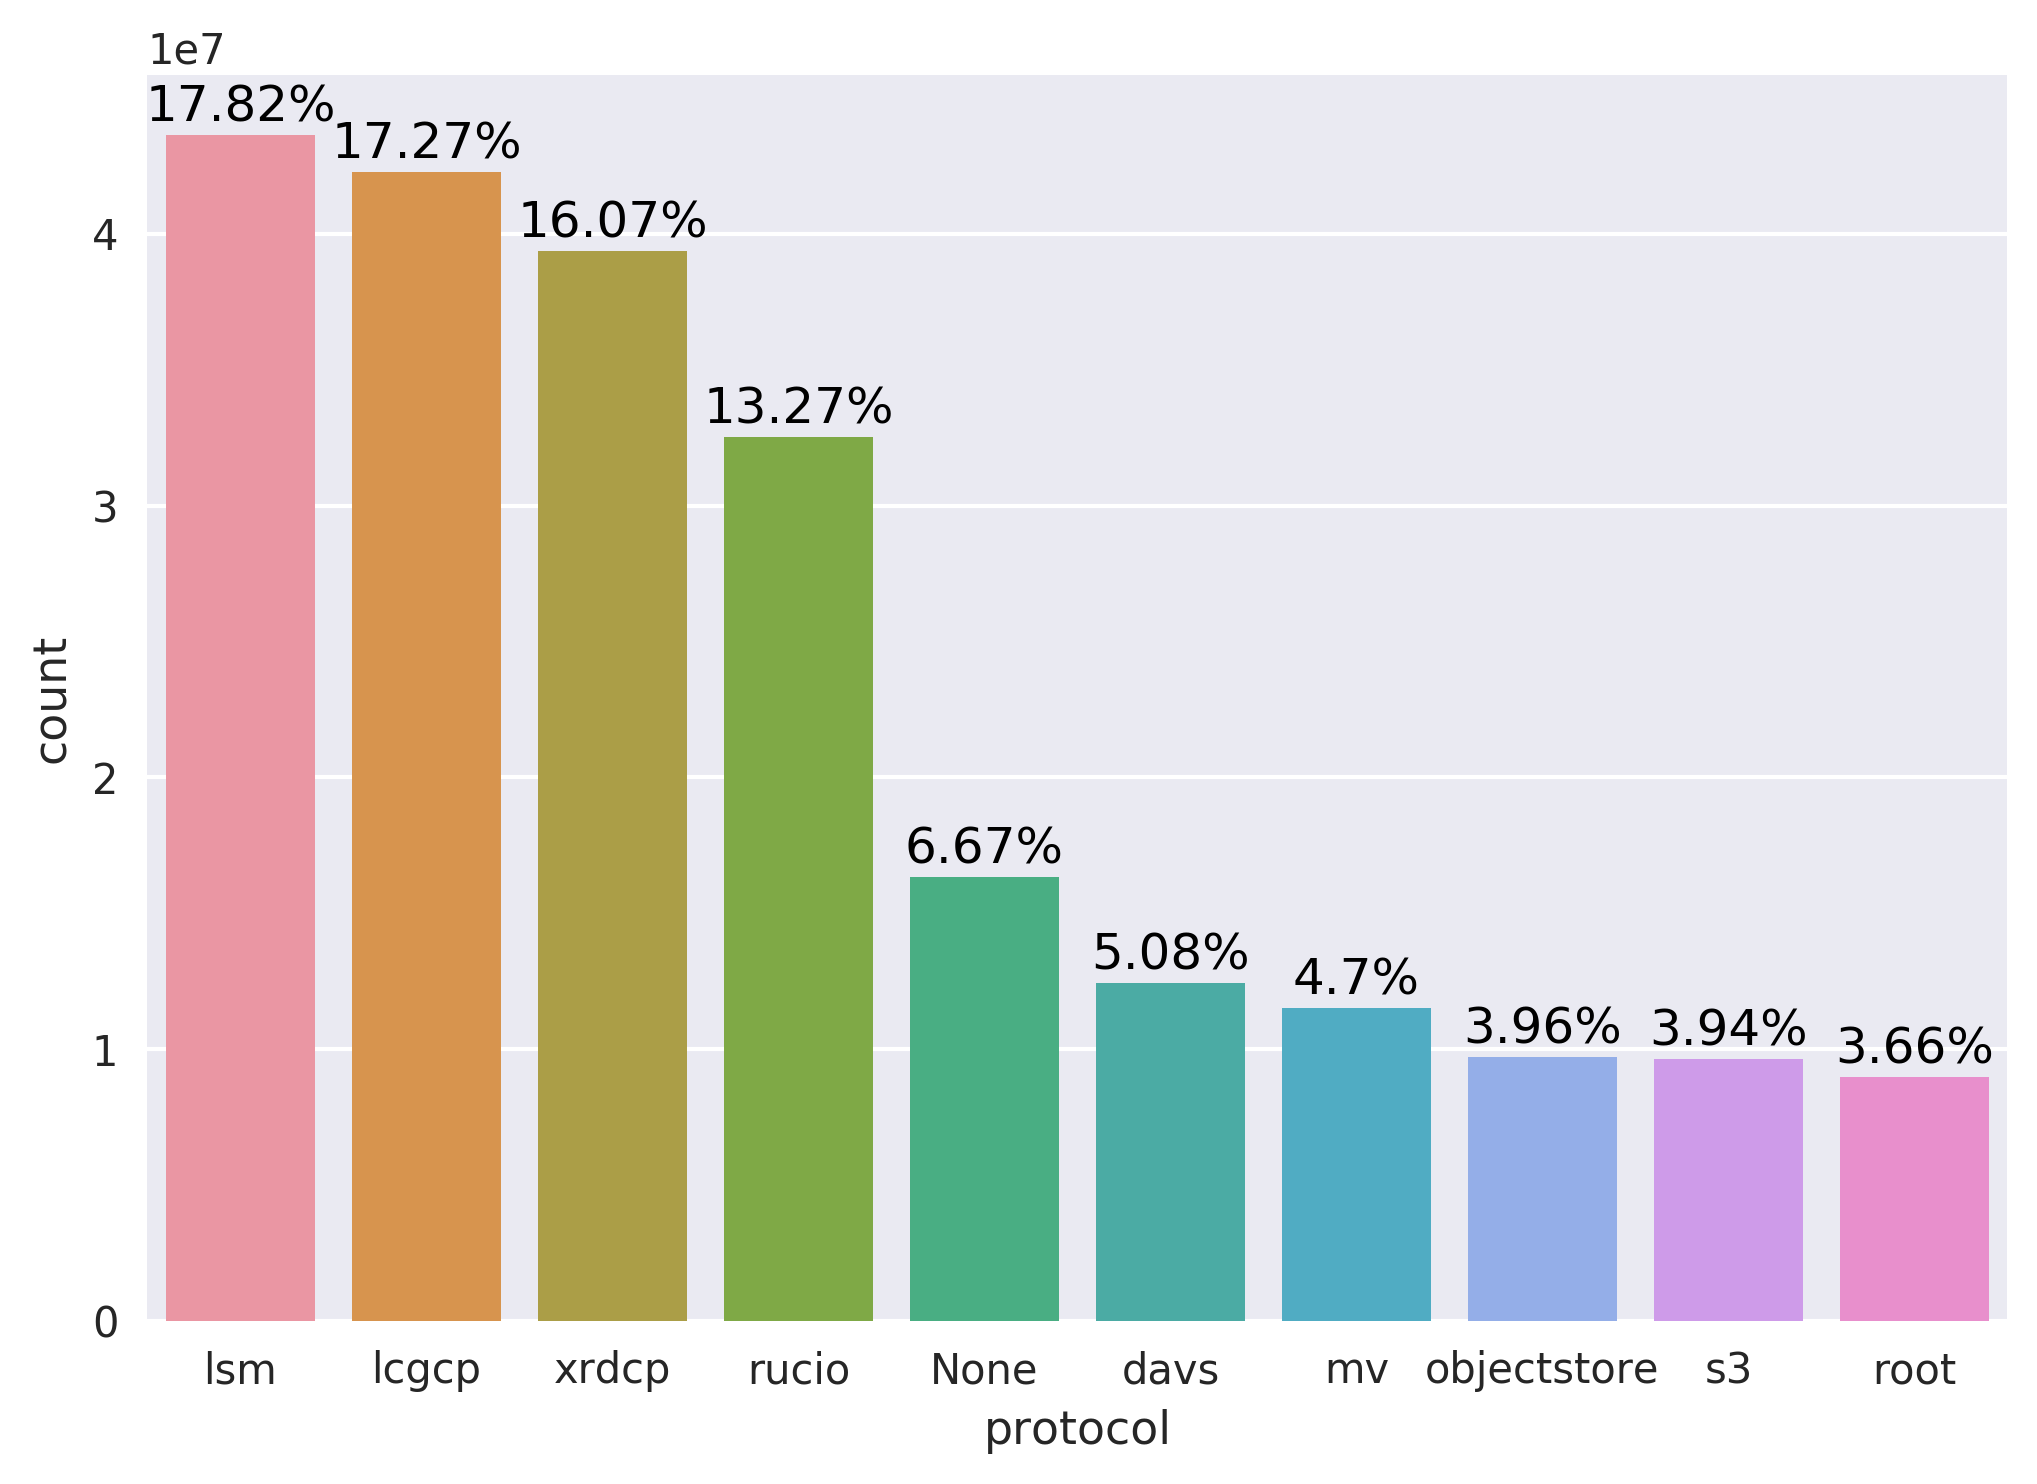

In [101]:
df_plot19['protocol'] = df_plot19.protocol.astype(str)

ax=sns.barplot(x="protocol", y="count", data=df_plot19, ci=None)

for index, row in df_plot19.iterrows():
    ax.text(row.name,row['count']+500000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')

In [47]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT remoteSite, COUNT(*) as count\
                   FROM traces \
                   GROUP BY remoteSite \
                   ORDER BY count DESC)")
df_plot20 = df_ps.limit(10).toPandas()
df_plot20

remoteSite     count  percentage
0  CERN-PROD_ES           18848962  7.70      
1  CERN-PROD_DATADISK     15753003  6.43      
2  BNL-OSG2_DATADISK      14524909  5.93      
3  CERN-PROD_SCRATCHDISK  10863676  4.44      
4  NDGF-T1_DATADISK       8056678   3.29      
5  MWT2_DATADISK          7248154   2.96      
6  INFN-T1_DATADISK       6682972   2.73      
7  IN2P3-CC_DATADISK      6506889   2.66      
8  FZK-LCG2_DATADISK      6285762   2.57      
9  NDGF-T1_SCRATCHDISK    5510575   2.25

[Text(0,0,u'CERN-PROD_ES'),
 Text(0,0,u'CERN-PROD_DATADISK'),
 Text(0,0,u'BNL-OSG2_DATADISK'),
 Text(0,0,u'CERN-PROD_SCRATCHDISK'),
 Text(0,0,u'NDGF-T1_DATADISK'),
 Text(0,0,u'MWT2_DATADISK'),
 Text(0,0,u'INFN-T1_DATADISK'),
 Text(0,0,u'IN2P3-CC_DATADISK'),
 Text(0,0,u'FZK-LCG2_DATADISK'),
 Text(0,0,u'NDGF-T1_SCRATCHDISK')]

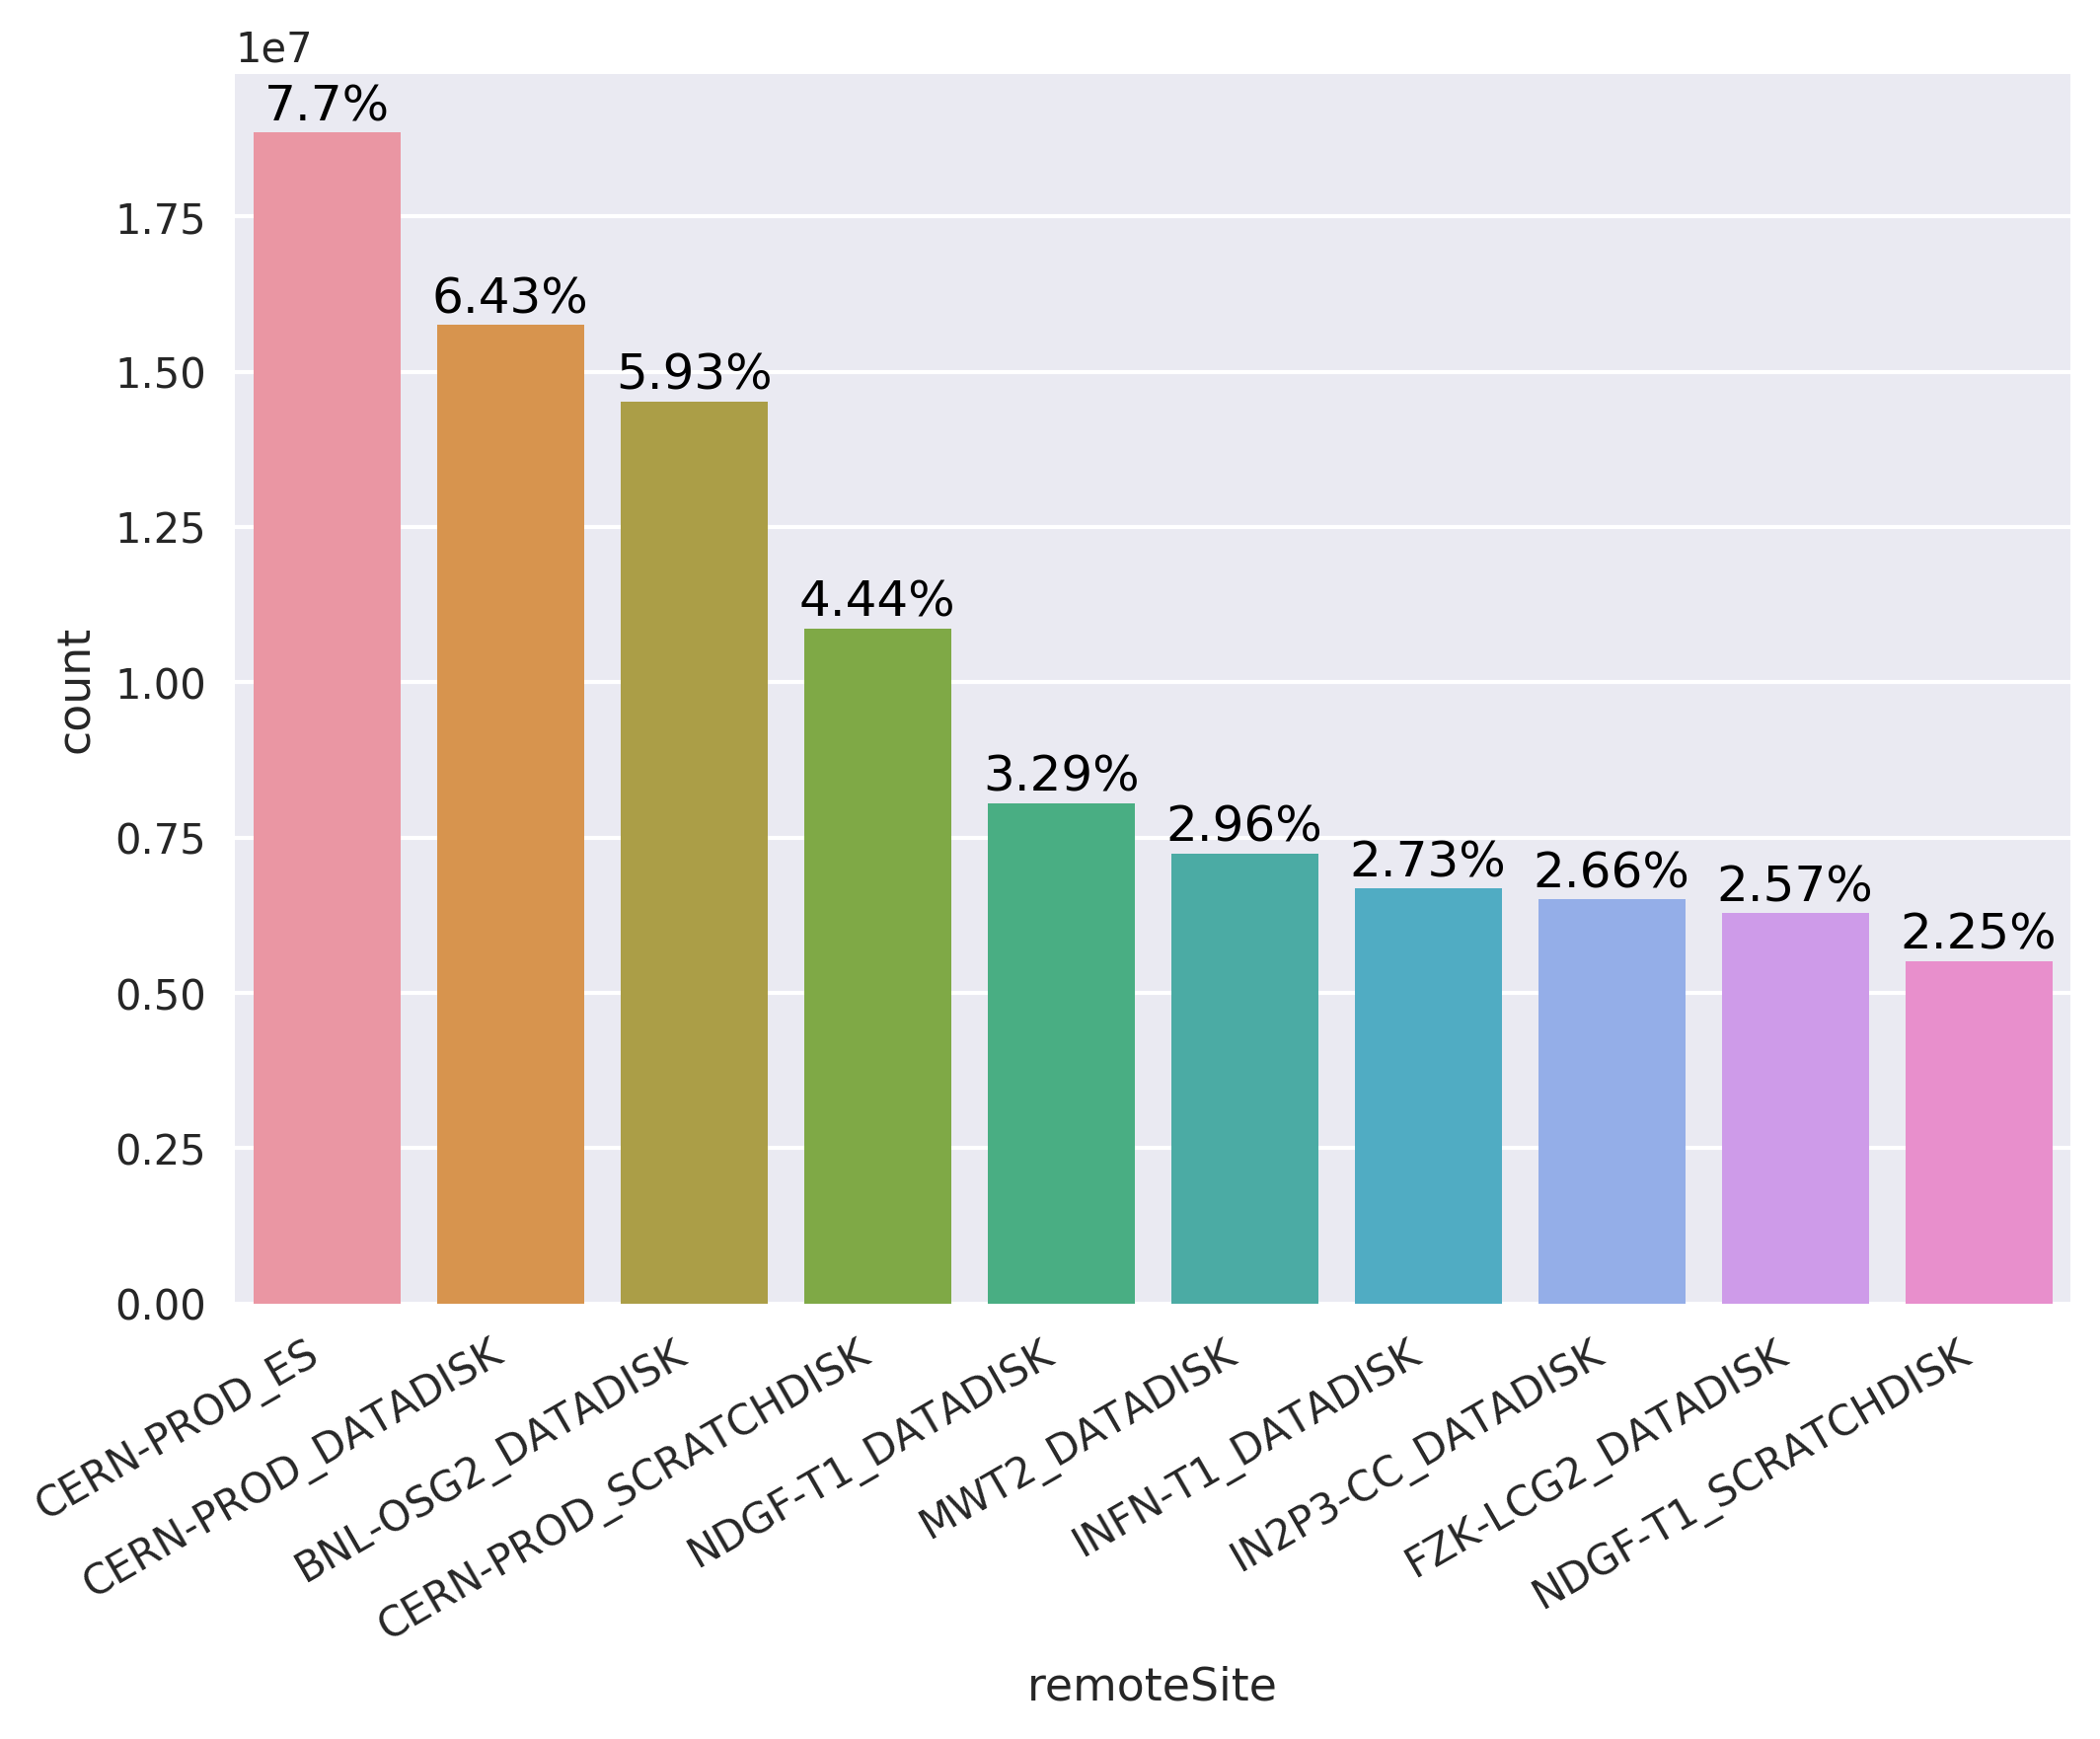

In [102]:
df_plot20['remoteSite'] = df_plot20.remoteSite.astype(str)

ax=sns.barplot(x="remoteSite", y="count", data=df_plot20, ci=None)

for index, row in df_plot20.iterrows():
    ax.text(row.name,row['count']+200000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right")

In [49]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT scope, COUNT(*) as count\
                   FROM traces \
                   GROUP BY scope \
                   ORDER BY count DESC)")
df_plot21 = df_ps.limit(10).toPandas()
df_plot21

scope     count  percentage
0  panda             51670917  21.10     
1  mc15_13TeV        48483829  19.80     
2  mc16_13TeV        35197586  14.37     
3  data17_13TeV      28057033  11.46     
4  transient         18353437  7.49      
5  data16_13TeV      16919593  6.91      
6  data15_13TeV      4026540   1.64      
7  group.phys-gener  3761966   1.54      
8  mc15_14TeV        3256959   1.33      
9  user.gangarbt     2281932   0.93

[Text(0,0,u'panda'),
 Text(0,0,u'mc15_13TeV'),
 Text(0,0,u'mc16_13TeV'),
 Text(0,0,u'data17_13TeV'),
 Text(0,0,u'transient'),
 Text(0,0,u'data16_13TeV'),
 Text(0,0,u'data15_13TeV'),
 Text(0,0,u'group.phys-gener'),
 Text(0,0,u'mc15_14TeV'),
 Text(0,0,u'user.gangarbt')]

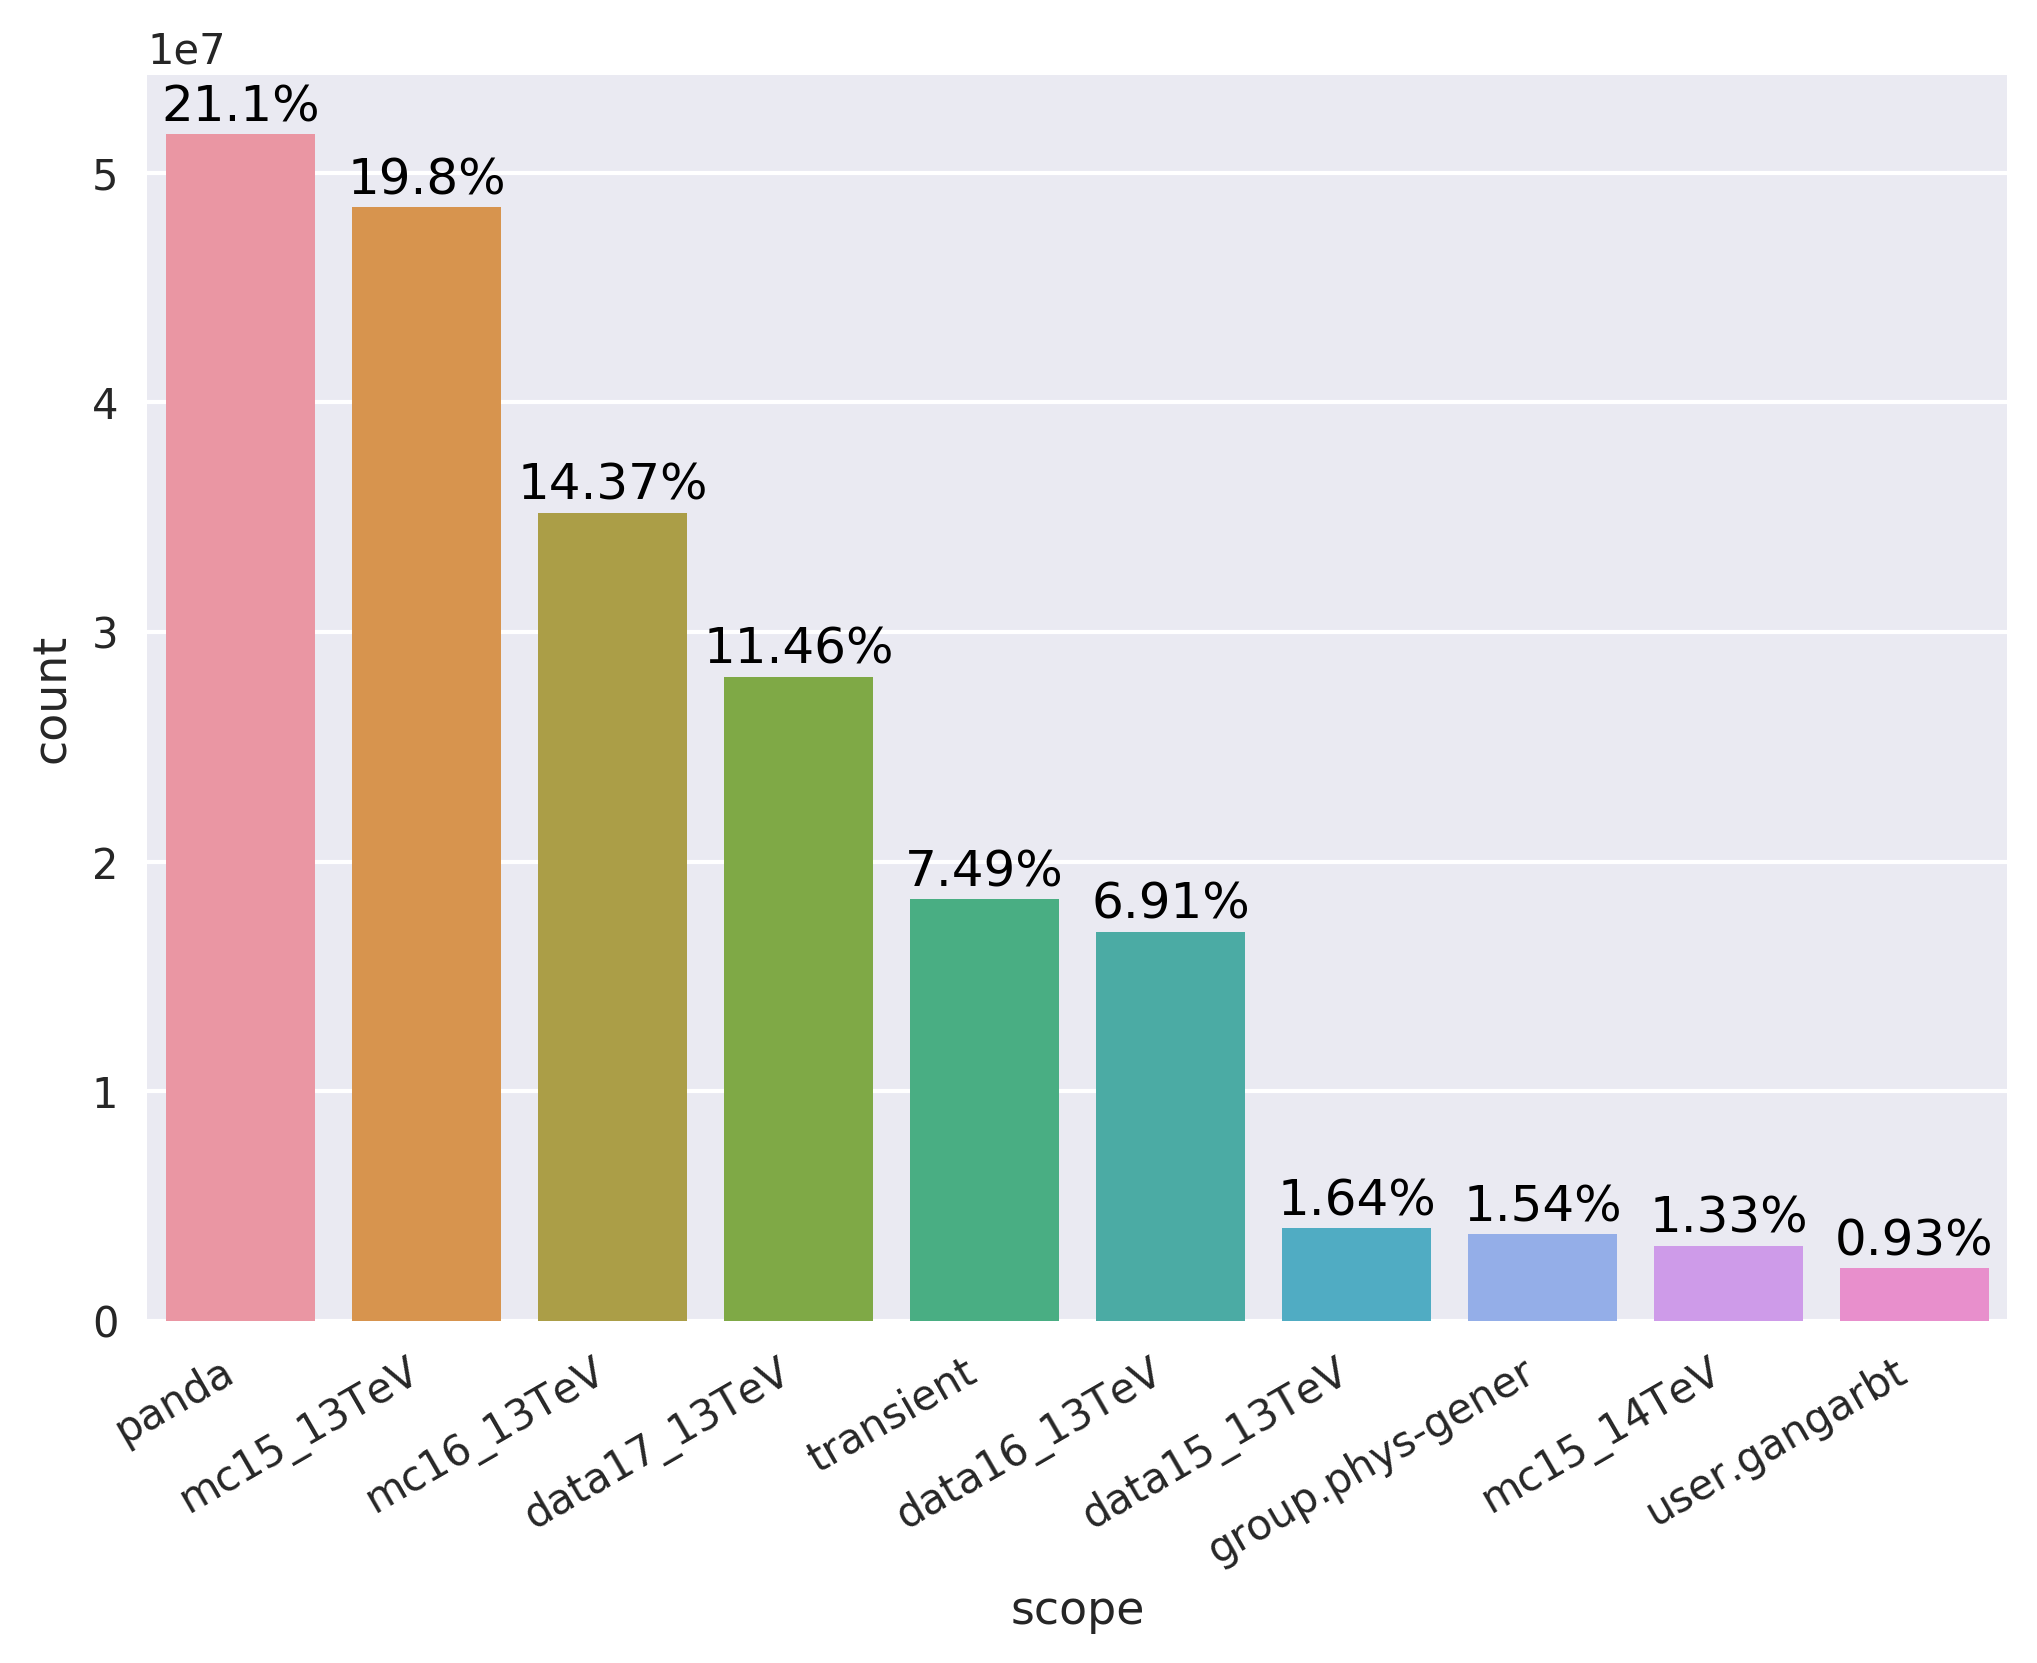

In [103]:
df_plot21['scope'] = df_plot21.scope.astype(str)

ax=sns.barplot(x="scope", y="count", data=df_plot21, ci=None)

for index, row in df_plot21.iterrows():
    ax.text(row.name,row['count']+600000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right")

In [51]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT stateReason, COUNT(*) as count\
                   FROM traces \
                   GROUP BY stateReason \
                   ORDER BY count DESC)")
df_plot22 = df_ps.limit(10).toPandas()
df_plot22

stateReason  \
0  OK                                                                               
1  None                                                                             
2  direct_access                                                                    
3                                                                                   
4  stageOut failed with error='stormSiteMover' object has no attribute 'init_dir'   
5  stageIn failed with error=junk after document element: line 2, column 770        
6  stageIn failed with error=junk after document element: line 2, column 774        
7  stageIn failed with error=junk after document element: line 2, column 771        
8  stageIn failed with error=junk after document element: line 2, column 773        
9  stageIn failed with error=junk after document element: line 2, column 772        

       count  percentage  
0  145763866  59.52       
1  54537249   22.27       
2  35892886   14.66       
3  1303402    0.53        
4  1024993    0.42        
5  651655     0.27        
6  498631     0.20        
7  447946     0.18        
8  332748     0.14        
9  319418     0.13

[Text(0,0,u'OK'),
 Text(0,0,u'None'),
 Text(0,0,u'direct_access'),
 Text(0,0,u''),
 Text(0,0,u"stageOut failed with error='stormSiteMover' object has no attribute 'init_dir'"),
 Text(0,0,u'stageIn failed with error=junk after document element: line 2, column 770'),
 Text(0,0,u'stageIn failed with error=junk after document element: line 2, column 774'),
 Text(0,0,u'stageIn failed with error=junk after document element: line 2, column 771'),
 Text(0,0,u'stageIn failed with error=junk after document element: line 2, column 773'),
 Text(0,0,u'stageIn failed with error=junk after document element: line 2, column 772')]

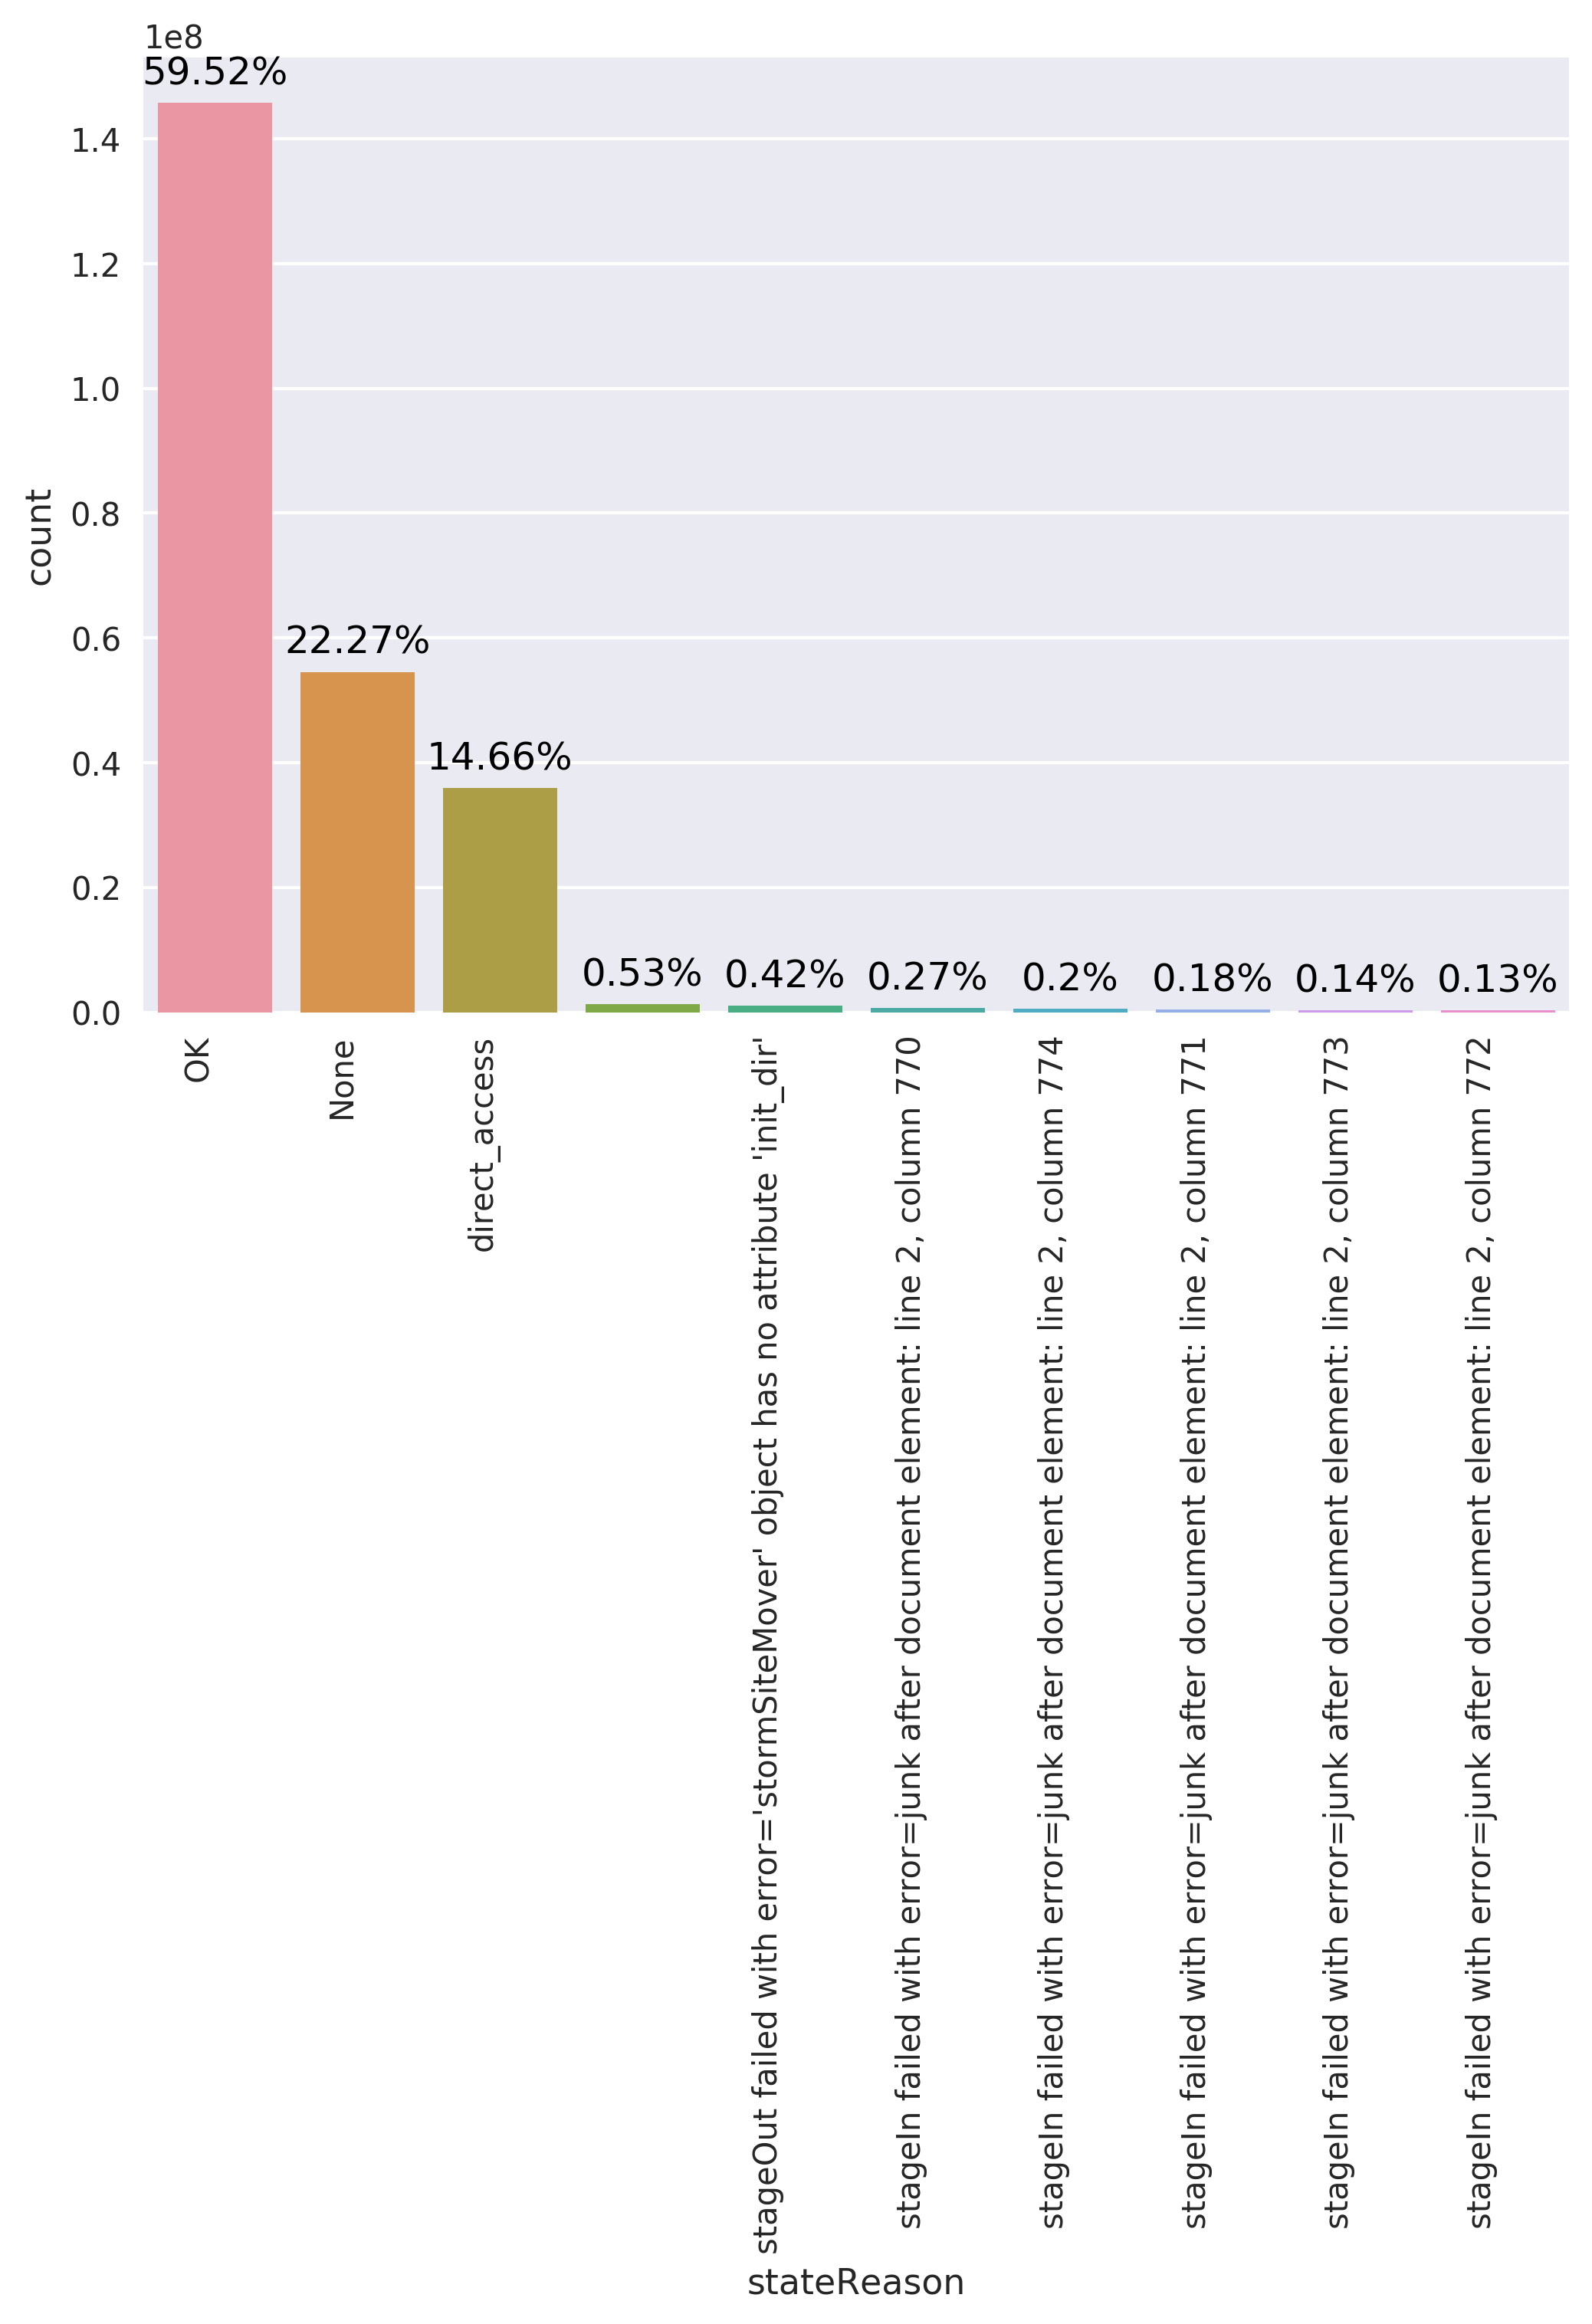

In [105]:
df_plot22['stateReason'] = df_plot22.stateReason.astype(str)

ax=sns.barplot(x="stateReason", y="count", data=df_plot22, ci=None)

for index, row in df_plot22.iterrows():
    ax.text(row.name,row['count']+3000000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, ha="right")

In [53]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT traceId, COUNT(*) as count\
                   FROM traces \
                   GROUP BY traceId \
                   ORDER BY count DESC)")
df_plot23 = df_ps.limit(10).toPandas()
df_plot23

traceId  count  percentage
0  5b9b97f5fdce41958983e2d74ba6e126  4      0.0       
1  de3378c2f11f4f71bf36a9963baaa055  4      0.0       
2  86632446d3134ecb9c0d9d24510ca302  4      0.0       
3  3fa3163c32e1497da4dcb5c32e9b8523  4      0.0       
4  a4f100101d4a46fb91e6182ffae561f1  4      0.0       
5  d5237d256f6b495bb6df2f05d3a87dc9  4      0.0       
6  4bc9c7fcbef14f1db83cf8a56058a9fa  4      0.0       
7  30b5854ed50741488b15f07bf8a81f47  4      0.0       
8  61debc0220b44082a94d3a3eac19886d  4      0.0       
9  55ecff14941344fdad8c35cc83f3592a  4      0.0

In [106]:
#df_plot23['traceId'] = df_plot23.traceId.astype(str)

#ax=sns.barplot(x="traceId", y="count", data=df_plot23, ci=None)

#for index, row in df_plot23.iterrows():
#    ax.text(row.name,row['count']+3000000, "%s%%" % row.percentage , color='black', ha="center")

#ax.set(ylabel='count')

In [107]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT traceIp, COUNT(*) as count\
                   FROM traces \
                   GROUP BY traceIp \
                   ORDER BY count DESC)")
df_plot24 = df_ps.limit(10).toPandas()
df_plot24

traceIp     count  percentage
0  ::ffff:192.108.46.248  10353663  4.23      
1  ::ffff:188.185.76.169  7942029   3.24      
2  ::ffff:129.107.255.11  4582668   1.87      
3  ::ffff:194.36.11.233   2850869   1.16      
4  ::ffff:194.80.35.144   2442131   1.00      
5  ::ffff:90.147.67.99    2341946   0.96      
6  ::ffff:194.36.11.234   2071118   0.85      
7  ::ffff:206.12.1.201    2008966   0.82      
8  ::ffff:192.5.207.199   1959683   0.80      
9  ::ffff:134.76.97.98    1936282   0.79

[Text(0,0,u'::ffff:192.108.46.248'),
 Text(0,0,u'::ffff:188.185.76.169'),
 Text(0,0,u'::ffff:129.107.255.11'),
 Text(0,0,u'::ffff:194.36.11.233'),
 Text(0,0,u'::ffff:194.80.35.144'),
 Text(0,0,u'::ffff:90.147.67.99'),
 Text(0,0,u'::ffff:194.36.11.234'),
 Text(0,0,u'::ffff:206.12.1.201'),
 Text(0,0,u'::ffff:192.5.207.199'),
 Text(0,0,u'::ffff:134.76.97.98')]

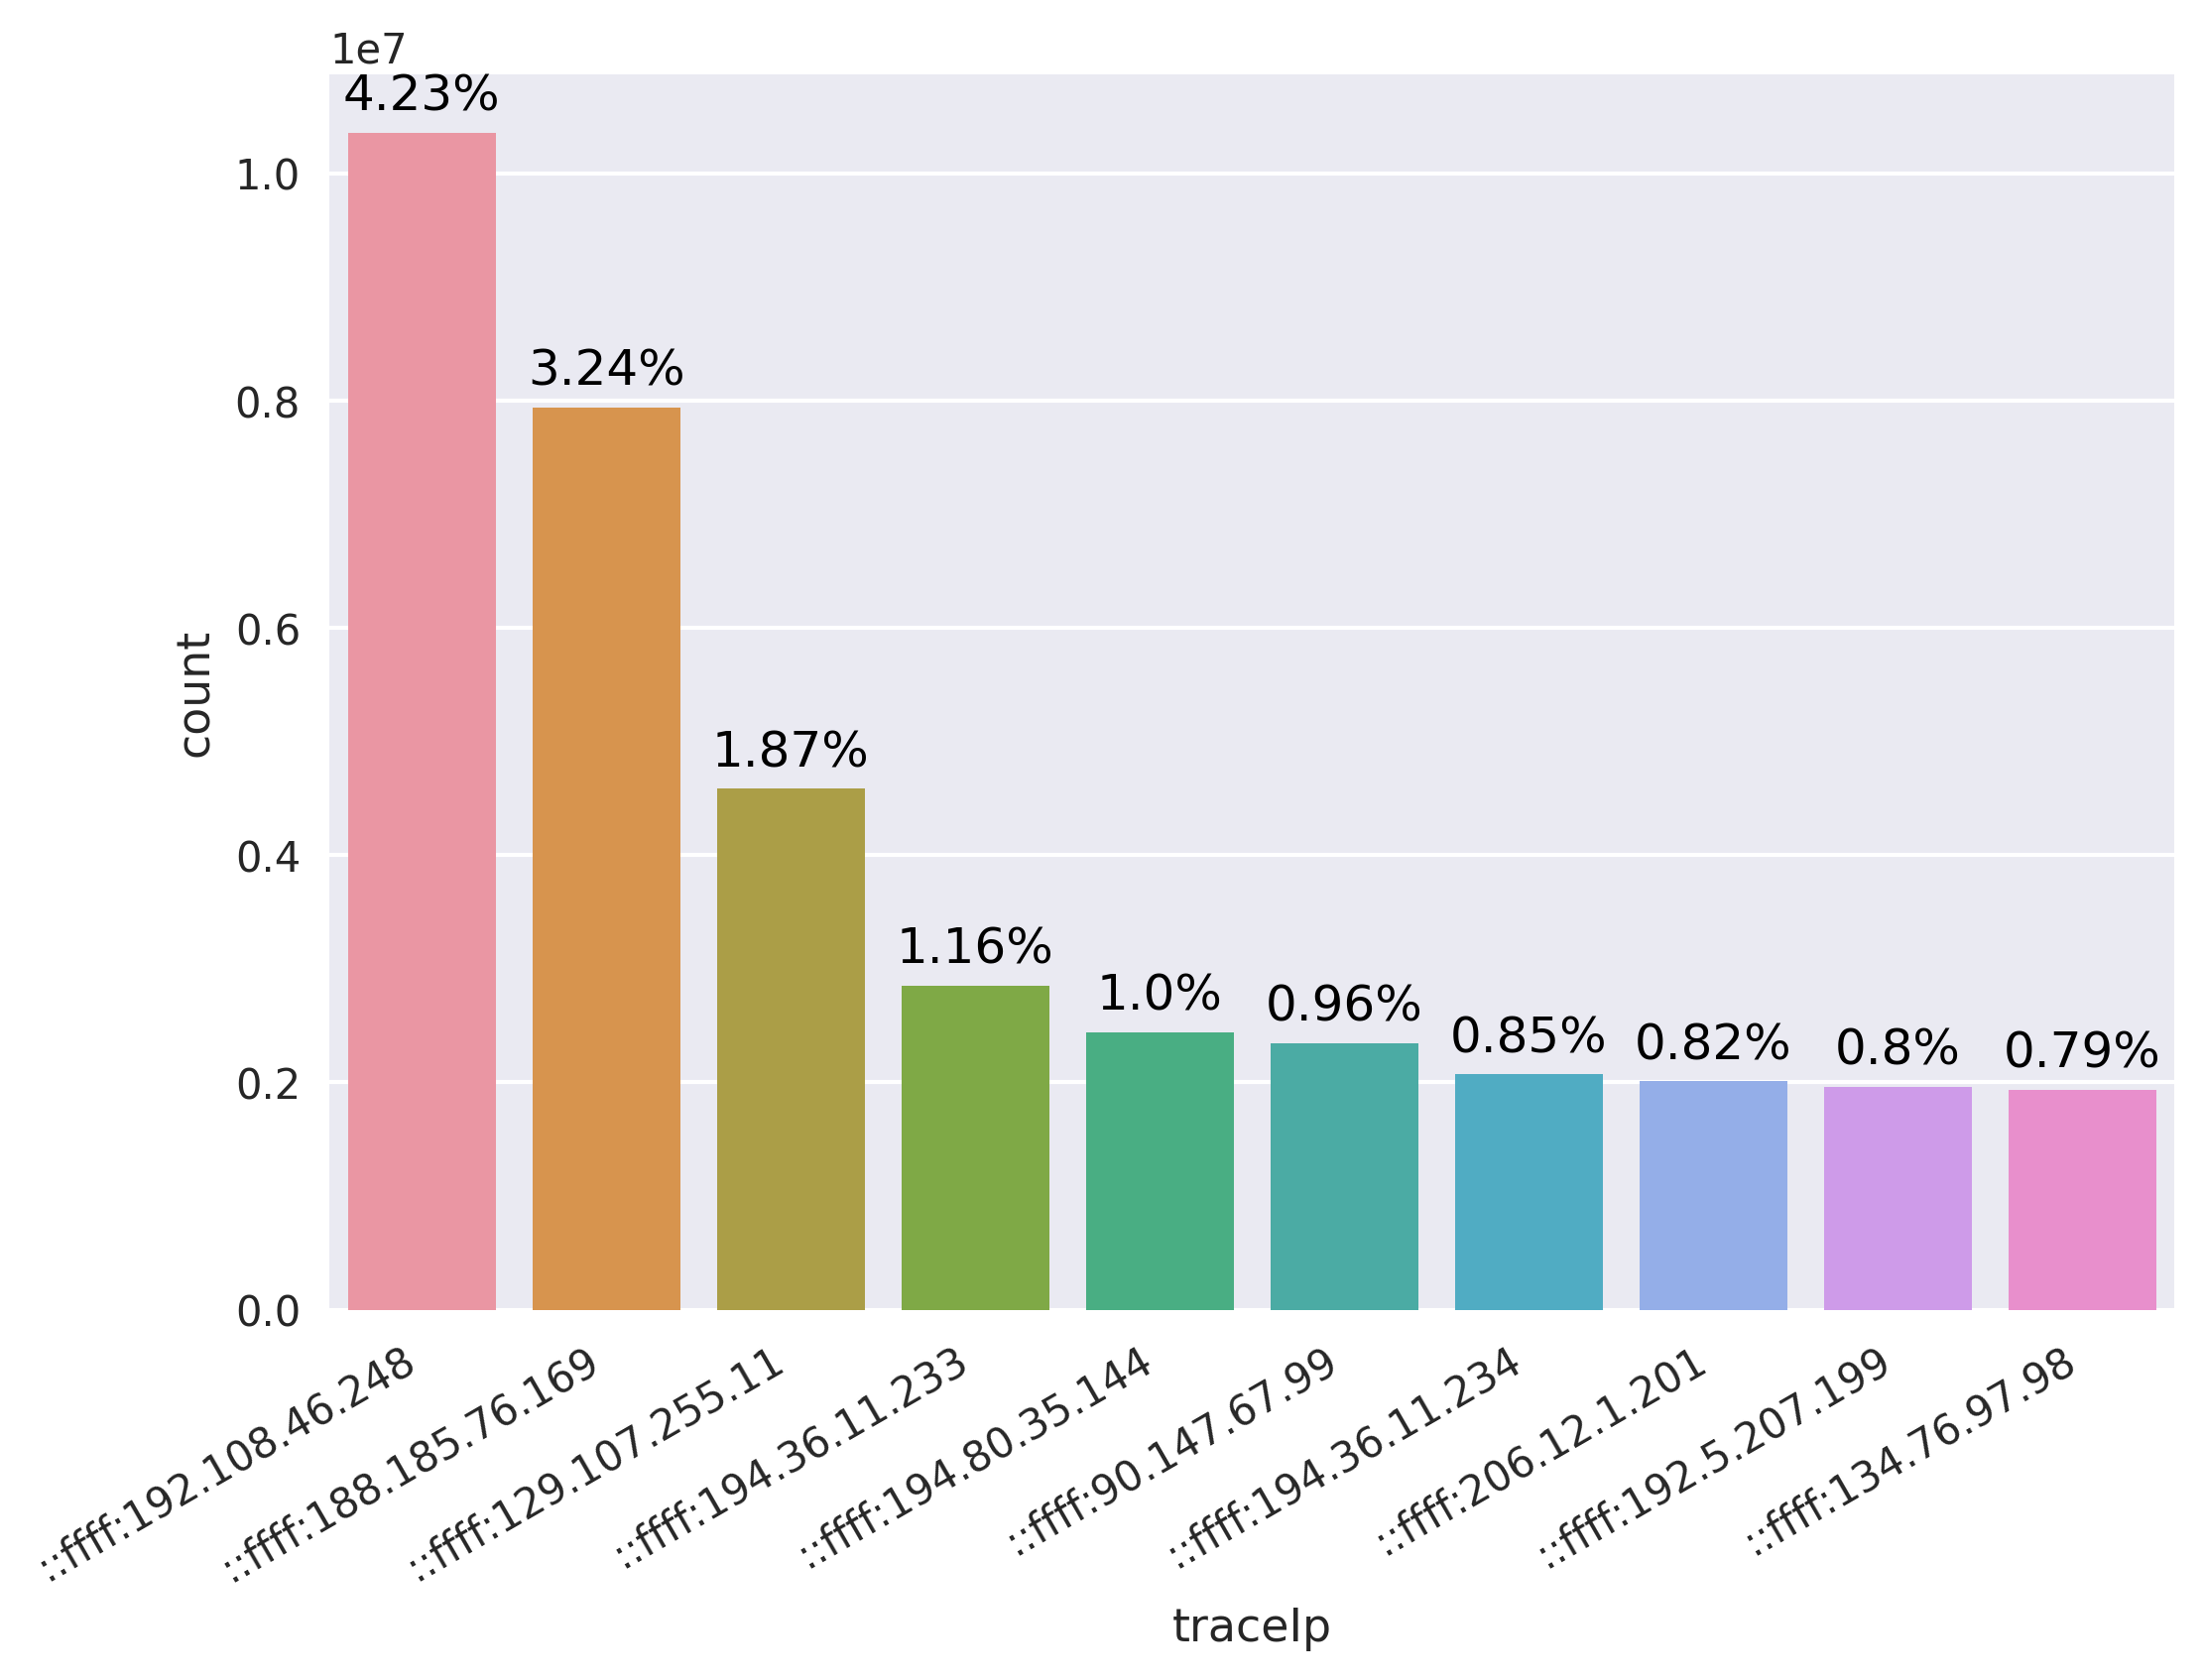

In [116]:
df_plot24['traceIp'] = df_plot24.traceIp.astype(str)

ax=sns.barplot(x="traceIp", y="count", data=df_plot24, ci=None)

for index, row in df_plot24.iterrows():
    ax.text(row.name,row['count']+200000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right")

In [109]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT url, COUNT(*) as count\
                   FROM traces \
                   GROUP BY url \
                   ORDER BY count DESC)")
df_plot25 = df_ps.limit(10).toPandas()
df_plot25

url  \
0  None                                                                                                                                                 
1  panda.0410005528.528548.lib._13680459.13154307335.lib.tgz                                                                                            
2  panda.0423121634.556836.lib._13808637.13269327961.lib.tgz                                                                                            
3  srm://gk03.atlas-swt2.org:8443/srm/v2/server?SFN=/xrd/atlasscratchdisk/rucio/panda/4b/65/panda.0410013753.843837.lib._13680459.13154457848.lib.tgz   
4  root://fax.mwt2.org:1094//pnfs/uchicago.edu/atlasdatadisk/rucio/mc15_13TeV/ed/68/AOD.05536542._000001.pool.root.1                                    
5  group.phys-gener.madgraph5223p4.363608.MGPy8EG_N30NLO_Wenu_Ht140_280_13TeV.TXT.mc15_v1._00001.tar.gz                                                 
6  root://xrootd.echo.stfc.ac.uk:1094/atlas:scratchdisk/rucio/panda/42/21/panda.0410014101.665209.lib._13680459.13154463632.lib.tgz                     
7  group.phys-gener.madgraph5232p1.363656.MGPy8EG_N30NLO_Wtaunu_Ht140_280_13TeV.TXT.mc15_v1._00001.tar.gz                                               
8  group.phys-gener.madgraph5232p1.363653.MGPy8EG_N30NLO_Wtaunu_Ht70_140_13TeV.TXT.mc15_v1._00001.tar.gz                                                
9  group.phys-gener.powheg_V2.345054.WplvH125J_MINLO_VpT_13TeV.TXT.mc15_v1._00001.tar.gz                                                                

      count  percentage  
0  63714036  26.01       
1  96936     0.04        
2  45435     0.02        
3  40066     0.02        
4  38986     0.02        
5  36717     0.01        
6  35940     0.01        
7  35205     0.01        
8  34621     0.01        
9  31006     0.01

[Text(0,0,u'None'),
 Text(0,0,u'panda.0410005528.528548.lib._13680459.13154307335.lib.tgz'),
 Text(0,0,u'panda.0423121634.556836.lib._13808637.13269327961.lib.tgz'),
 Text(0,0,u'srm://gk03.atlas-swt2.org:8443/srm/v2/server?SFN=/xrd/atlasscratchdisk/rucio/panda/4b/65/panda.0410013753.843837.lib._13680459.13154457848.lib.tgz'),
 Text(0,0,u'root://fax.mwt2.org:1094//pnfs/uchicago.edu/atlasdatadisk/rucio/mc15_13TeV/ed/68/AOD.05536542._000001.pool.root.1'),
 Text(0,0,u'group.phys-gener.madgraph5223p4.363608.MGPy8EG_N30NLO_Wenu_Ht140_280_13TeV.TXT.mc15_v1._00001.tar.gz'),
 Text(0,0,u'root://xrootd.echo.stfc.ac.uk:1094/atlas:scratchdisk/rucio/panda/42/21/panda.0410014101.665209.lib._13680459.13154463632.lib.tgz'),
 Text(0,0,u'group.phys-gener.madgraph5232p1.363656.MGPy8EG_N30NLO_Wtaunu_Ht140_280_13TeV.TXT.mc15_v1._00001.tar.gz'),
 Text(0,0,u'group.phys-gener.madgraph5232p1.363653.MGPy8EG_N30NLO_Wtaunu_Ht70_140_13TeV.TXT.mc15_v1._00001.tar.gz'),
 Text(0,0,u'group.phys-gener.powheg_V2.345054.Wp

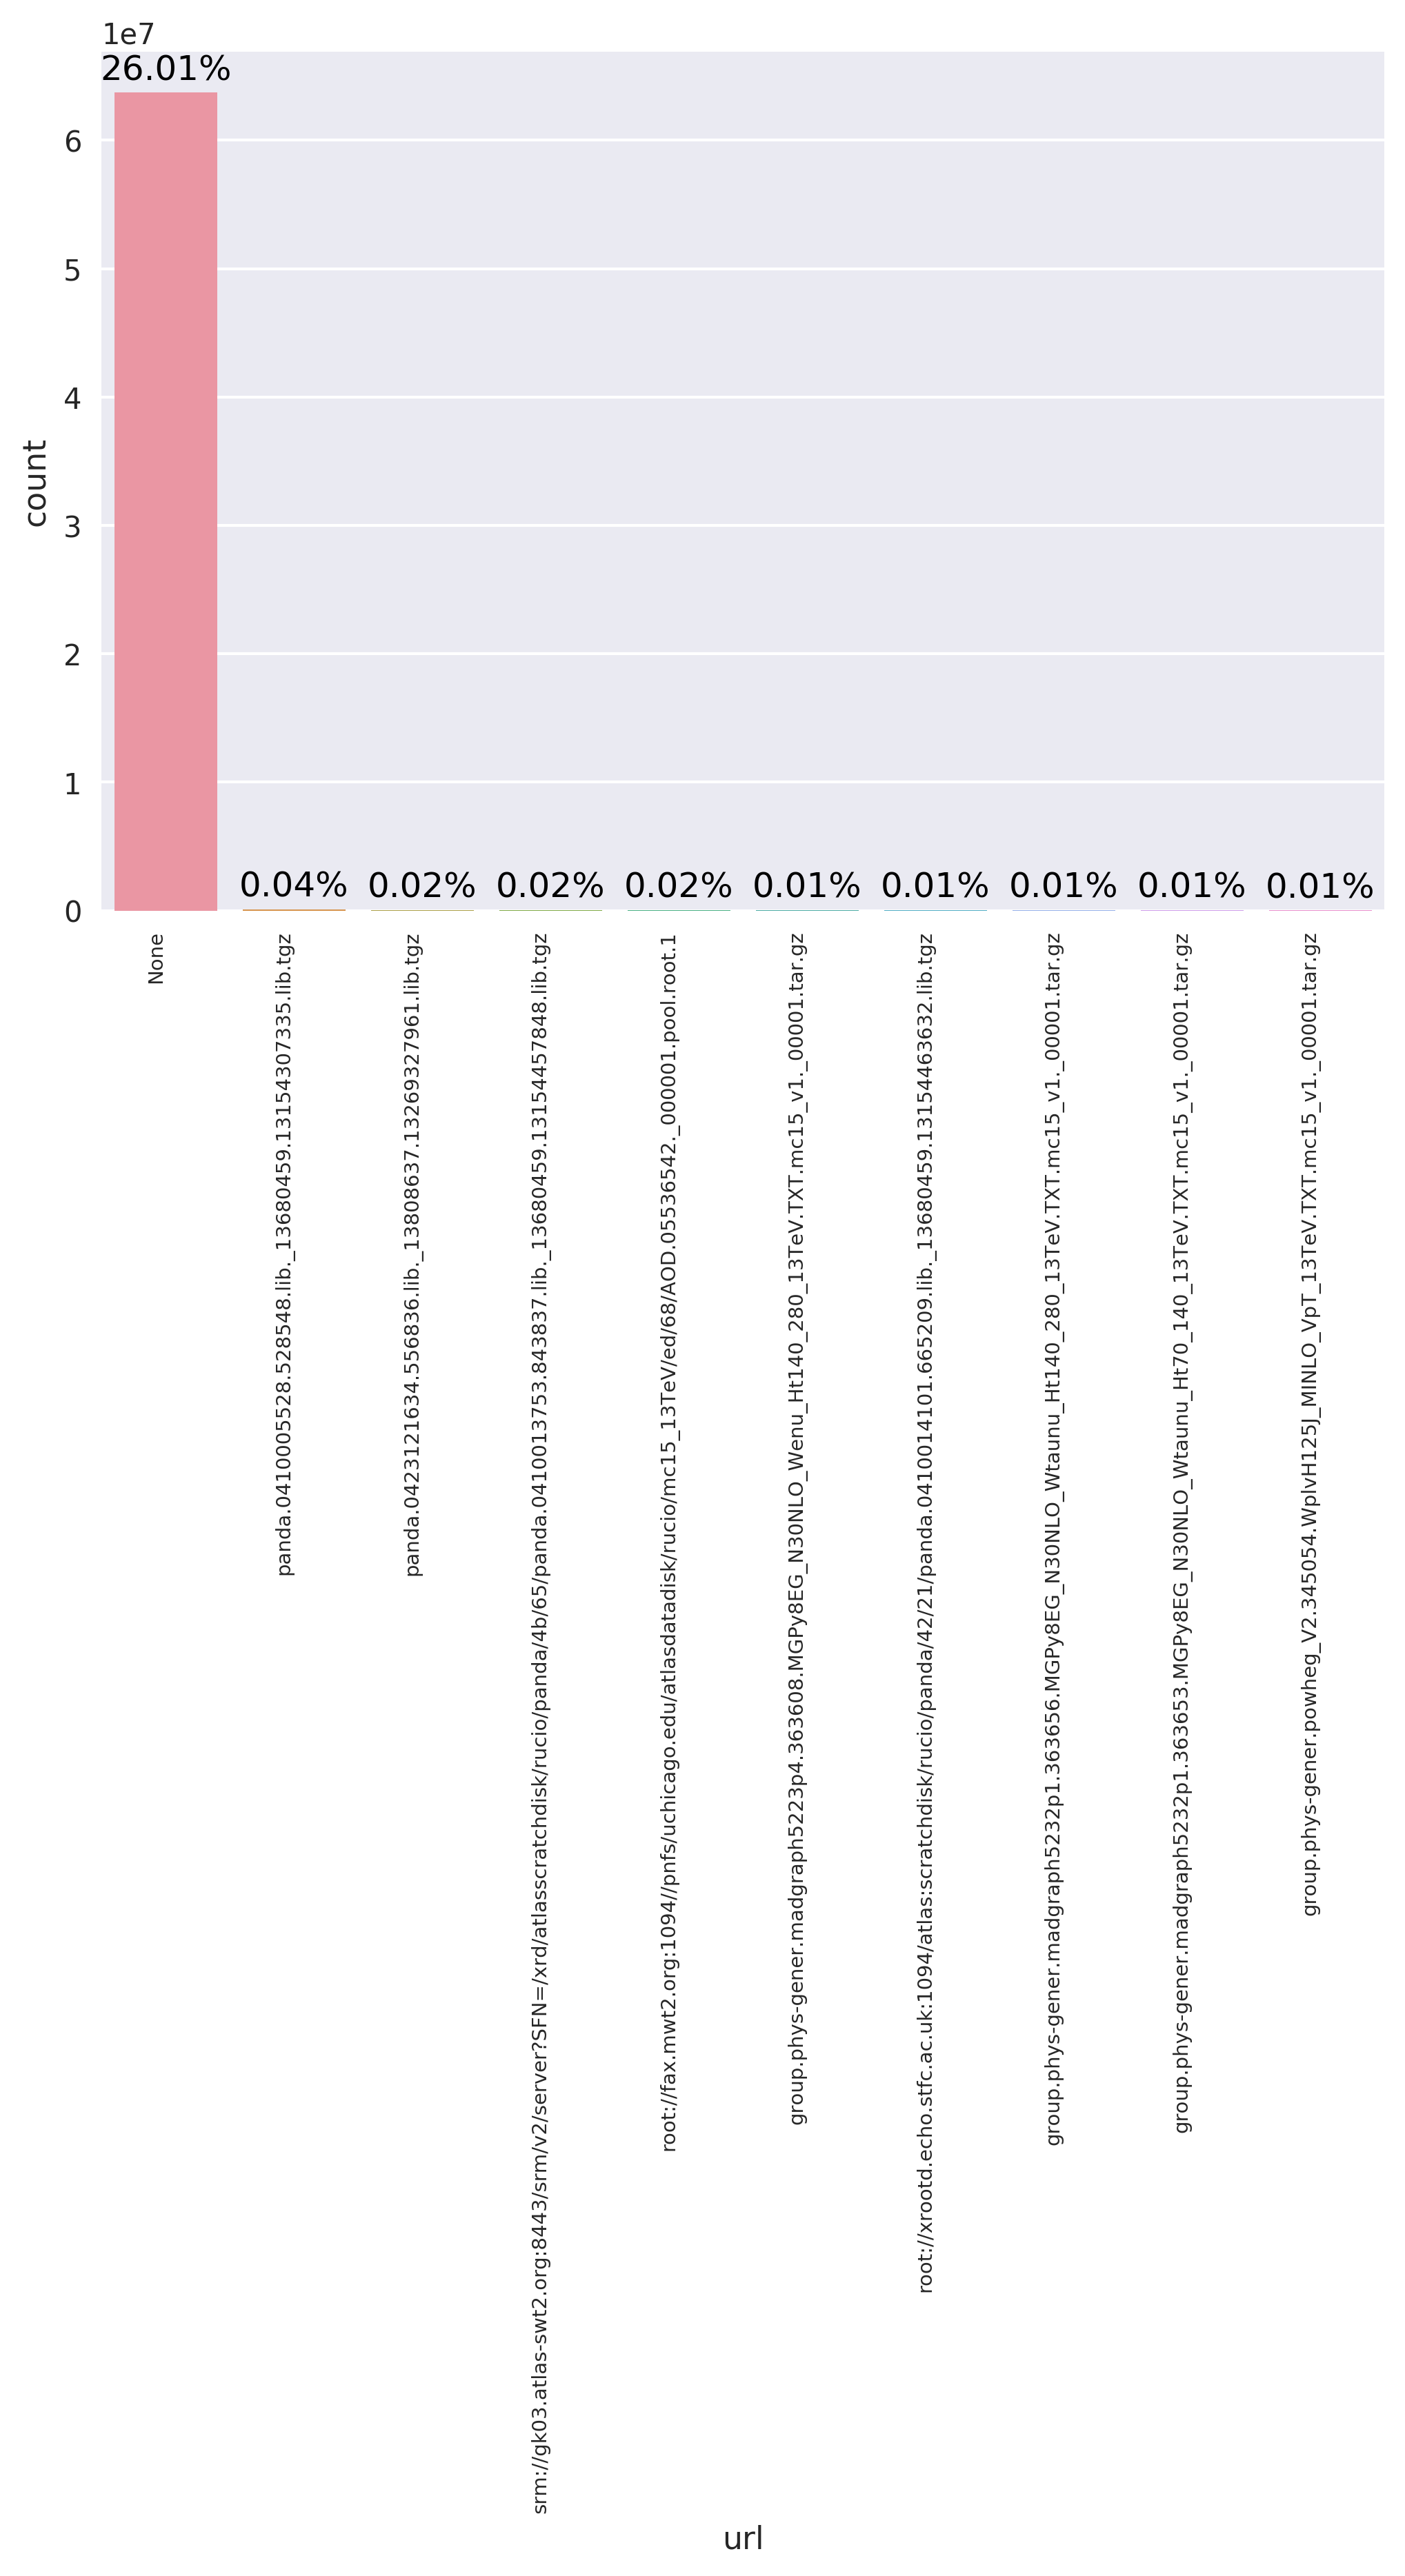

In [118]:
df_plot25['url'] = df_plot25.url.astype(str)

ax=sns.barplot(x="url", y="count", data=df_plot25, ci=None)

for index, row in df_plot25.iterrows():
    ax.text(row.name,row['count']+1000000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, ha="right", fontsize=7)

In [111]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT usr, COUNT(*) as count\
                   FROM traces \
                   GROUP BY usr \
                   ORDER BY count DESC)")
df_plot26 = df_ps.limit(10).toPandas()
df_plot26

usr     count  percentage
0  None                              54509526  22.26     
1  42862b9cb294985191f1a5eb7f303218  32099742  13.11     
2  ed6e07db84fe44b15a8544942b81b688  31060460  12.68     
3  b47e43c556f4cce8bd000cef43a58ddc  7751862   3.17      
4  d5081bac388de4604adc174ae8fde8c7  5930131   2.42      
5  effc7d0e3fca58feeef8d153c6df4f00  4558879   1.86      
6  2c87451678a7ccabb66e6377771436d8  3367155   1.37      
7  487dda548c46c542c1c35bd24a7cde31  2552295   1.04      
8  b706fe7c2e28b236849fb6639de22406  2244012   0.92      
9  4c3c1c7d2a7650b4a036bfb939beb95a  2123047   0.87

[Text(0,0,u'None'),
 Text(0,0,u'42862b9cb294985191f1a5eb7f303218'),
 Text(0,0,u'ed6e07db84fe44b15a8544942b81b688'),
 Text(0,0,u'b47e43c556f4cce8bd000cef43a58ddc'),
 Text(0,0,u'd5081bac388de4604adc174ae8fde8c7'),
 Text(0,0,u'effc7d0e3fca58feeef8d153c6df4f00'),
 Text(0,0,u'2c87451678a7ccabb66e6377771436d8'),
 Text(0,0,u'487dda548c46c542c1c35bd24a7cde31'),
 Text(0,0,u'b706fe7c2e28b236849fb6639de22406'),
 Text(0,0,u'4c3c1c7d2a7650b4a036bfb939beb95a')]

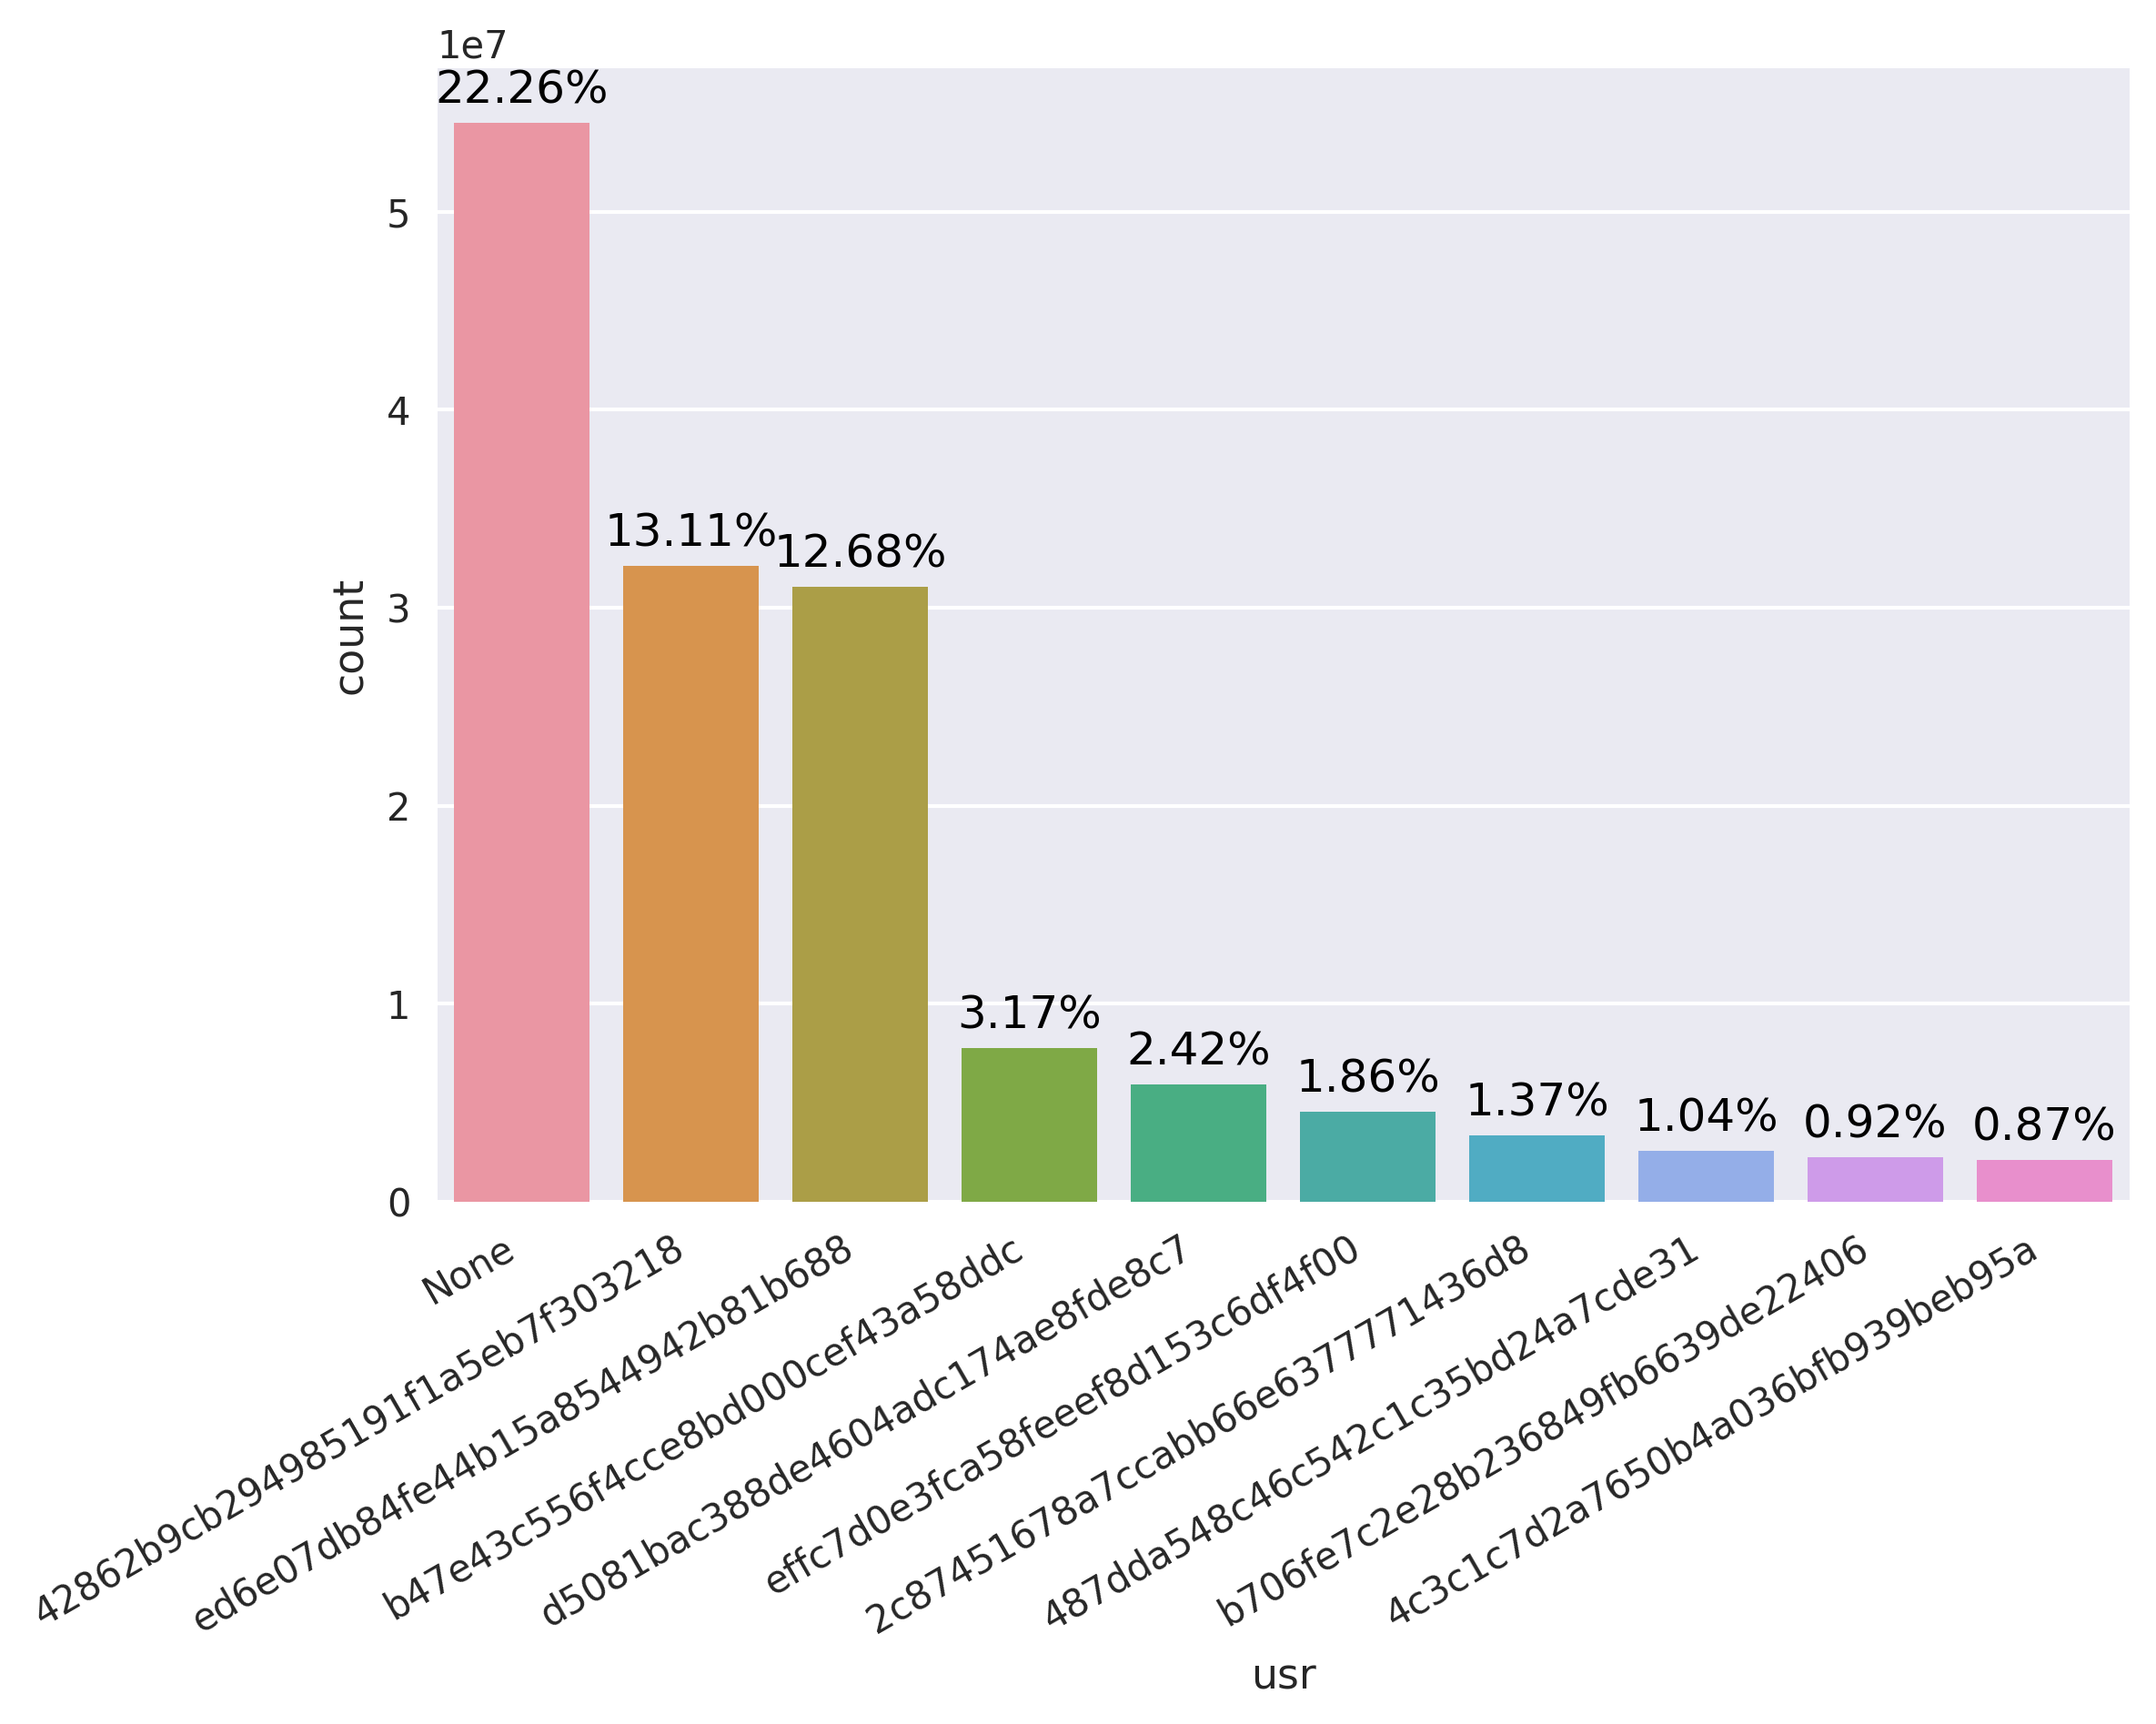

In [119]:
df_plot26['usr'] = df_plot26.usr.astype(str)

ax=sns.barplot(x="usr", y="count", data=df_plot26, ci=None)

for index, row in df_plot26.iterrows():
    ax.text(row.name,row['count']+1000000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right")

In [113]:
df_ps = spark.sql("SELECT *, ROUND((count/244917469)*100,2) as percentage FROM(\
                   SELECT usrdn, COUNT(*) as count\
                   FROM traces \
                   GROUP BY usrdn \
                   ORDER BY count DESC)")
df_plot27 = df_ps.limit(10).toPandas()
df_plot27

usrdn  \
0  None                                                                                            
1  atlas-dpd-production                                                                            
2  dsouth                                                                                          
3  /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=bcarlson/CN=736735/CN=Ben Carlson/CN=961047607      
4  /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=gangarbt/CN=660595/CN=Robot: Ganga Robot/CN=proxy   
5  mughetto                                                                                        
6  mnegrini                                                                                        
7  /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=bcarlson/CN=736735/CN=Ben Carlson/CN=852245750      
8  /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=bcarlson/CN=736735/CN=Ben Carlson/CN=859610159      
9  dhirsch                                                                                         

      count  percentage  
0  46198012  18.86       
1  33913210  13.85       
2  33342317  13.61       
3  8100452   3.31        
4  6040322   2.47        
5  4747102   1.94        
6  3418303   1.40        
7  2773932   1.13        
8  2310633   0.94        
9  2273825   0.93

[Text(0,0,u'None'),
 Text(0,0,u'atlas-dpd-production'),
 Text(0,0,u'dsouth'),
 Text(0,0,u'/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=bcarlson/CN=736735/CN=Ben Carlson/CN=961047607'),
 Text(0,0,u'/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=gangarbt/CN=660595/CN=Robot: Ganga Robot/CN=proxy'),
 Text(0,0,u'mughetto'),
 Text(0,0,u'mnegrini'),
 Text(0,0,u'/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=bcarlson/CN=736735/CN=Ben Carlson/CN=852245750'),
 Text(0,0,u'/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=bcarlson/CN=736735/CN=Ben Carlson/CN=859610159'),
 Text(0,0,u'dhirsch')]

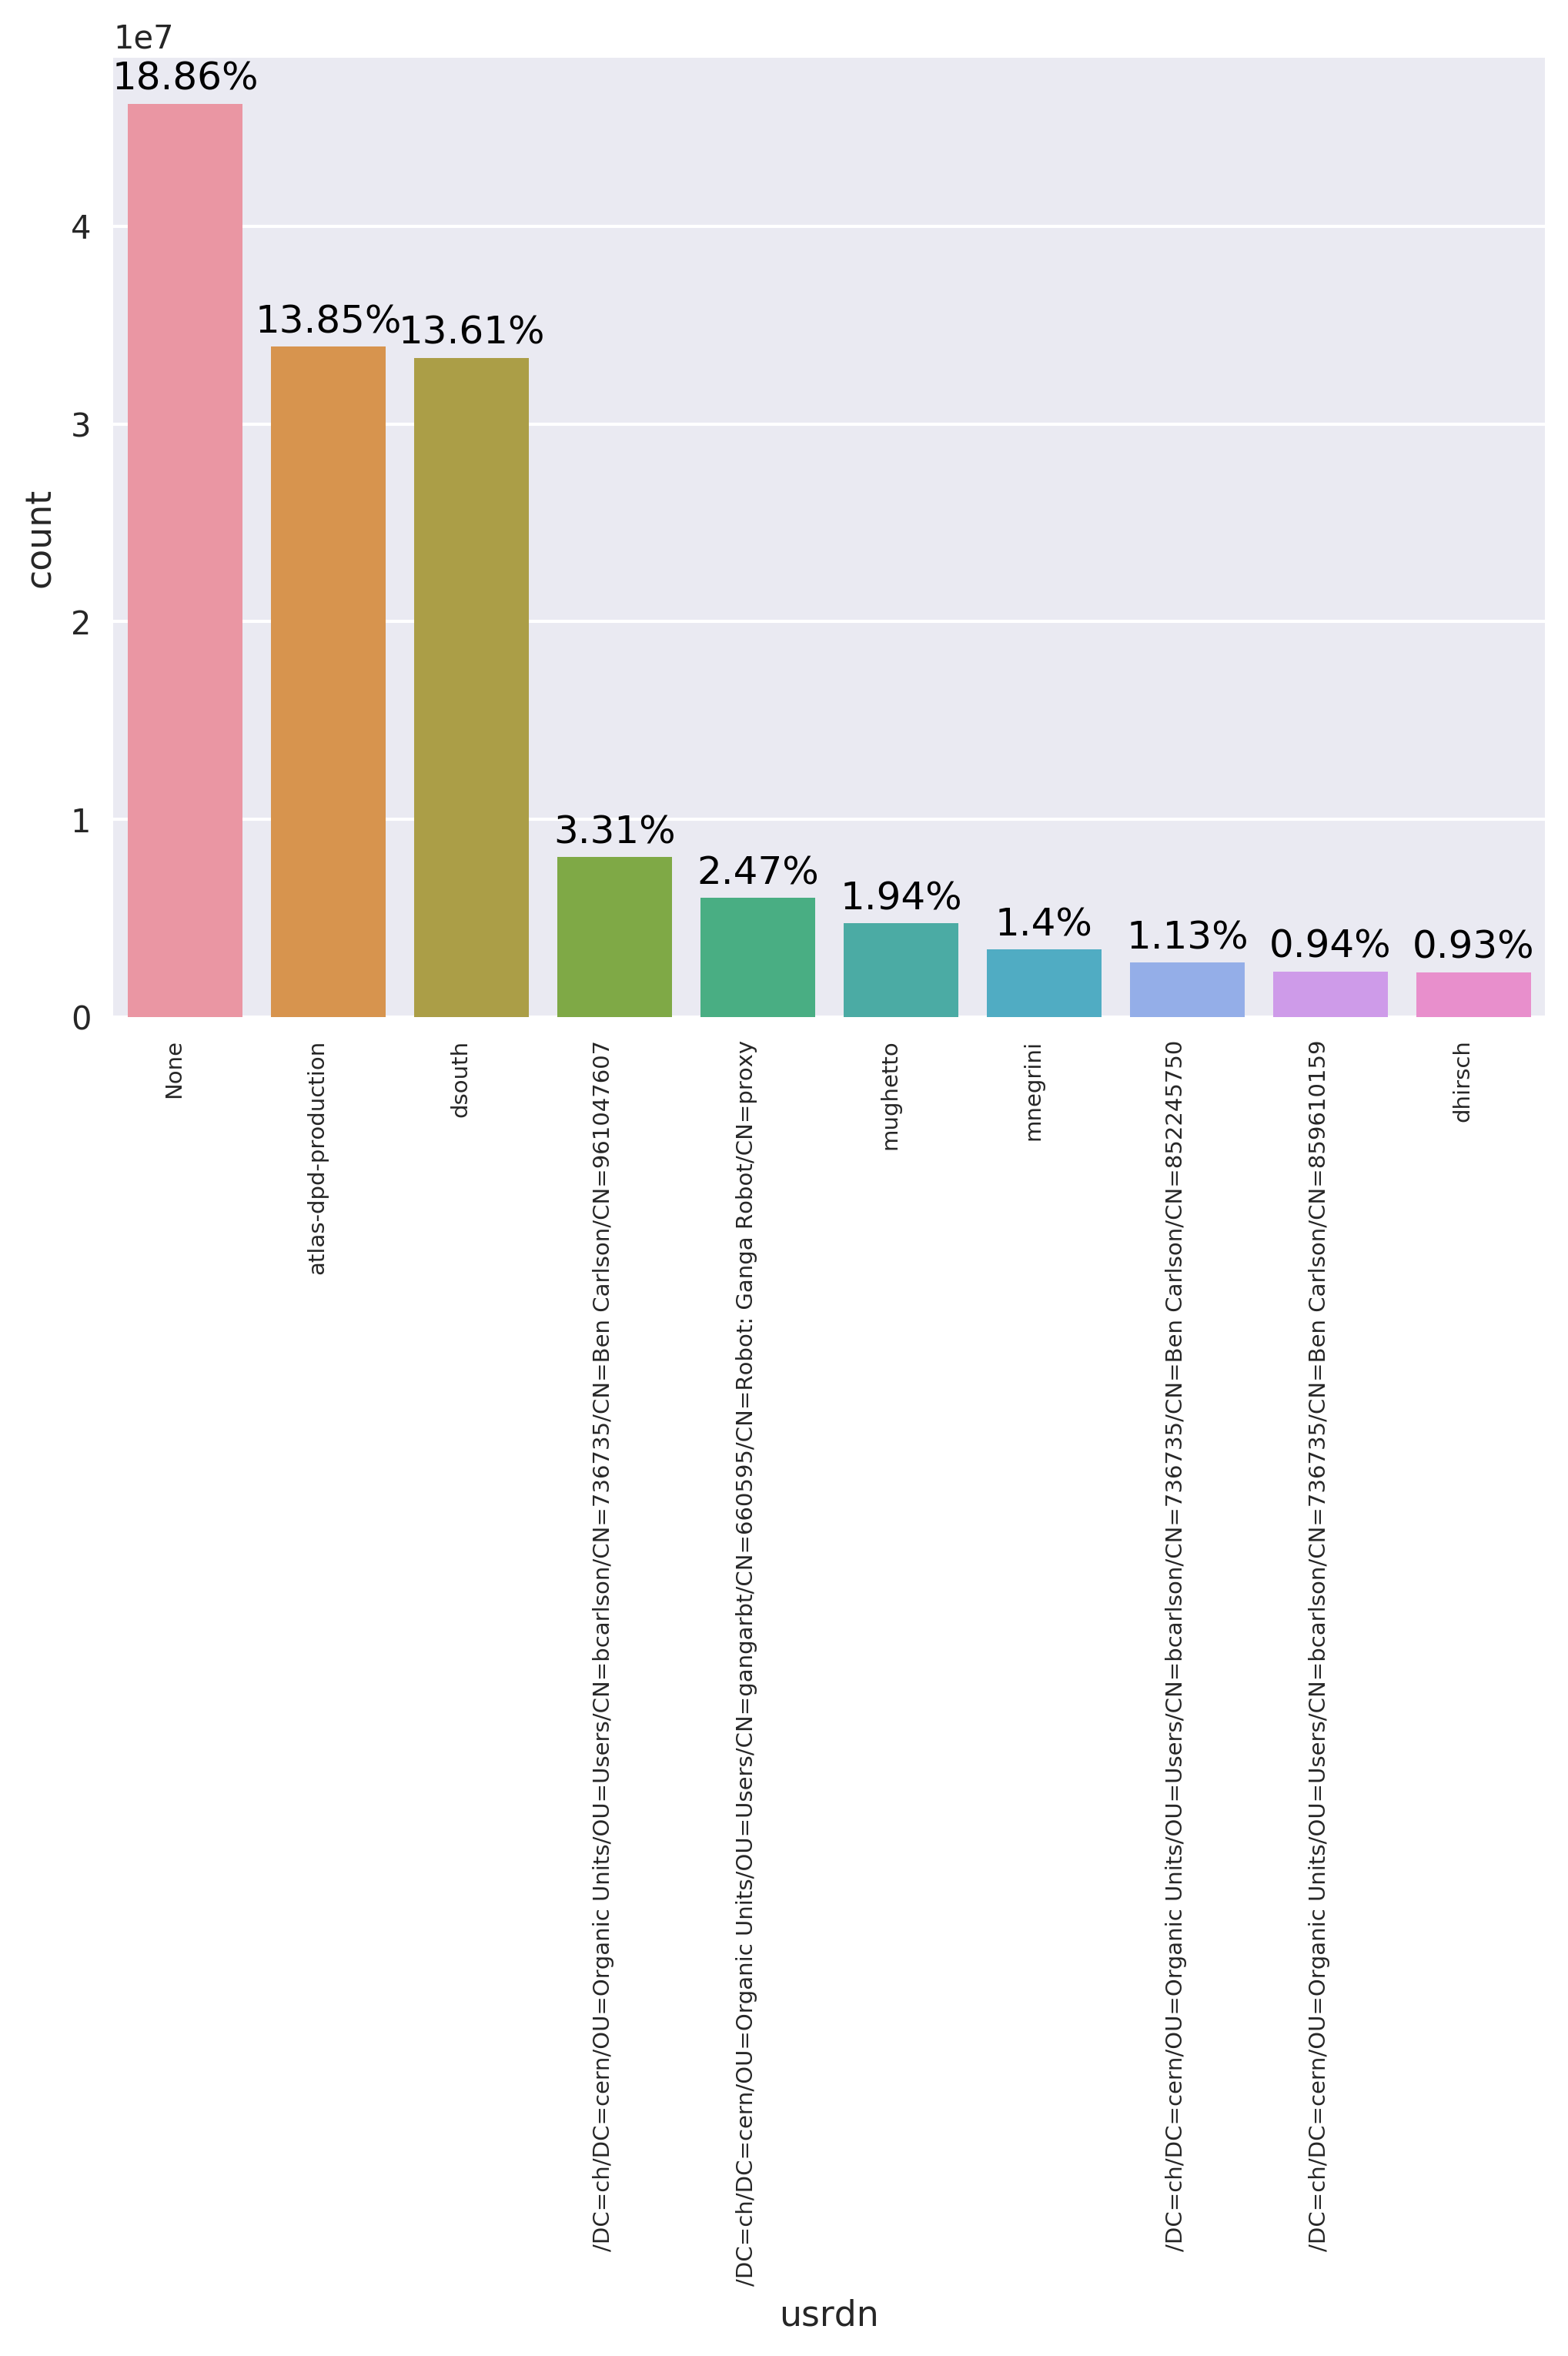

In [121]:
df_plot27['usrdn'] = df_plot27.usrdn.astype(str)

ax=sns.barplot(x="usrdn", y="count", data=df_plot27, ci=None)

for index, row in df_plot27.iterrows():
    ax.text(row.name,row['count']+700000, "%s%%" % row.percentage , color='black', ha="center")

ax.set(ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, ha="right", fontsize=7)